# Прогнозирование стоимости автомобиля

### Описание задачи

 Необходимо построить модель для определения рыночной стоимости автомобиля с пробегом. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.
 
Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения. 

### Описание данных

Данные получены из файла autos.csv, который содержит:

Признаки: 

* Дата скачивания анкеты из базы
* Тип автомобильного кузова
* Год регистрации автомобиля
* Тип коробки передач
* Мощность (л. с.)
* Модель автомобиля
* Пробег (км)
* Месяц регистрации автомобиля
* Тип топлива
* Марка автомобиля
* Была машина в ремонте или нет
* Дата создания анкеты
* Количество фотографий автомобиля
* Почтовый индекс владельца анкеты (пользователя)
* Дата последней активности пользователя

Целевой признак:

* Цена (евро)

### План работы

1. [Первичное ознакомление с данными.](#pass_1) Загрузить датафрем, провести первичный анализ данных. Наметить план дальнейшей работы с данными.
2. [Предобработка данных.](#pass_2) Проверить и устранить наличие пропусков, явных дубликатов. Привести к необходимым типам данных. Сделать промежуточные выводы.
3. [Анализ данных.](#pass_3) Провести исследование данных, проверить распределение, выявить есть аномальные выбросы и взаимосвязи между данными. Сформулировать промежуточные выводы.
4. [Подготовка данных к обучению.](#pass_4) Выделение признаков и целевого для обучения. Разделение датасета на выборки, а также закодировать категориальные признаки.
5. [Анализ моделей.](#pass_5) Подбор гиперпараметров, обучение и выбор наилучшей модели для тестирования.
6. [Тестирование.](#pass_6) Проверка модели на тестовой выборке.
7. [Общий вывод](#pass_7) по результатам проведенного исследования.

<a id='pass_1'></a>
## Первичное ознакомление с данными.

In [1]:
!pip install category_encoders
!pip install phik==0.10.0

In [2]:
import pandas as pd
import numpy as np
import os.path
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import category_encoders as ce
import phik
import time
import lightgbm

from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

In [4]:
data_os = os.path.abspath('/datasets/autos.csv')
data = pd.read_csv(data_os)

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
print('*' * 100)
print(data.info())
print('*' * 100)
print('Количество явных дубликатов:', data.duplicated().sum())
print('*' * 100) 
print('Количество пропусков:')
print(data.isna().sum()/len(data)) 


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode     

**Вывод:**

В результате первичного ознакомления данных видно следующее:
* в датафрейме всего 354369 строк и 16 столбцов. 
* В столбцах VehicleType, Gearbox, Model, FuelType и Repaired имеется большое количество пропусков.
* В данных присутствует 4 явных дубликата. 
* Столбцы DateCrawled, DateCreated, NumberOfPictures, PostalCode, RegistrationMonth и LastSeen не являются важными для исследования, т.к. их наличие никак не влияет на стоимость автомобиля.

<a id='pass_2'></a>
## Предобработка данных.

Необходимо удалить дубликаты и столбцы, не имеющие важного значения для дальнейшего исследования.

In [7]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)
data = data.drop_duplicates()

In [8]:
print(data.columns)
print('Количество явных дубликатов:', data.duplicated().sum())

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')
Количество явных дубликатов: 0


Приведение наименования столбцов к единому стилю написания.

In [9]:
data.rename(columns = {'VehicleType':'vehicle_type', 
                       'RegistrationYear':'registration_year', 
                       'FuelType':'fuel_type'}, inplace = True )
data.columns = [x.lower() for x in data.columns]

В столбце repaired содержится информации о ремонте автомобиля. Пропуски в этом столбце возможно связаны с тем, что автомобиль не ремонтировали. Еще один из вариантов возникновения пропусков в данном столбце, что владельцы решили не предоставлять данную информацию в базе. Поэтому пропуски здесь заполним значением 'no'.

In [10]:
data['repaired'] = data['repaired'].fillna('no')

В оставшихся столбцах причиной появления пропусков скорее всего является технической проблемой при выгрузке данных. Заполнение в данном случае можно сделать наиболее часто встречающимися значениями с предварительной группировкой данных по другим столбцам:
* модель автомобиля восстановить по бренду и году регистрации автомобиля
* тип кузова, тип топлива и тип коробки передач по бренду и модели автомобиля


Поскольку необходимо восстанавливать данные нескольких столбцов по разным группировкам, то лучше написать собственную функцию.

In [11]:
def fillna_group(column1, column2, column3):
    data[column1] = data.groupby([column2, column3])[column1].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'Empty')))

In [12]:
fillna_group('model', 'brand', 'registration_year')
fillna_group('vehicle_type', 'brand', 'model')
fillna_group('gearbox', 'brand', 'model')
fillna_group('fuel_type', 'brand', 'model')

In [13]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Пропуски устранены.

**Вывод:**

В результате предобработки было сделано следующее:
* Были удалены столбцы DateCrawled, DateCreated, NumberOfPictures, PostalCode, RegistrationMonth и LastSeen не являются важными для исследования, т.к. их наличие никак не влияет на стоимость автомобиля.


* Наименования приведены к единому общепринятому стилю написания.


* Заполнены пропуски в столбцах VehicleType, Gearbox, Model, FuelType и Repaired. Заполнение пропусков осуществлялось группировкой данных по значениям других столбцов (бред, модель и год регистрации) и заполнение наиболее часто встречающимися значениями в них.


<a id='pass_3'></a>
## Анализ данных.

Необходимо проверить распределение данных.

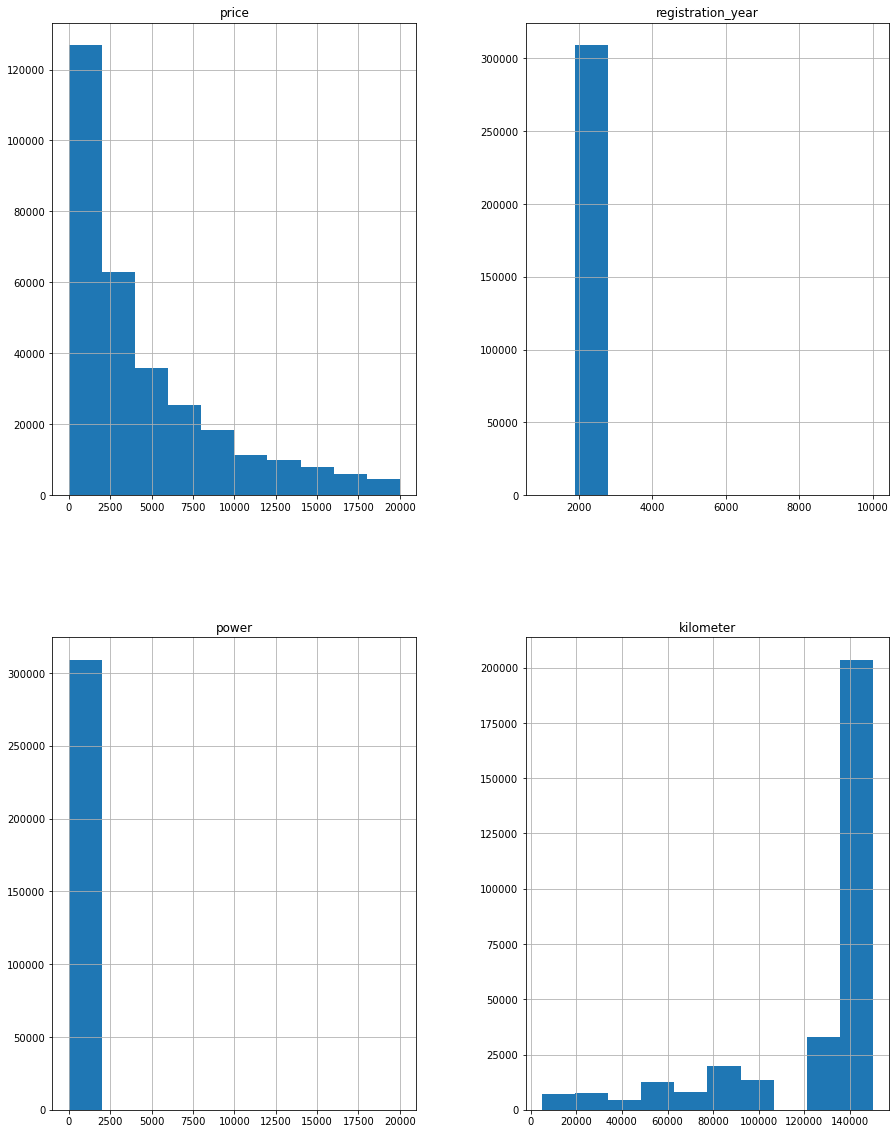

In [14]:
data.hist(figsize=(15, 20))
plt.show()

Гистограммы по году регистрации и мощности двигателя не информативны, их нужно отдельно проверить на наличие аномальных значений. Гистограмма с ценой показывает аномалии, которые необходимо устранить.

Отдельно посмотрим распределение категориальных признаков.

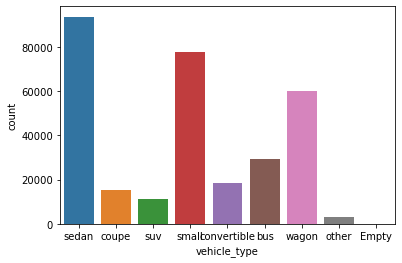

In [15]:
warnings.filterwarnings('ignore')
sns.countplot(data.vehicle_type)
plt.show()

Наиболее распространённые типы кузова sedan, small и wagon.

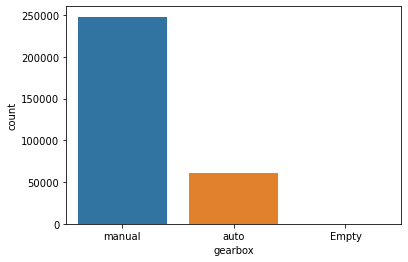

In [16]:
sns.countplot(data.gearbox)
plt.show()

Большинство представленных машин имеет механическую коробку передач.

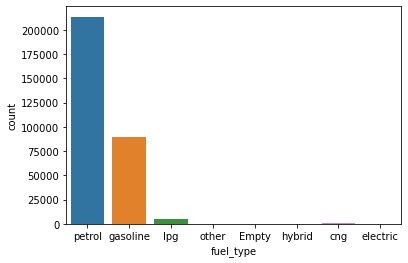

In [17]:
sns.countplot(data.fuel_type)
plt.show()

Наиболее популярный тип топлива бензин и газ.

Поскольку некоторые гистограммы не очень информативны, необходимо привести их порядок.

In [18]:
data['price'].sort_values().value_counts()

0       8904
500     4650
1500    4533
1000    3875
1200    3799
        ... 
6230       1
6229       1
6225       1
6220       1
5865       1
Name: price, Length: 3731, dtype: int64

In [19]:
print('Максимальная стоимость автомобиля:', data['price'].max())

Максимальная стоимость автомобиля: 20000


В данных по цене имеется 9387 строк с нулевыми ценами. В данном случае с этим ничего не сделаешь и данные строки необходимо отсечь и проверить распределение остальных значений. Минимальная стоимость автомобиля 500 евро, при курсе евро на 08.02.23 г. 75,91 руб. это составляет 37 955 рублей. Данная стоимость возможна для старых автомобилей или автомобилей с сильными повреждениями. Такую категорию следует оставить. Максимальная стоимость автомобиля 20 000 евро. Такая стоимость, может быть, у автомобиля бизнес-класса или это может быть автомобиль с более свежим годом выпуска, поэтому тоже такие значения оставляем.

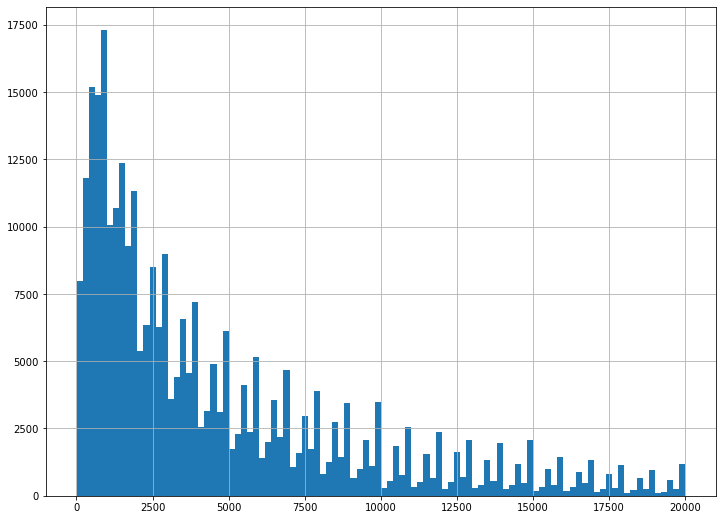

In [20]:
data = data.query('price > 0')
data['price'].hist(bins=100, figsize=(12,9))
plt.show()

Проверим данные года регистрации.

In [21]:
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1959, 1956,
       3200, 1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957,
       1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 6500, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1934,
       1938, 1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931,
       4500, 1602, 7800, 1947, 1927, 7100, 8200, 1946], dtype=int64)

В данных по дате регистрации есть много некорректных значений. например 1200 не может быть, т.к. автомобиль был изобретен в 1768  г., а запатентован в 1886 году. Поскольку это база действующих автомобилей, то нам необходимо отсечь все автомобили  до 1970 года. Поскольку в уникальных значениях присутствуют еще странные значения, превышающие текущий год (2023), их тоже необходимо исключить.  

In [22]:
data = data.query('1970 < registration_year < 2023')
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2016, 2007,
       2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991, 1984,
       2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015,
       1982, 1976, 1983, 1973, 1971, 1987, 1986, 1988, 1980, 1974, 1979,
       1978, 1972, 1977, 1975, 2019], dtype=int64)

Рассмотрим данные по мощности двигателя автомобиля.

In [23]:
data['power'].describe()

count    298933.000000
mean        111.887537
std         196.898672
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Исходя из полученных данных есть автомобили с нулевой мощность. Возможно, это автомобили без двигателя и предназначены для разбора на запчасти. Максимальная мощность 20 000 л.с. Возможно это была ошибка при заполнении данных. Такая мощность характерна для самолетов, но уж точно не для автомобилей. Современные спорткары имеют мощность как правило в среднем 1000-1500 л.с. Поэтому нам необходимо отсечь автомобили с нулевой мощностью и автомобили с мощность более 1000 л.с.

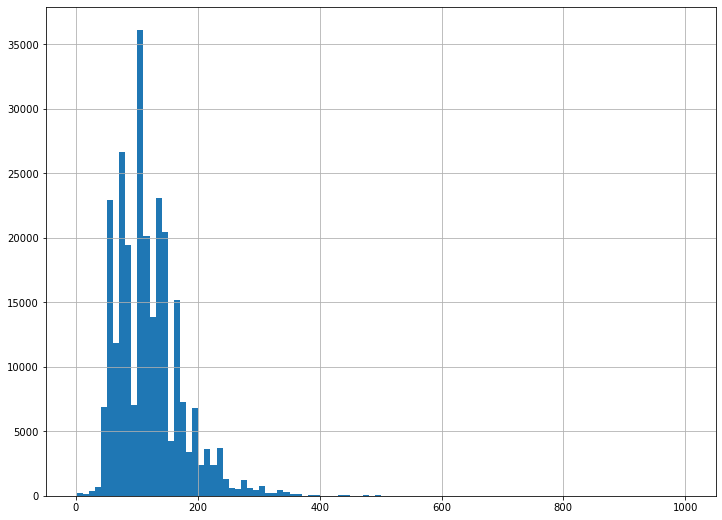

In [24]:
data = data.query('0 < power < 1001')
data['power'].hist(bins=100, figsize=(12,9))
plt.show()

Поскольку значений более 400 л.с. крайне мало, то можно отсечь их.

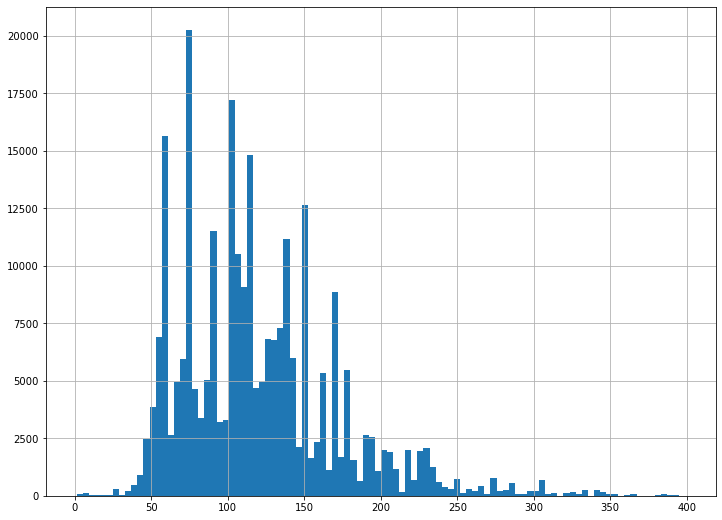

In [25]:
data = data.query('power < 400')
data['power'].hist(bins=100, figsize=(12,9))
plt.show()

Проверим корреляцию признаков.

In [26]:

phik_overview = data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.00,0.26,0.68,0.31,0.50,0.58,0.31,0.25,0.36,0.31
vehicle_type,0.26,1.00,0.19,0.27,0.50,0.91,0.18,0.32,0.64,0.06
registration_year,0.68,0.19,1.00,0.12,0.29,0.64,0.41,0.25,0.36,0.16
gearbox,0.31,0.27,0.12,1.00,0.58,0.64,0.03,0.14,0.53,0.03
power,0.50,0.50,0.29,0.58,1.00,0.81,0.12,0.27,0.64,0.07
model,0.58,0.91,0.64,0.64,0.81,1.00,0.44,0.55,1.00,0.12
kilometer,0.31,0.18,0.41,0.03,0.12,0.44,1.00,0.16,0.27,0.09
fuel_type,0.25,0.32,0.25,0.14,0.27,0.55,0.16,1.00,0.32,0.03
brand,0.36,0.64,0.36,0.53,0.64,1.00,0.27,0.32,1.00,0.08
repaired,0.31,0.06,0.16,0.03,0.07,0.12,0.09,0.03,0.08,1.00


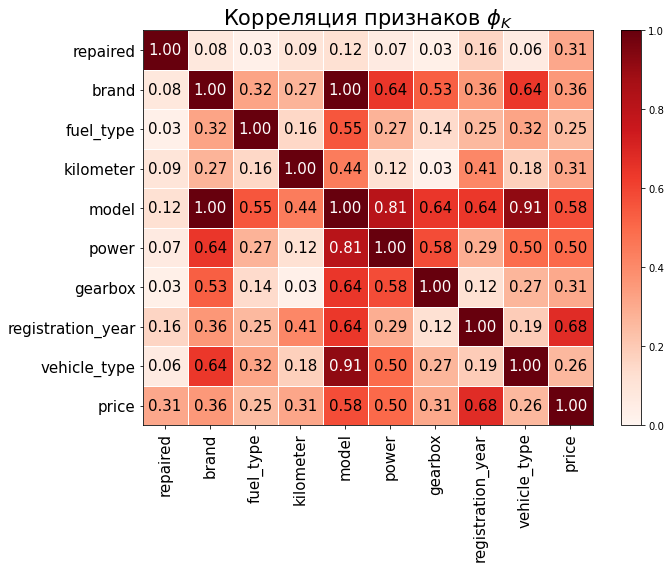

In [27]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"Корреляция признаков $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

По полученным результатам видно, что среди признаков видно наличие очень сильных взаимосвязей: между брендом и модель, мощность двигателя и моделью, моделью и типом коробки. Наличие сильных взаимосвязей между брендом, моделью, типом коробки, мощностью двигателя вполне логично, т.к. каждый бренд выпускает свои модели автомобилей со своими уникальными характеристиками. 

 Кроме этого, наблюдается интересная взаимосвязи цены с годом регистрации автомобиля, моделью и мощностью двигателя. Необходимо дополнительно посмотреть на графиках эти взаимосвязи с ценой. 

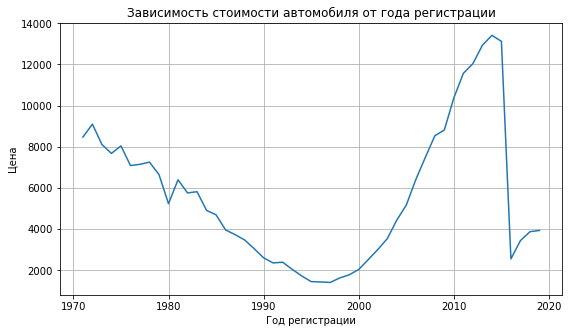

In [28]:
(data.pivot_table(index='registration_year', values='price')
 .plot(ylabel='Цена',
       xlabel='Год регистрации',
       title='Зависимость стоимости автомобиля от года регистрации',
       legend=None,
       grid=True, 
       figsize=(9, 5))
)
plt.show()

На графике видны два спада: первый постепенный с 1972-1973 гг. до середины 90х гг. и второй (резкий спад) 2014-2016 гг. Данные спады возможно связаны с кризисами тех времен.  

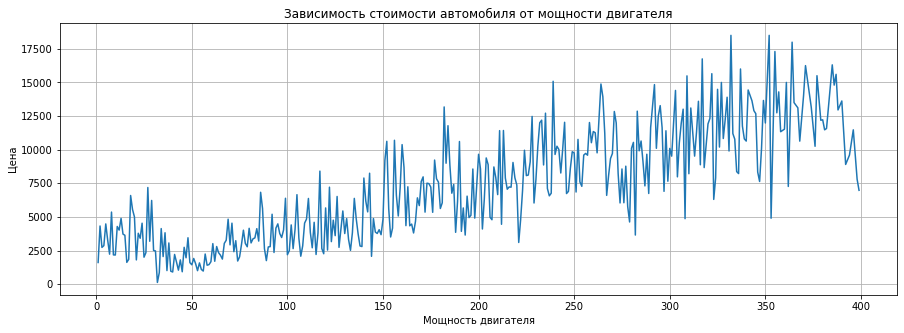

In [29]:
(data.pivot_table(index='power', values='price')
 .plot(ylabel='Цена',
       xlabel='Мощность двигателя',
       title='Зависимость стоимости автомобиля от мощности двигателя',
       legend=None,
       grid=True, 
       figsize=(15, 5))
)
plt.show()

На данном графике видно, что в целом с увеличение мощности двигателя ведет к увеличению стоимости автомобиля.

**Вывод:**

В процессе анализа было обнаружено следующее:

1. Наибольшей популярностью пользуются автомобили с типом кузова sedan, small, wagon, механической коробкой передач, с бензиновыми или газовыми двигателями.


2. В данных о стоимости автомобиля, годе регистрации и мощности двигателя обнаружены аномальные значения. Например, в стоимости автомобиля есть авто с нулевой стоимостью, мощностью двигателя как у самолета (20 000 л.с.), или годом регистрации 1200 или 2800.


3. Выявлена достаточно сильная корреляция между следующими признаками: бренд/модель, модель/тип коробки и модель/ мощность двигателя. Наличие столь сильной взаимосвязи вполне логично, т.к. каждый бренд выпускает свои модели со своими уникальными характеристиками.


4. На стоимость автомобиля оказывают влияние следующие признаки: год регистрации и мощность двигателя. При исследовании взаимосвязи были выявлено, что стоимость автомобиля падала в период 1972-1973 гг. (плавное снижение стоимости) и резкое падение цены в период 2014-2016 гг. Это может быть взаимосвязано с  кризисами тех времен. Так же было обнаружено увеличение стоимости автомобиля при увеличении мощности.

<a id='pass_4'></a>
## Подготовка данных к обучению.

Выделим признаки и целевой признак.

По условию задачи необходимо обучить хотя бы одну модель не градиентным бустингом. Для этой модели необходимо закодировать категориальные признаки. Использовать лучше всего Target Encoder.

Сначала необходимо разделить датафрейм на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Затем выделить целевой признак и признаки.

In [30]:
data_train, data_valid = train_test_split(data, test_size=.4, random_state=12345)
data_valid, data_test = train_test_split(data_valid, test_size=.5, random_state=12345)
print("Размер обучающей выборки: {:.0%}".format(data_train.shape[0] / data.shape[0]))
print("Размер валидационной выборки: {:.0%}".format(data_valid.shape[0] / data.shape[0]))
print("Размер тестовой выборки: {:.0%}".format(data_test.shape[0] / data.shape[0]))

Размер обучающей выборки: 60%
Размер валидационной выборки: 20%
Размер тестовой выборки: 20%


In [31]:
features_train = data_train.drop(['price'], axis=1)
features_valid = data_valid.drop(['price'], axis=1)
features_test = data_test.drop(['price'], axis=1)

target_train = data_train['price']
target_valid = data_valid['price']
target_test = data_test['price']
print(features_train.dtypes)

vehicle_type         object
registration_year     int64
gearbox              object
power                 int64
model                object
kilometer             int64
fuel_type            object
brand                object
repaired             object
dtype: object


Займемся кодированием категориальных признаков. Сделаем 2 типа подготовки данных: 
1. Кодировка с помощью TargetEncoder
2. Приведение категориальных признаков к типу category

In [32]:
encoder = ce.TargetEncoder(return_df=True)
features_train_te = encoder.fit_transform(features_train, target_train)
features_train_te.dtypes

vehicle_type         float64
registration_year      int64
gearbox              float64
power                  int64
model                float64
kilometer              int64
fuel_type            float64
brand                float64
repaired             float64
dtype: object

In [33]:
features_valid_te = encoder.transform(features_valid)
features_valid_te.dtypes

vehicle_type         float64
registration_year      int64
gearbox              float64
power                  int64
model                float64
kilometer              int64
fuel_type            float64
brand                float64
repaired             float64
dtype: object

In [34]:
features_test_te = encoder.transform(features_test)
features_test_te.dtypes

vehicle_type         float64
registration_year      int64
gearbox              float64
power                  int64
model                float64
kilometer              int64
fuel_type            float64
brand                float64
repaired             float64
dtype: object

In [35]:
features_train_category = features_train.astype({"vehicle_type":'category',
                                  "gearbox":'category',
                                  "model":'category',
                                  "fuel_type":'category',
                                  "brand":'category',
                                  "repaired":'category'})
features_train_category.dtypes

vehicle_type         category
registration_year       int64
gearbox              category
power                   int64
model                category
kilometer               int64
fuel_type            category
brand                category
repaired             category
dtype: object

In [36]:
features_valid_category = features_valid.astype({"vehicle_type":'category',
                                  "gearbox":'category',
                                  "model":'category',
                                  "fuel_type":'category',
                                  "brand":'category',
                                  "repaired":'category'})
features_valid_category.dtypes

vehicle_type         category
registration_year       int64
gearbox              category
power                   int64
model                category
kilometer               int64
fuel_type            category
brand                category
repaired             category
dtype: object

In [37]:
features_test_category = features_train.astype({"vehicle_type":'category',
                                  "gearbox":'category',
                                  "model":'category',
                                  "fuel_type":'category',
                                  "brand":'category',
                                  "repaired":'category'})
features_test_category.dtypes

vehicle_type         category
registration_year       int64
gearbox              category
power                   int64
model                category
kilometer               int64
fuel_type            category
brand                category
repaired             category
dtype: object

Данные закодированы и готовы к дальнейшему обучению моделей.

**Вывод:**

При подготовке данных к обучению было сделано следующее:


1. Данные были разделены на 3 выборки (обучающую, валидационную и тестовую) в соотношение 60%, 20% и 20%. Выделен целевой признак и признаки.


2. По условию задачи необходимо обучить для сравнения хотя бы одну модель не градиентным бустингом, то категориальные признаки были закодированы и сохранены в отдельную переменную для данной модели. Для кодировки применялся метод TargetEncoder. Поскольку у нас задача предсказания цены авто, целевая метка - цена авто, то каждое значение марки авто в нашем признаке brand кодируется средней ценой автомобиля данного бренда.


Данные полностью готовы для дальнейшего обучения модели.


<a id='pass_5'></a>
## Анализ моделей

Для анализа выбрано 6 моделей обучения:
* Линейная регрессия
* Lasso
* DecisionTreeRegressor
* RandomForestRegressor
* CatBoost
* LightGBM

Поскольку у заказчика главные критерии выбора модели скорость обучения и предсказания, то создадим собственные функции для вычислений данных показателей.


In [38]:
def learn(model, features_train, target_train):
    start = time.time()
    model.fit(features_train, target_train)
    end = time.time()
    fit_time = end - start
    
    return fit_time , model

In [39]:
def predict(model, features_valid):
    start = time.time()
    predict = model.predict(features_valid)
    end = time.time()
    predict_time = end - start
   
    return predict_time , predict

Создание таблицы для занесения результатов по каждой модели.

In [40]:
index_table = 0
table = pd.DataFrame(columns=['Модель','RMSE','Время обучения', 'Время предсказания'])


Для линейных моделей посмотрим будет ли влиять масштабирование признаков на результаты.

### LinearRegression + StandardScaler()

Обучение модели линейной регрессии с масштабированием признаков.

In [41]:
%%time

learn_time_ln_sc, model_fit_ln_sc = learn(make_pipeline(StandardScaler(),LinearRegression()), features_train_te, target_train)
predict_time_ln_sc, predict_ln_model_sc = predict(model_fit_ln_sc, features_valid_te)
rmse_ln_model_sc = mse(target_valid, predict_ln_model_sc, squared=False)
print('RMSE модели LinearRegressor =', rmse_ln_model_sc)

RMSE модели LinearRegressor = 2832.542229073171
CPU times: total: 93.8 ms
Wall time: 84.5 ms


In [42]:
index_table +=1
table.loc[index_table] = ['LinearRegression + StandardScaler', rmse_ln_model_sc, learn_time_ln_sc, predict_time_ln_sc]
table

,Модель,RMSE,Время обучения,Время предсказания
1,LinearRegression + StandardScaler,2832.542229,0.076365,0.00809


### LinearRegression

Обучение модели линейной регрессии без масштабирования признаков.

In [43]:
%%time

learn_time_ln, model_fit_ln = learn(LinearRegression(), features_train_te, target_train)
predict_time_ln, predict_ln_model = predict(model_fit_ln, features_valid_te)
rmse_ln_model = mse(target_valid, predict_ln_model, squared=False)
print('RMSE модели LinearRegressor =', rmse_ln_model)

RMSE модели LinearRegressor = 2832.5422290731726
CPU times: total: 156 ms
Wall time: 33.5 ms


In [44]:
index_table +=1
table.loc[index_table] = ['LinearRegression', rmse_ln_model, learn_time_ln, predict_time_ln]
table

,Модель,RMSE,Время обучения,Время предсказания
1,LinearRegression + StandardScaler,2832.542229,0.076365,0.008090
2,LinearRegression,2832.542229,0.030483,0.001994


У модели LinearRegression масштабирование признаков не влияет на метрику RMSE. При отсутствии масштабирования признаков время обучения и предсказания немного уменьшаются.

### Lasso + StandartScaler()

Обучение модели Lasso с масштабированием.

In [45]:
%%time

learn_time_lasso_sc, model_fit_lasso_sc = learn(make_pipeline(StandardScaler(),Lasso(alpha=0.5,random_state=12345)), 
                                          features_train_te, target_train)
predict_time_lasso_sc, predict_lasso_model_sc = predict(model_fit_lasso_sc, features_valid_te)
rmse_lasso_model_sc = mse(target_valid, predict_lasso_model_sc, squared=False)
print('RMSE модели Lasso + StandartScaler =', rmse_lasso_model_sc)

RMSE модели Lasso + StandartScaler = 2832.5462101649755
CPU times: total: 219 ms
Wall time: 42.4 ms


Занесем полученные результаты в таблицу.

In [46]:
index_table +=1
table.loc[index_table] = ['Lasso + StandartScaler', rmse_lasso_model_sc, learn_time_lasso_sc, predict_time_lasso_sc]
table

,Модель,RMSE,Время обучения,Время предсказания
1,LinearRegression + StandardScaler,2832.542229,0.076365,0.008090
2,LinearRegression,2832.542229,0.030483,0.001994
3,Lasso + StandartScaler,2832.546210,0.042356,0.000000


### Lasso

Обучение модели Lasso без масштабирования признаков.

In [47]:
%%time

learn_time_lasso, model_fit_lasso = learn(Lasso(alpha=0.5,random_state=12345), 
                                          features_train_te, target_train)
predict_time_lasso, predict_lasso_model = predict(model_fit_lasso, features_valid_te)
rmse_lasso_model = mse(target_valid, predict_lasso_model, squared=False)
print('RMSE модели Lasso =', rmse_lasso_model)

RMSE модели Lasso = 2832.541538379874
CPU times: total: 125 ms
Wall time: 33 ms


In [48]:
index_table +=1
table.loc[index_table] = ['Lasso', rmse_lasso_model, learn_time_lasso, predict_time_lasso]
table

,Модель,RMSE,Время обучения,Время предсказания
1,LinearRegression + StandardScaler,2832.542229,0.076365,0.008090
2,LinearRegression,2832.542229,0.030483,0.001994
3,Lasso + StandartScaler,2832.546210,0.042356,0.000000
4,Lasso,2832.541538,0.032963,0.000000


У модели Lasso масштабирование признаков немного улучшает метрику RMSE, но эти изменения ничтожно малы. При отсутствии масштабирования признаков время обучения и предсказания немного увеличивается.

В целом видно, что масштабирование признаков у линейных моделей не влияет на наши показатели.

### DecisionTreeRegressor

Обучение модели DecisionTreeRegressor.

In [49]:
%%time
learn_time_tree,model_fit_tree = learn(DecisionTreeRegressor(),features_train_te, target_train)
predict_time_tree, predict_tree_model = predict(model_fit_tree,features_valid_te)
rmse_tree_model = mse(target_valid, predict_tree_model, squared=False)
print('RMSE модели DecisionTreeRegressor =', rmse_tree_model)

RMSE модели DecisionTreeRegressor = 2022.8047452181631
CPU times: total: 1.19 s
Wall time: 526 ms


Занесем полученные результаты в таблицу

In [50]:
index_table +=1
table.loc[index_table] = ['DecisionTreeRegressor', rmse_tree_model, learn_time_tree, predict_time_tree]
table

,Модель,RMSE,Время обучения,Время предсказания
1,LinearRegression + StandardScaler,2832.542229,0.076365,0.008090
2,LinearRegression,2832.542229,0.030483,0.001994
3,Lasso + StandartScaler,2832.546210,0.042356,0.000000
4,Lasso,2832.541538,0.032963,0.000000
5,DecisionTreeRegressor,2022.804745,0.510801,0.015571


Значение параметра RMSE у модели DecisionTreeRegressor лучше, чем у линейных моделей. А на обучение затрачивается немного больше времени.

### RandomForestRegressor

Для модели RandomForestRegressor произведем подбор наилучших параметров с помощью метода GridSearch.

In [51]:
model_params = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2) }

In [52]:
%%time

grid = GridSearchCV(RandomForestRegressor(random_state=12345), model_params, cv=5, scoring='neg_mean_squared_error')
grid.fit(features_train_te, target_train)

print(grid.best_params_)

{'max_depth': 11, 'n_estimators': 50}
CPU times: total: 6min 19s
Wall time: 6min 20s


Произведем обучение модели по полученным лучшим параметрам и получим предсказания. Результаты занесем в таблицу.

In [53]:
%%time
forest_model = RandomForestRegressor(**grid.best_params_, random_state=12345)

learn_time_rf, model_fit_rf = learn(forest_model, features_train_te, target_train)
predict_time_rf, predict_rf_model = predict(model_fit_rf, features_valid_te)

rmse_rf_model = mse(target_valid, predict_rf_model, squared=False)

print('RMSE модели RandomForesterRegressor =', rmse_rf_model)

RMSE модели RandomForesterRegressor = 1792.7272241934818
CPU times: total: 9.05 s
Wall time: 9.06 s


In [54]:
index_table +=1
table.loc[index_table] = ['RandomForestRegressor', rmse_rf_model, learn_time_rf, predict_time_rf]
table

,Модель,RMSE,Время обучения,Время предсказания
1,LinearRegression + StandardScaler,2832.542229,0.076365,0.008090
2,LinearRegression,2832.542229,0.030483,0.001994
3,Lasso + StandartScaler,2832.546210,0.042356,0.000000
4,Lasso,2832.541538,0.032963,0.000000
5,DecisionTreeRegressor,2022.804745,0.510801,0.015571
6,RandomForestRegressor,1792.727224,8.799182,0.265563


Модель RandomForestRegressor дала лучший результат по RMSE. Времея обучения у данной модели больше, чем у всех предыдущих.

### CatBoostRegressor с категориальными признаками

Подберем наилучшие значения параметров для модели CatBoostRegressor. Данная модель может работать на прямую с категориальными признаками, поэтому проведем эксперимент: предадим ей данные для обучения без кодировки признаков и с кодировкой.

In [55]:
cat_features=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand','repaired']

In [56]:
%%time

catboost = CatBoostRegressor(loss_function='RMSE', iterations = 500)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(features_train, target_train, cat_features=cat_features), cv=3, verbose=False, plot=False)


0:	learn: 6171.3579992	test: 6209.2920860	best: 6209.2920860 (0)	total: 199ms	remaining: 1m 39s
1:	learn: 5681.1528157	test: 5719.0177620	best: 5719.0177620 (1)	total: 236ms	remaining: 58.7s
2:	learn: 5254.5164396	test: 5291.9550611	best: 5291.9550611 (2)	total: 278ms	remaining: 46s
3:	learn: 4873.5447973	test: 4911.2890410	best: 4911.2890410 (3)	total: 318ms	remaining: 39.5s
4:	learn: 4536.0618378	test: 4572.1267229	best: 4572.1267229 (4)	total: 359ms	remaining: 35.5s
5:	learn: 4242.9014477	test: 4277.7447255	best: 4277.7447255 (5)	total: 395ms	remaining: 32.5s
6:	learn: 3971.1256190	test: 4005.5229614	best: 4005.5229614 (6)	total: 441ms	remaining: 31.1s
7:	learn: 3739.7345422	test: 3773.2804484	best: 3773.2804484 (7)	total: 486ms	remaining: 29.9s
8:	learn: 3541.4908467	test: 3573.9097131	best: 3573.9097131 (8)	total: 528ms	remaining: 28.8s
9:	learn: 3357.1970619	test: 3389.7538610	best: 3389.7538610 (9)	total: 569ms	remaining: 27.9s
10:	learn: 3196.0104212	test: 3228.0548925	best: 32

89:	learn: 1859.3093338	test: 1854.4249262	best: 1854.4249262 (89)	total: 3.48s	remaining: 15.9s
90:	learn: 1855.7791691	test: 1852.7753905	best: 1852.7753905 (90)	total: 3.51s	remaining: 15.8s
91:	learn: 1853.9819801	test: 1850.9892821	best: 1850.9892821 (91)	total: 3.54s	remaining: 15.7s
92:	learn: 1852.3582161	test: 1849.1873687	best: 1849.1873687 (92)	total: 3.59s	remaining: 15.7s
93:	learn: 1850.8331363	test: 1847.7826857	best: 1847.7826857 (93)	total: 3.62s	remaining: 15.7s
94:	learn: 1848.3083862	test: 1845.9992131	best: 1845.9992131 (94)	total: 3.65s	remaining: 15.6s
95:	learn: 1846.7488132	test: 1844.4580427	best: 1844.4580427 (95)	total: 3.69s	remaining: 15.5s
96:	learn: 1845.5099221	test: 1843.0806879	best: 1843.0806879 (96)	total: 3.73s	remaining: 15.5s
97:	learn: 1844.1993913	test: 1841.7853115	best: 1841.7853115 (97)	total: 3.77s	remaining: 15.5s
98:	learn: 1842.7548728	test: 1840.1876716	best: 1840.1876716 (98)	total: 3.81s	remaining: 15.4s
99:	learn: 1841.3729053	test: 

177:	learn: 1769.4792715	test: 1771.8766102	best: 1771.8766102 (177)	total: 6.73s	remaining: 12.2s
178:	learn: 1768.8558628	test: 1771.4710020	best: 1771.4710020 (178)	total: 6.76s	remaining: 12.1s
179:	learn: 1767.9491107	test: 1770.9592870	best: 1770.9592870 (179)	total: 6.8s	remaining: 12.1s
180:	learn: 1767.2426845	test: 1770.6652987	best: 1770.6652987 (180)	total: 6.84s	remaining: 12.1s
181:	learn: 1766.7697744	test: 1770.1799270	best: 1770.1799270 (181)	total: 6.88s	remaining: 12s
182:	learn: 1766.4332168	test: 1769.9380586	best: 1769.9380586 (182)	total: 6.92s	remaining: 12s
183:	learn: 1764.8698400	test: 1768.9394625	best: 1768.9394625 (183)	total: 6.96s	remaining: 11.9s
184:	learn: 1764.4635949	test: 1768.5915321	best: 1768.5915321 (184)	total: 7s	remaining: 11.9s
185:	learn: 1764.0388746	test: 1768.2207544	best: 1768.2207544 (185)	total: 7.03s	remaining: 11.9s
186:	learn: 1763.5303380	test: 1767.7832671	best: 1767.7832671 (186)	total: 7.07s	remaining: 11.8s
187:	learn: 1763.0

265:	learn: 1723.2256162	test: 1737.8341785	best: 1737.8341785 (265)	total: 9.95s	remaining: 8.75s
266:	learn: 1722.7558812	test: 1737.3684602	best: 1737.3684602 (266)	total: 10s	remaining: 8.72s
267:	learn: 1722.3644953	test: 1737.0161276	best: 1737.0161276 (267)	total: 10s	remaining: 8.69s
268:	learn: 1722.0646623	test: 1736.7824503	best: 1736.7824503 (268)	total: 10.1s	remaining: 8.66s
269:	learn: 1721.7887448	test: 1736.4742114	best: 1736.4742114 (269)	total: 10.1s	remaining: 8.62s
270:	learn: 1721.4827737	test: 1736.2507235	best: 1736.2507235 (270)	total: 10.2s	remaining: 8.58s
271:	learn: 1721.1466697	test: 1735.9799811	best: 1735.9799811 (271)	total: 10.2s	remaining: 8.54s
272:	learn: 1720.7946463	test: 1735.8462671	best: 1735.8462671 (272)	total: 10.2s	remaining: 8.5s
273:	learn: 1720.3290014	test: 1735.3470109	best: 1735.3470109 (273)	total: 10.3s	remaining: 8.46s
274:	learn: 1720.0374130	test: 1735.1427533	best: 1735.1427533 (274)	total: 10.3s	remaining: 8.43s
275:	learn: 171

353:	learn: 1698.2378753	test: 1718.9264857	best: 1718.9264857 (353)	total: 13.2s	remaining: 5.44s
354:	learn: 1698.0079842	test: 1718.7879521	best: 1718.7879521 (354)	total: 13.2s	remaining: 5.41s
355:	learn: 1697.4728310	test: 1718.3869816	best: 1718.3869816 (355)	total: 13.3s	remaining: 5.37s
356:	learn: 1697.2342885	test: 1718.1657607	best: 1718.1657607 (356)	total: 13.3s	remaining: 5.34s
357:	learn: 1697.1066069	test: 1718.0264655	best: 1718.0264655 (357)	total: 13.4s	remaining: 5.3s
358:	learn: 1697.0211850	test: 1718.0148003	best: 1718.0148003 (358)	total: 13.4s	remaining: 5.26s
359:	learn: 1696.7758586	test: 1717.8665553	best: 1717.8665553 (359)	total: 13.4s	remaining: 5.22s
360:	learn: 1696.5308798	test: 1717.7662658	best: 1717.7662658 (360)	total: 13.5s	remaining: 5.18s
361:	learn: 1696.3946511	test: 1717.7080926	best: 1717.7080926 (361)	total: 13.5s	remaining: 5.15s
362:	learn: 1696.1154805	test: 1717.5678274	best: 1717.5678274 (362)	total: 13.5s	remaining: 5.11s
363:	learn:

437:	learn: 1679.1335326	test: 1706.0099604	best: 1706.0099604 (437)	total: 16.4s	remaining: 2.31s
438:	learn: 1678.9907615	test: 1706.0169343	best: 1706.0099604 (437)	total: 16.4s	remaining: 2.28s
439:	learn: 1678.7096221	test: 1705.9298764	best: 1705.9298764 (439)	total: 16.4s	remaining: 2.24s
440:	learn: 1678.5485265	test: 1705.8267470	best: 1705.8267470 (440)	total: 16.5s	remaining: 2.2s
441:	learn: 1678.2806334	test: 1705.6985379	best: 1705.6985379 (441)	total: 16.5s	remaining: 2.16s
442:	learn: 1677.9919013	test: 1705.6063905	best: 1705.6063905 (442)	total: 16.5s	remaining: 2.13s
443:	learn: 1677.6224657	test: 1705.3967351	best: 1705.3967351 (443)	total: 16.6s	remaining: 2.09s
444:	learn: 1677.4686439	test: 1705.3291333	best: 1705.3291333 (444)	total: 16.6s	remaining: 2.05s
445:	learn: 1677.3084199	test: 1705.0476976	best: 1705.0476976 (445)	total: 16.6s	remaining: 2.02s
446:	learn: 1677.2412898	test: 1704.9237183	best: 1704.9237183 (446)	total: 16.7s	remaining: 1.98s
447:	learn:

25:	learn: 1888.0043191	test: 1886.8580196	best: 1886.8580196 (25)	total: 978ms	remaining: 17.8s
26:	learn: 1884.1089917	test: 1882.6402303	best: 1882.6402303 (26)	total: 1.01s	remaining: 17.8s
27:	learn: 1876.6131344	test: 1874.7361059	best: 1874.7361059 (27)	total: 1.05s	remaining: 17.7s
28:	learn: 1871.0018041	test: 1868.6466216	best: 1868.6466216 (28)	total: 1.08s	remaining: 17.5s
29:	learn: 1866.5076302	test: 1864.1317635	best: 1864.1317635 (29)	total: 1.11s	remaining: 17.5s
30:	learn: 1862.3343377	test: 1860.2489461	best: 1860.2489461 (30)	total: 1.15s	remaining: 17.4s
31:	learn: 1856.2530959	test: 1854.5843851	best: 1854.5843851 (31)	total: 1.2s	remaining: 17.5s
32:	learn: 1851.5879939	test: 1849.5005392	best: 1849.5005392 (32)	total: 1.24s	remaining: 17.5s
33:	learn: 1847.6151309	test: 1846.0196818	best: 1846.0196818 (33)	total: 1.28s	remaining: 17.5s
34:	learn: 1843.6191737	test: 1840.8855358	best: 1840.8855358 (34)	total: 1.31s	remaining: 17.4s
35:	learn: 1840.8526327	test: 1

112:	learn: 1704.8484329	test: 1728.1321918	best: 1728.1321918 (112)	total: 4.16s	remaining: 14.2s
113:	learn: 1703.8896379	test: 1726.9287642	best: 1726.9287642 (113)	total: 4.19s	remaining: 14.2s
114:	learn: 1703.0011872	test: 1726.4064510	best: 1726.4064510 (114)	total: 4.23s	remaining: 14.2s
115:	learn: 1702.6307879	test: 1726.3598939	best: 1726.3598939 (115)	total: 4.27s	remaining: 14.1s
116:	learn: 1702.0568151	test: 1726.1610170	best: 1726.1610170 (116)	total: 4.31s	remaining: 14.1s
117:	learn: 1701.3884830	test: 1725.5619447	best: 1725.5619447 (117)	total: 4.35s	remaining: 14.1s
118:	learn: 1700.6954923	test: 1724.9050052	best: 1724.9050052 (118)	total: 4.39s	remaining: 14s
119:	learn: 1698.8352543	test: 1724.8700904	best: 1724.8700904 (119)	total: 4.43s	remaining: 14s
120:	learn: 1698.2000984	test: 1724.5412557	best: 1724.5412557 (120)	total: 4.46s	remaining: 14s
121:	learn: 1697.2533459	test: 1723.7930763	best: 1723.7930763 (121)	total: 4.5s	remaining: 13.9s
122:	learn: 1696.

195:	learn: 1660.2233179	test: 1701.5835760	best: 1701.5835760 (195)	total: 7.29s	remaining: 11.3s
196:	learn: 1660.1212886	test: 1701.5307827	best: 1701.5307827 (196)	total: 7.32s	remaining: 11.3s
197:	learn: 1659.5784868	test: 1700.8369427	best: 1700.8369427 (197)	total: 7.36s	remaining: 11.2s
198:	learn: 1658.8965487	test: 1700.5822063	best: 1700.5822063 (198)	total: 7.4s	remaining: 11.2s
199:	learn: 1658.5163010	test: 1700.1905060	best: 1700.1905060 (199)	total: 7.43s	remaining: 11.1s
200:	learn: 1658.1695746	test: 1700.3188502	best: 1700.1905060 (199)	total: 7.47s	remaining: 11.1s
201:	learn: 1657.9248884	test: 1700.2056461	best: 1700.1905060 (199)	total: 7.51s	remaining: 11.1s
202:	learn: 1657.1879126	test: 1699.7827723	best: 1699.7827723 (202)	total: 7.56s	remaining: 11.1s
203:	learn: 1656.5421095	test: 1699.6328090	best: 1699.6328090 (203)	total: 7.6s	remaining: 11s
204:	learn: 1655.6812367	test: 1698.8412439	best: 1698.8412439 (204)	total: 7.63s	remaining: 11s
205:	learn: 1655

282:	learn: 1629.6645044	test: 1686.2929848	best: 1686.2929848 (282)	total: 10.7s	remaining: 8.17s
283:	learn: 1629.6126523	test: 1686.3003604	best: 1686.2929848 (282)	total: 10.7s	remaining: 8.13s
284:	learn: 1629.2936679	test: 1686.1872481	best: 1686.1872481 (284)	total: 10.7s	remaining: 8.09s
285:	learn: 1629.0382889	test: 1686.3155691	best: 1686.1872481 (284)	total: 10.8s	remaining: 8.06s
286:	learn: 1628.7977819	test: 1686.2612917	best: 1686.1872481 (284)	total: 10.8s	remaining: 8.02s
287:	learn: 1628.2931626	test: 1685.7794462	best: 1685.7794462 (287)	total: 10.8s	remaining: 7.98s
288:	learn: 1627.9644174	test: 1685.7844846	best: 1685.7794462 (287)	total: 10.9s	remaining: 7.94s
289:	learn: 1627.7487408	test: 1685.5566115	best: 1685.5566115 (289)	total: 10.9s	remaining: 7.89s
290:	learn: 1627.4996790	test: 1685.2954171	best: 1685.2954171 (290)	total: 10.9s	remaining: 7.86s
291:	learn: 1627.1798850	test: 1685.1995706	best: 1685.1995706 (291)	total: 11s	remaining: 7.83s
292:	learn: 

365:	learn: 1606.5696533	test: 1675.2234678	best: 1675.2234678 (365)	total: 13.8s	remaining: 5.07s
366:	learn: 1606.4601870	test: 1675.1974319	best: 1675.1974319 (366)	total: 13.9s	remaining: 5.03s
367:	learn: 1606.3196359	test: 1675.0286097	best: 1675.0286097 (367)	total: 13.9s	remaining: 4.99s
368:	learn: 1606.0370155	test: 1675.2684670	best: 1675.0286097 (367)	total: 14s	remaining: 4.96s
369:	learn: 1605.7578260	test: 1675.1362176	best: 1675.0286097 (367)	total: 14s	remaining: 4.92s
370:	learn: 1605.6385640	test: 1675.1978246	best: 1675.0286097 (367)	total: 14.1s	remaining: 4.88s
371:	learn: 1605.2601860	test: 1675.1798091	best: 1675.0286097 (367)	total: 14.1s	remaining: 4.85s
372:	learn: 1604.9321035	test: 1675.1191841	best: 1675.0286097 (367)	total: 14.1s	remaining: 4.81s
373:	learn: 1604.6906134	test: 1674.8910047	best: 1674.8910047 (373)	total: 14.2s	remaining: 4.78s
374:	learn: 1604.6554098	test: 1674.9079244	best: 1674.8910047 (373)	total: 14.2s	remaining: 4.74s
375:	learn: 16

450:	learn: 1590.4664444	test: 1670.5498298	best: 1670.5498298 (450)	total: 17.2s	remaining: 1.87s
451:	learn: 1590.3780961	test: 1670.5392450	best: 1670.5392450 (451)	total: 17.2s	remaining: 1.83s
452:	learn: 1590.3191333	test: 1670.5490770	best: 1670.5392450 (451)	total: 17.3s	remaining: 1.79s
453:	learn: 1589.8548334	test: 1670.5199260	best: 1670.5199260 (453)	total: 17.3s	remaining: 1.75s
454:	learn: 1589.6272807	test: 1670.3034493	best: 1670.3034493 (454)	total: 17.4s	remaining: 1.72s
455:	learn: 1589.3837891	test: 1670.2060691	best: 1670.2060691 (455)	total: 17.4s	remaining: 1.68s
456:	learn: 1589.2560808	test: 1670.2194807	best: 1670.2060691 (455)	total: 17.4s	remaining: 1.64s
457:	learn: 1589.1010035	test: 1670.1054921	best: 1670.1054921 (457)	total: 17.5s	remaining: 1.6s
458:	learn: 1589.0699841	test: 1670.0808717	best: 1670.0808717 (458)	total: 17.5s	remaining: 1.56s
459:	learn: 1589.0282767	test: 1670.1768670	best: 1670.0808717 (458)	total: 17.5s	remaining: 1.52s
460:	learn:

37:	learn: 1799.3221394	test: 1801.9717474	best: 1801.9717474 (37)	total: 1.45s	remaining: 17.6s
38:	learn: 1795.1503315	test: 1797.2945957	best: 1797.2945957 (38)	total: 1.49s	remaining: 17.6s
39:	learn: 1793.2218438	test: 1795.3609851	best: 1795.3609851 (39)	total: 1.52s	remaining: 17.5s
40:	learn: 1789.5275204	test: 1791.9939953	best: 1791.9939953 (40)	total: 1.55s	remaining: 17.3s
41:	learn: 1786.9134818	test: 1791.0190582	best: 1791.0190582 (41)	total: 1.59s	remaining: 17.3s
42:	learn: 1784.2533394	test: 1788.1578644	best: 1788.1578644 (42)	total: 1.62s	remaining: 17.2s
43:	learn: 1782.7289527	test: 1786.9547699	best: 1786.9547699 (43)	total: 1.66s	remaining: 17.2s
44:	learn: 1780.2930309	test: 1784.0409330	best: 1784.0409330 (44)	total: 1.7s	remaining: 17.1s
45:	learn: 1776.7453154	test: 1781.1800235	best: 1781.1800235 (45)	total: 1.74s	remaining: 17.1s
46:	learn: 1766.9797031	test: 1777.6262736	best: 1777.6262736 (46)	total: 1.76s	remaining: 17s
47:	learn: 1764.0122102	test: 177

124:	learn: 1673.6162409	test: 1710.3144263	best: 1710.3144263 (124)	total: 4.69s	remaining: 14.1s
125:	learn: 1672.7593599	test: 1709.7084864	best: 1709.7084864 (125)	total: 4.74s	remaining: 14.1s
126:	learn: 1672.4462294	test: 1709.4774908	best: 1709.4774908 (126)	total: 4.78s	remaining: 14s
127:	learn: 1671.7314160	test: 1709.2996588	best: 1709.2996588 (127)	total: 4.82s	remaining: 14s
128:	learn: 1671.2520144	test: 1709.4069298	best: 1709.2996588 (127)	total: 4.86s	remaining: 14s
129:	learn: 1671.0331445	test: 1709.2534377	best: 1709.2534377 (129)	total: 4.89s	remaining: 13.9s
130:	learn: 1670.6793710	test: 1709.4392973	best: 1709.2534377 (129)	total: 4.93s	remaining: 13.9s
131:	learn: 1670.3839422	test: 1709.3484936	best: 1709.2534377 (129)	total: 4.96s	remaining: 13.8s
132:	learn: 1670.0672981	test: 1708.8393618	best: 1708.8393618 (132)	total: 5s	remaining: 13.8s
133:	learn: 1668.4424971	test: 1708.8472985	best: 1708.8393618 (132)	total: 5.04s	remaining: 13.8s
134:	learn: 1667.59

207:	learn: 1626.3360914	test: 1686.5172626	best: 1686.5172626 (207)	total: 7.94s	remaining: 11.2s
208:	learn: 1625.5246059	test: 1685.9031747	best: 1685.9031747 (208)	total: 7.98s	remaining: 11.1s
209:	learn: 1625.0161525	test: 1685.5260874	best: 1685.5260874 (209)	total: 8.01s	remaining: 11.1s
210:	learn: 1624.6114924	test: 1685.1000074	best: 1685.1000074 (210)	total: 8.05s	remaining: 11s
211:	learn: 1624.0863067	test: 1684.9409935	best: 1684.9409935 (211)	total: 8.09s	remaining: 11s
212:	learn: 1623.3876650	test: 1684.4282664	best: 1684.4282664 (212)	total: 8.13s	remaining: 11s
213:	learn: 1623.0287881	test: 1684.1843149	best: 1684.1843149 (213)	total: 8.18s	remaining: 10.9s
214:	learn: 1622.4673423	test: 1684.6671119	best: 1684.1843149 (213)	total: 8.22s	remaining: 10.9s
215:	learn: 1621.9695405	test: 1683.9332619	best: 1683.9332619 (215)	total: 8.26s	remaining: 10.9s
216:	learn: 1621.4234826	test: 1683.7939238	best: 1683.7939238 (216)	total: 8.3s	remaining: 10.8s
217:	learn: 1620.

294:	learn: 1596.6702753	test: 1677.9939260	best: 1677.9939260 (294)	total: 11.3s	remaining: 7.86s
295:	learn: 1596.2317306	test: 1677.2320278	best: 1677.2320278 (295)	total: 11.4s	remaining: 7.83s
296:	learn: 1596.1750767	test: 1676.8595798	best: 1676.8595798 (296)	total: 11.4s	remaining: 7.78s
297:	learn: 1596.1444471	test: 1676.8518933	best: 1676.8518933 (297)	total: 11.4s	remaining: 7.74s
298:	learn: 1595.9530806	test: 1676.8953175	best: 1676.8518933 (297)	total: 11.5s	remaining: 7.71s
299:	learn: 1595.6847577	test: 1677.5670790	best: 1676.8518933 (297)	total: 11.5s	remaining: 7.67s
300:	learn: 1595.3433114	test: 1677.6793398	best: 1676.8518933 (297)	total: 11.5s	remaining: 7.63s
301:	learn: 1594.9507476	test: 1677.3703262	best: 1676.8518933 (297)	total: 11.6s	remaining: 7.59s
302:	learn: 1594.5287761	test: 1677.6626929	best: 1676.8518933 (297)	total: 11.6s	remaining: 7.56s
303:	learn: 1594.1064669	test: 1677.7902390	best: 1676.8518933 (297)	total: 11.7s	remaining: 7.52s
304:	learn

378:	learn: 1574.3281560	test: 1673.4005418	best: 1673.4005418 (378)	total: 14.5s	remaining: 4.64s
379:	learn: 1574.3039657	test: 1673.4040690	best: 1673.4005418 (378)	total: 14.6s	remaining: 4.6s
380:	learn: 1574.1785639	test: 1673.2899842	best: 1673.2899842 (380)	total: 14.6s	remaining: 4.56s
381:	learn: 1574.0620329	test: 1673.2157028	best: 1673.2157028 (381)	total: 14.6s	remaining: 4.52s
382:	learn: 1573.9604638	test: 1673.1722230	best: 1673.1722230 (382)	total: 14.7s	remaining: 4.48s
383:	learn: 1573.9474579	test: 1673.1809246	best: 1673.1722230 (382)	total: 14.7s	remaining: 4.44s
384:	learn: 1573.6482810	test: 1672.6781565	best: 1672.6781565 (384)	total: 14.7s	remaining: 4.4s
385:	learn: 1573.1626081	test: 1672.6508678	best: 1672.6508678 (385)	total: 14.8s	remaining: 4.36s
386:	learn: 1572.7562626	test: 1672.5380865	best: 1672.5380865 (386)	total: 14.8s	remaining: 4.32s
387:	learn: 1572.5670451	test: 1672.2495241	best: 1672.2495241 (387)	total: 14.8s	remaining: 4.29s
388:	learn: 

465:	learn: 1556.2912925	test: 1667.3324678	best: 1666.7327871 (450)	total: 17.9s	remaining: 1.31s
466:	learn: 1556.1807304	test: 1667.4293198	best: 1666.7327871 (450)	total: 18s	remaining: 1.27s
467:	learn: 1555.9967858	test: 1667.3743883	best: 1666.7327871 (450)	total: 18s	remaining: 1.23s
468:	learn: 1555.7654299	test: 1667.2336849	best: 1666.7327871 (450)	total: 18s	remaining: 1.19s
469:	learn: 1555.5114387	test: 1667.2385557	best: 1666.7327871 (450)	total: 18.1s	remaining: 1.15s
470:	learn: 1555.4535588	test: 1667.2798461	best: 1666.7327871 (450)	total: 18.1s	remaining: 1.11s
471:	learn: 1555.1199686	test: 1667.2951239	best: 1666.7327871 (450)	total: 18.2s	remaining: 1.08s
472:	learn: 1555.1090076	test: 1667.2874078	best: 1666.7327871 (450)	total: 18.2s	remaining: 1.04s
473:	learn: 1554.7978984	test: 1667.5244952	best: 1666.7327871 (450)	total: 18.2s	remaining: 1s
474:	learn: 1554.7027119	test: 1667.5165065	best: 1666.7327871 (450)	total: 18.3s	remaining: 962ms
475:	learn: 1554.11

49:	learn: 1744.1105782	test: 1766.5286908	best: 1766.5286908 (49)	total: 1.89s	remaining: 17s
50:	learn: 1741.5061175	test: 1764.1114771	best: 1764.1114771 (50)	total: 1.92s	remaining: 16.9s
51:	learn: 1739.7680475	test: 1762.7259955	best: 1762.7259955 (51)	total: 1.96s	remaining: 16.9s
52:	learn: 1739.1105803	test: 1762.5678876	best: 1762.5678876 (52)	total: 1.99s	remaining: 16.8s
53:	learn: 1736.6455910	test: 1760.2937617	best: 1760.2937617 (53)	total: 2.03s	remaining: 16.8s
54:	learn: 1734.5038222	test: 1759.7782032	best: 1759.7782032 (54)	total: 2.07s	remaining: 16.7s
55:	learn: 1733.5411769	test: 1758.5621446	best: 1758.5621446 (55)	total: 2.11s	remaining: 16.7s
56:	learn: 1730.2783784	test: 1757.9769371	best: 1757.9769371 (56)	total: 2.15s	remaining: 16.7s
57:	learn: 1729.4403626	test: 1758.0405914	best: 1757.9769371 (56)	total: 2.19s	remaining: 16.7s
58:	learn: 1727.2680484	test: 1755.9886648	best: 1755.9886648 (58)	total: 2.22s	remaining: 16.6s
59:	learn: 1724.0147052	test: 17

137:	learn: 1645.5496840	test: 1711.1888225	best: 1711.1888225 (137)	total: 5.14s	remaining: 13.5s
138:	learn: 1645.1850010	test: 1711.8832284	best: 1711.1888225 (137)	total: 5.18s	remaining: 13.5s
139:	learn: 1644.8314559	test: 1711.8118488	best: 1711.1888225 (137)	total: 5.22s	remaining: 13.4s
140:	learn: 1644.0700173	test: 1710.6353496	best: 1710.6353496 (140)	total: 5.26s	remaining: 13.4s
141:	learn: 1643.3706968	test: 1709.7151949	best: 1709.7151949 (141)	total: 5.3s	remaining: 13.4s
142:	learn: 1642.5538147	test: 1709.2450951	best: 1709.2450951 (142)	total: 5.34s	remaining: 13.3s
143:	learn: 1641.6476395	test: 1708.5138919	best: 1708.5138919 (143)	total: 5.37s	remaining: 13.3s
144:	learn: 1640.7893487	test: 1708.3875578	best: 1708.3875578 (144)	total: 5.41s	remaining: 13.2s
145:	learn: 1640.2585445	test: 1707.7266258	best: 1707.7266258 (145)	total: 5.44s	remaining: 13.2s
146:	learn: 1639.4735622	test: 1707.8554066	best: 1707.7266258 (145)	total: 5.47s	remaining: 13.1s
147:	learn:

221:	learn: 1602.2145793	test: 1694.8954329	best: 1694.8954329 (221)	total: 8.34s	remaining: 10.4s
222:	learn: 1601.9970658	test: 1695.1585353	best: 1694.8954329 (221)	total: 8.38s	remaining: 10.4s
223:	learn: 1601.7068333	test: 1695.2216028	best: 1694.8954329 (221)	total: 8.41s	remaining: 10.4s
224:	learn: 1601.2605764	test: 1694.7080966	best: 1694.7080966 (224)	total: 8.46s	remaining: 10.3s
225:	learn: 1600.7237436	test: 1694.6156801	best: 1694.6156801 (225)	total: 8.5s	remaining: 10.3s
226:	learn: 1600.3916850	test: 1694.3635265	best: 1694.3635265 (226)	total: 8.54s	remaining: 10.3s
227:	learn: 1599.7913160	test: 1694.2846008	best: 1694.2846008 (227)	total: 8.58s	remaining: 10.2s
228:	learn: 1599.6302517	test: 1694.3944122	best: 1694.2846008 (227)	total: 8.62s	remaining: 10.2s
229:	learn: 1599.5775060	test: 1694.2498200	best: 1694.2498200 (229)	total: 8.67s	remaining: 10.2s
230:	learn: 1599.0588689	test: 1693.6955924	best: 1693.6955924 (230)	total: 8.71s	remaining: 10.1s
231:	learn:

307:	learn: 1572.9790433	test: 1682.5227215	best: 1682.5227215 (307)	total: 11.7s	remaining: 7.28s
308:	learn: 1572.9377684	test: 1682.5865119	best: 1682.5227215 (307)	total: 11.7s	remaining: 7.24s
309:	learn: 1572.8541871	test: 1682.5054141	best: 1682.5054141 (309)	total: 11.8s	remaining: 7.21s
310:	learn: 1572.6472655	test: 1682.4555873	best: 1682.4555873 (310)	total: 11.8s	remaining: 7.17s
311:	learn: 1571.9394708	test: 1681.7765320	best: 1681.7765320 (311)	total: 11.8s	remaining: 7.14s
312:	learn: 1571.2997738	test: 1681.7645695	best: 1681.7645695 (312)	total: 11.9s	remaining: 7.11s
313:	learn: 1571.1587714	test: 1682.3135270	best: 1681.7645695 (312)	total: 11.9s	remaining: 7.07s
314:	learn: 1570.9365468	test: 1682.2267345	best: 1681.7645695 (312)	total: 12s	remaining: 7.03s
315:	learn: 1570.7499190	test: 1682.4036392	best: 1681.7645695 (312)	total: 12s	remaining: 6.99s
316:	learn: 1570.5250045	test: 1681.9339606	best: 1681.7645695 (312)	total: 12.1s	remaining: 6.96s
317:	learn: 15

392:	learn: 1549.9015424	test: 1678.9390661	best: 1678.7496494 (388)	total: 14.9s	remaining: 4.07s
393:	learn: 1549.8430562	test: 1679.0563409	best: 1678.7496494 (388)	total: 15s	remaining: 4.03s
394:	learn: 1549.7405836	test: 1679.0361273	best: 1678.7496494 (388)	total: 15s	remaining: 3.99s
395:	learn: 1549.5573498	test: 1678.8331014	best: 1678.7496494 (388)	total: 15.1s	remaining: 3.95s
396:	learn: 1549.3538989	test: 1678.7534913	best: 1678.7496494 (388)	total: 15.1s	remaining: 3.91s
397:	learn: 1549.0283158	test: 1678.5562241	best: 1678.5562241 (397)	total: 15.1s	remaining: 3.88s
398:	learn: 1548.7199529	test: 1678.6601836	best: 1678.5562241 (397)	total: 15.2s	remaining: 3.84s
399:	learn: 1548.4669477	test: 1678.4834026	best: 1678.4834026 (399)	total: 15.2s	remaining: 3.81s
400:	learn: 1548.2118095	test: 1678.5356412	best: 1678.4834026 (399)	total: 15.3s	remaining: 3.77s
401:	learn: 1548.0216971	test: 1678.4779487	best: 1678.4779487 (401)	total: 15.3s	remaining: 3.73s
402:	learn: 15

478:	learn: 1531.1618064	test: 1678.9817175	best: 1678.1861053 (402)	total: 18.2s	remaining: 799ms
479:	learn: 1530.8283832	test: 1679.1023393	best: 1678.1861053 (402)	total: 18.3s	remaining: 761ms
480:	learn: 1530.7006400	test: 1679.1563108	best: 1678.1861053 (402)	total: 18.3s	remaining: 723ms
481:	learn: 1530.5416228	test: 1679.2440112	best: 1678.1861053 (402)	total: 18.4s	remaining: 685ms
482:	learn: 1530.3923788	test: 1679.3192003	best: 1678.1861053 (402)	total: 18.4s	remaining: 647ms
483:	learn: 1530.3076048	test: 1679.2310925	best: 1678.1861053 (402)	total: 18.4s	remaining: 609ms
484:	learn: 1530.2052492	test: 1679.1907145	best: 1678.1861053 (402)	total: 18.5s	remaining: 571ms
485:	learn: 1530.0489010	test: 1679.2952233	best: 1678.1861053 (402)	total: 18.5s	remaining: 533ms
486:	learn: 1529.9526814	test: 1679.5386579	best: 1678.1861053 (402)	total: 18.5s	remaining: 495ms
487:	learn: 1529.8262796	test: 1679.4462111	best: 1678.1861053 (402)	total: 18.6s	remaining: 457ms
488:	learn

67:	learn: 1718.2630813	test: 1756.9168755	best: 1756.8673182 (66)	total: 2.57s	remaining: 16.3s
68:	learn: 1717.0234494	test: 1756.5299341	best: 1756.5299341 (68)	total: 2.6s	remaining: 16.2s
69:	learn: 1715.3596779	test: 1755.0413549	best: 1755.0413549 (69)	total: 2.64s	remaining: 16.2s
70:	learn: 1713.5965123	test: 1754.4698259	best: 1754.4698259 (70)	total: 2.68s	remaining: 16.2s
71:	learn: 1712.5399773	test: 1754.2871684	best: 1754.2871684 (71)	total: 2.71s	remaining: 16.1s
72:	learn: 1711.1049405	test: 1753.5747477	best: 1753.5747477 (72)	total: 2.74s	remaining: 16.1s
73:	learn: 1710.2848898	test: 1752.4275650	best: 1752.4275650 (73)	total: 2.78s	remaining: 16s
74:	learn: 1708.7425056	test: 1752.8436971	best: 1752.4275650 (73)	total: 2.82s	remaining: 16s
75:	learn: 1707.4444286	test: 1752.4366902	best: 1752.4275650 (73)	total: 2.86s	remaining: 15.9s
76:	learn: 1706.1957124	test: 1751.6207378	best: 1751.6207378 (76)	total: 2.9s	remaining: 15.9s
77:	learn: 1705.4317376	test: 1750.9

154:	learn: 1638.2900162	test: 1717.1073827	best: 1716.4244350 (147)	total: 5.86s	remaining: 13.1s
155:	learn: 1637.4830934	test: 1717.0085908	best: 1716.4244350 (147)	total: 5.91s	remaining: 13s
156:	learn: 1636.6665043	test: 1716.2375687	best: 1716.2375687 (156)	total: 5.94s	remaining: 13s
157:	learn: 1636.2669841	test: 1716.3704824	best: 1716.2375687 (156)	total: 5.98s	remaining: 12.9s
158:	learn: 1635.7029486	test: 1717.5205014	best: 1716.2375687 (156)	total: 6.02s	remaining: 12.9s
159:	learn: 1635.2052346	test: 1717.9361751	best: 1716.2375687 (156)	total: 6.06s	remaining: 12.9s
160:	learn: 1634.9704865	test: 1717.8612892	best: 1716.2375687 (156)	total: 6.09s	remaining: 12.8s
161:	learn: 1634.8965057	test: 1717.6868403	best: 1716.2375687 (156)	total: 6.14s	remaining: 12.8s
162:	learn: 1634.5936444	test: 1718.0577028	best: 1716.2375687 (156)	total: 6.17s	remaining: 12.8s
163:	learn: 1633.8880490	test: 1717.6975353	best: 1716.2375687 (156)	total: 6.21s	remaining: 12.7s
164:	learn: 16

240:	learn: 1595.0540812	test: 1710.7527395	best: 1708.8831535 (234)	total: 9.09s	remaining: 9.77s
241:	learn: 1594.9174461	test: 1710.8028170	best: 1708.8831535 (234)	total: 9.13s	remaining: 9.74s
242:	learn: 1594.4795062	test: 1710.1063049	best: 1708.8831535 (234)	total: 9.17s	remaining: 9.7s
243:	learn: 1593.3274981	test: 1710.8815981	best: 1708.8831535 (234)	total: 9.21s	remaining: 9.66s
244:	learn: 1592.9341509	test: 1710.4345215	best: 1708.8831535 (234)	total: 9.24s	remaining: 9.62s
245:	learn: 1592.7414359	test: 1710.3367513	best: 1708.8831535 (234)	total: 9.28s	remaining: 9.58s
246:	learn: 1592.1774801	test: 1710.5744264	best: 1708.8831535 (234)	total: 9.32s	remaining: 9.55s
247:	learn: 1591.7169137	test: 1709.9605332	best: 1708.8831535 (234)	total: 9.36s	remaining: 9.51s
248:	learn: 1591.4269347	test: 1710.2818869	best: 1708.8831535 (234)	total: 9.39s	remaining: 9.47s
249:	learn: 1591.1989715	test: 1710.2310520	best: 1708.8831535 (234)	total: 9.42s	remaining: 9.42s
250:	learn:

327:	learn: 1561.9559221	test: 1707.4057125	best: 1704.3647624 (304)	total: 12.3s	remaining: 6.46s
328:	learn: 1561.5199442	test: 1706.7994196	best: 1704.3647624 (304)	total: 12.4s	remaining: 6.42s
329:	learn: 1561.2555788	test: 1706.9598079	best: 1704.3647624 (304)	total: 12.4s	remaining: 6.39s
330:	learn: 1560.9996232	test: 1706.8176458	best: 1704.3647624 (304)	total: 12.4s	remaining: 6.35s
331:	learn: 1560.9047795	test: 1707.1229929	best: 1704.3647624 (304)	total: 12.5s	remaining: 6.31s
332:	learn: 1560.8675614	test: 1707.1034340	best: 1704.3647624 (304)	total: 12.5s	remaining: 6.28s
333:	learn: 1560.6110312	test: 1707.1621281	best: 1704.3647624 (304)	total: 12.5s	remaining: 6.24s
334:	learn: 1560.5049504	test: 1707.0546055	best: 1704.3647624 (304)	total: 12.6s	remaining: 6.2s
335:	learn: 1560.2539989	test: 1707.0640562	best: 1704.3647624 (304)	total: 12.6s	remaining: 6.16s
336:	learn: 1559.7906818	test: 1707.3761045	best: 1704.3647624 (304)	total: 12.7s	remaining: 6.12s
337:	learn:

412:	learn: 1538.7735735	test: 1701.1531096	best: 1700.1976996 (402)	total: 15.5s	remaining: 3.27s
413:	learn: 1538.6755696	test: 1701.0013668	best: 1700.1976996 (402)	total: 15.5s	remaining: 3.23s
414:	learn: 1538.3304777	test: 1701.0742692	best: 1700.1976996 (402)	total: 15.6s	remaining: 3.19s
415:	learn: 1538.1831739	test: 1700.7182254	best: 1700.1976996 (402)	total: 15.6s	remaining: 3.15s
416:	learn: 1538.0146065	test: 1700.7982432	best: 1700.1976996 (402)	total: 15.6s	remaining: 3.11s
417:	learn: 1537.9359217	test: 1700.9098908	best: 1700.1976996 (402)	total: 15.7s	remaining: 3.07s
418:	learn: 1537.7464901	test: 1700.9550803	best: 1700.1976996 (402)	total: 15.7s	remaining: 3.04s
419:	learn: 1537.6656084	test: 1701.1231536	best: 1700.1976996 (402)	total: 15.7s	remaining: 3s
420:	learn: 1537.4344412	test: 1701.4085814	best: 1700.1976996 (402)	total: 15.8s	remaining: 2.96s
421:	learn: 1537.0076197	test: 1701.3363300	best: 1700.1976996 (402)	total: 15.8s	remaining: 2.92s
422:	learn: 1

497:	learn: 1518.7539302	test: 1697.7306119	best: 1696.5221005 (457)	total: 18.7s	remaining: 75.1ms
498:	learn: 1518.7318983	test: 1697.8221769	best: 1696.5221005 (457)	total: 18.8s	remaining: 37.6ms
499:	learn: 1518.2111156	test: 1697.2955951	best: 1696.5221005 (457)	total: 18.8s	remaining: 0us

bestTest = 1696.5221
bestIteration = 457

0:	learn: 6142.8046294	test: 6179.5252460	best: 6179.5252460 (0)	total: 97.1ms	remaining: 48.4s
1:	learn: 5628.5318317	test: 5665.4866715	best: 5665.4866715 (1)	total: 181ms	remaining: 45s
2:	learn: 5162.9156397	test: 5200.3414454	best: 5200.3414454 (2)	total: 267ms	remaining: 44.2s
3:	learn: 4749.8802666	test: 4788.2131301	best: 4788.2131301 (3)	total: 353ms	remaining: 43.7s
4:	learn: 4392.5754446	test: 4430.3932655	best: 4430.3932655 (4)	total: 435ms	remaining: 43s
5:	learn: 4074.0180884	test: 4109.8725608	best: 4109.8725608 (5)	total: 514ms	remaining: 42.3s
6:	learn: 3789.1307538	test: 3826.3043085	best: 3826.3043085 (6)	total: 598ms	remaining: 42.1

83:	learn: 1669.7485036	test: 1717.8183784	best: 1717.8183784 (83)	total: 6.66s	remaining: 33s
84:	learn: 1667.8141910	test: 1716.6370553	best: 1716.6370553 (84)	total: 6.74s	remaining: 32.9s
85:	learn: 1666.4371141	test: 1715.4402339	best: 1715.4402339 (85)	total: 6.83s	remaining: 32.9s
86:	learn: 1663.6986310	test: 1713.6258170	best: 1713.6258170 (86)	total: 6.92s	remaining: 32.8s
87:	learn: 1661.5749226	test: 1712.6280187	best: 1712.6280187 (87)	total: 7s	remaining: 32.8s
88:	learn: 1660.1818240	test: 1711.8392422	best: 1711.8392422 (88)	total: 7.08s	remaining: 32.7s
89:	learn: 1658.7553038	test: 1711.0580039	best: 1711.0580039 (89)	total: 7.15s	remaining: 32.6s
90:	learn: 1656.5764005	test: 1709.6403985	best: 1709.6403985 (90)	total: 7.23s	remaining: 32.5s
91:	learn: 1655.3742438	test: 1708.7060659	best: 1708.7060659 (91)	total: 7.32s	remaining: 32.5s
92:	learn: 1653.8455946	test: 1708.1488969	best: 1708.1488969 (92)	total: 7.41s	remaining: 32.4s
93:	learn: 1652.2939133	test: 1707.

168:	learn: 1577.8447723	test: 1668.3289804	best: 1668.3289804 (168)	total: 13.7s	remaining: 26.8s
169:	learn: 1577.5644747	test: 1668.2587164	best: 1668.2587164 (169)	total: 13.8s	remaining: 26.8s
170:	learn: 1577.1407731	test: 1668.1115349	best: 1668.1115349 (170)	total: 13.9s	remaining: 26.7s
171:	learn: 1576.7767425	test: 1667.8370505	best: 1667.8370505 (171)	total: 14s	remaining: 26.6s
172:	learn: 1576.1463513	test: 1667.3537939	best: 1667.3537939 (172)	total: 14.1s	remaining: 26.6s
173:	learn: 1575.4607644	test: 1667.0137740	best: 1667.0137740 (173)	total: 14.1s	remaining: 26.5s
174:	learn: 1574.7544356	test: 1666.5622638	best: 1666.5622638 (174)	total: 14.2s	remaining: 26.4s
175:	learn: 1574.4894343	test: 1666.4175089	best: 1666.4175089 (175)	total: 14.3s	remaining: 26.3s
176:	learn: 1573.6751083	test: 1666.0265522	best: 1666.0265522 (176)	total: 14.4s	remaining: 26.3s
177:	learn: 1572.9225156	test: 1665.8065162	best: 1665.8065162 (177)	total: 14.5s	remaining: 26.2s
178:	learn: 

252:	learn: 1526.5191861	test: 1649.0671449	best: 1649.0405721 (251)	total: 20.8s	remaining: 20.3s
253:	learn: 1526.1533582	test: 1648.7918149	best: 1648.7918149 (253)	total: 20.9s	remaining: 20.2s
254:	learn: 1525.4341518	test: 1648.5619064	best: 1648.5619064 (254)	total: 21s	remaining: 20.2s
255:	learn: 1524.7845630	test: 1648.4109207	best: 1648.4109207 (255)	total: 21.1s	remaining: 20.1s
256:	learn: 1523.8764578	test: 1648.2674927	best: 1648.2674927 (256)	total: 21.2s	remaining: 20s
257:	learn: 1522.9836739	test: 1648.0640975	best: 1648.0640975 (257)	total: 21.2s	remaining: 19.9s
258:	learn: 1522.3858822	test: 1647.9586089	best: 1647.9586089 (258)	total: 21.3s	remaining: 19.8s
259:	learn: 1521.7295144	test: 1647.8499488	best: 1647.8499488 (259)	total: 21.4s	remaining: 19.7s
260:	learn: 1521.3185518	test: 1647.8556767	best: 1647.8499488 (259)	total: 21.5s	remaining: 19.7s
261:	learn: 1520.9752744	test: 1647.6912305	best: 1647.6912305 (261)	total: 21.6s	remaining: 19.6s
262:	learn: 15

336:	learn: 1485.3253538	test: 1637.2181228	best: 1637.2028785 (333)	total: 28s	remaining: 13.5s
337:	learn: 1485.0577595	test: 1637.2590781	best: 1637.2028785 (333)	total: 28.1s	remaining: 13.5s
338:	learn: 1484.7095159	test: 1637.0513455	best: 1637.0513455 (338)	total: 28.2s	remaining: 13.4s
339:	learn: 1483.7937331	test: 1636.7196204	best: 1636.7196204 (339)	total: 28.3s	remaining: 13.3s
340:	learn: 1483.4496620	test: 1636.6808863	best: 1636.6808863 (340)	total: 28.3s	remaining: 13.2s
341:	learn: 1482.8352383	test: 1636.4418226	best: 1636.4418226 (341)	total: 28.4s	remaining: 13.1s
342:	learn: 1482.3705215	test: 1636.4015632	best: 1636.4015632 (342)	total: 28.5s	remaining: 13.1s
343:	learn: 1482.1022449	test: 1636.4597671	best: 1636.4015632 (342)	total: 28.6s	remaining: 13s
344:	learn: 1481.9759133	test: 1636.3931965	best: 1636.3931965 (344)	total: 28.7s	remaining: 12.9s
345:	learn: 1481.6123922	test: 1636.3586770	best: 1636.3586770 (345)	total: 28.8s	remaining: 12.8s
346:	learn: 14

422:	learn: 1454.2378243	test: 1630.5933937	best: 1630.4619413 (419)	total: 35.3s	remaining: 6.43s
423:	learn: 1453.9197339	test: 1630.5137105	best: 1630.4619413 (419)	total: 35.4s	remaining: 6.35s
424:	learn: 1453.6612887	test: 1630.5445559	best: 1630.4619413 (419)	total: 35.5s	remaining: 6.27s
425:	learn: 1453.5174745	test: 1630.5880686	best: 1630.4619413 (419)	total: 35.6s	remaining: 6.18s
426:	learn: 1453.3843186	test: 1630.6865150	best: 1630.4619413 (419)	total: 35.7s	remaining: 6.1s
427:	learn: 1452.9474174	test: 1630.5202270	best: 1630.4619413 (419)	total: 35.8s	remaining: 6.02s
428:	learn: 1452.8312964	test: 1630.5363801	best: 1630.4619413 (419)	total: 35.8s	remaining: 5.93s
429:	learn: 1452.5682895	test: 1630.4575724	best: 1630.4575724 (429)	total: 35.9s	remaining: 5.85s
430:	learn: 1452.1532236	test: 1630.4763859	best: 1630.4575724 (429)	total: 36s	remaining: 5.76s
431:	learn: 1451.8058905	test: 1630.2576318	best: 1630.2576318 (431)	total: 36.1s	remaining: 5.68s
432:	learn: 1

6:	learn: 2019.3432217	test: 2034.0366976	best: 2034.0366976 (6)	total: 584ms	remaining: 41.1s
7:	learn: 1949.5690112	test: 1964.5657862	best: 1964.5657862 (7)	total: 662ms	remaining: 40.7s
8:	learn: 1900.9137578	test: 1906.3355293	best: 1906.3355293 (8)	total: 745ms	remaining: 40.7s
9:	learn: 1871.0577230	test: 1879.6258233	best: 1879.6258233 (9)	total: 819ms	remaining: 40.1s
10:	learn: 1849.3940967	test: 1857.8181873	best: 1857.8181873 (10)	total: 891ms	remaining: 39.6s
11:	learn: 1829.2255925	test: 1837.9449530	best: 1837.9449530 (11)	total: 958ms	remaining: 38.9s
12:	learn: 1816.2630377	test: 1824.5914052	best: 1824.5914052 (12)	total: 1.04s	remaining: 39s
13:	learn: 1804.4788173	test: 1814.2963842	best: 1814.2963842 (13)	total: 1.12s	remaining: 39s
14:	learn: 1788.3815427	test: 1799.5600816	best: 1799.5600816 (14)	total: 1.19s	remaining: 38.4s
15:	learn: 1780.8822317	test: 1792.9510394	best: 1792.9510394 (15)	total: 1.26s	remaining: 38.1s
16:	learn: 1770.6851314	test: 1783.6278959

93:	learn: 1524.9579267	test: 1656.1555156	best: 1656.1555156 (93)	total: 7.63s	remaining: 33s
94:	learn: 1523.4941185	test: 1655.7234628	best: 1655.7234628 (94)	total: 7.7s	remaining: 32.8s
95:	learn: 1523.1434986	test: 1655.4991866	best: 1655.4991866 (95)	total: 7.79s	remaining: 32.8s
96:	learn: 1521.5544342	test: 1655.5606920	best: 1655.4991866 (95)	total: 7.88s	remaining: 32.7s
97:	learn: 1519.6823775	test: 1655.2041627	best: 1655.2041627 (97)	total: 7.97s	remaining: 32.7s
98:	learn: 1517.8401651	test: 1654.9727443	best: 1654.9727443 (98)	total: 8.05s	remaining: 32.6s
99:	learn: 1517.0574919	test: 1654.9524715	best: 1654.9524715 (99)	total: 8.15s	remaining: 32.6s
100:	learn: 1515.1290427	test: 1654.3360167	best: 1654.3360167 (100)	total: 8.24s	remaining: 32.6s
101:	learn: 1514.1088378	test: 1654.1268619	best: 1654.1268619 (101)	total: 8.33s	remaining: 32.5s
102:	learn: 1513.6815857	test: 1653.9766242	best: 1653.9766242 (102)	total: 8.42s	remaining: 32.4s
103:	learn: 1512.9659247	te

177:	learn: 1433.1219825	test: 1638.7681171	best: 1638.7681171 (177)	total: 14.8s	remaining: 26.7s
178:	learn: 1432.4003323	test: 1638.8890112	best: 1638.7681171 (177)	total: 14.8s	remaining: 26.6s
179:	learn: 1432.2001754	test: 1638.8694583	best: 1638.7681171 (177)	total: 14.9s	remaining: 26.5s
180:	learn: 1431.1586423	test: 1638.9674622	best: 1638.7681171 (177)	total: 15s	remaining: 26.4s
181:	learn: 1430.3898572	test: 1638.8413364	best: 1638.7681171 (177)	total: 15.1s	remaining: 26.3s
182:	learn: 1429.2617893	test: 1638.3123473	best: 1638.3123473 (182)	total: 15.2s	remaining: 26.3s
183:	learn: 1427.7513239	test: 1637.9677917	best: 1637.9677917 (183)	total: 15.3s	remaining: 26.2s
184:	learn: 1427.3233034	test: 1638.0377265	best: 1637.9677917 (183)	total: 15.3s	remaining: 26.1s
185:	learn: 1426.0578597	test: 1637.7657659	best: 1637.7657659 (185)	total: 15.4s	remaining: 26.1s
186:	learn: 1425.6664308	test: 1637.9417928	best: 1637.7657659 (185)	total: 15.5s	remaining: 26s
187:	learn: 14

263:	learn: 1378.9842912	test: 1634.2446113	best: 1634.2446113 (263)	total: 22.1s	remaining: 19.8s
264:	learn: 1378.4390129	test: 1634.2008308	best: 1634.2008308 (264)	total: 22.2s	remaining: 19.7s
265:	learn: 1377.5780771	test: 1634.0747532	best: 1634.0747532 (265)	total: 22.3s	remaining: 19.6s
266:	learn: 1377.1826957	test: 1633.9527463	best: 1633.9527463 (266)	total: 22.4s	remaining: 19.6s
267:	learn: 1377.1814278	test: 1633.9592897	best: 1633.9527463 (266)	total: 22.5s	remaining: 19.4s
268:	learn: 1376.8293067	test: 1633.9874475	best: 1633.9527463 (266)	total: 22.5s	remaining: 19.3s
269:	learn: 1376.7331098	test: 1633.9865030	best: 1633.9527463 (266)	total: 22.6s	remaining: 19.3s
270:	learn: 1376.0047895	test: 1633.8796061	best: 1633.8796061 (270)	total: 22.7s	remaining: 19.2s
271:	learn: 1375.1937491	test: 1633.7577085	best: 1633.7577085 (271)	total: 22.8s	remaining: 19.1s
272:	learn: 1374.8836069	test: 1633.7265740	best: 1633.7265740 (272)	total: 22.9s	remaining: 19s
273:	learn: 

347:	learn: 1337.2442386	test: 1632.0109948	best: 1631.3162915 (340)	total: 29.2s	remaining: 12.8s
348:	learn: 1336.8720888	test: 1632.2919717	best: 1631.3162915 (340)	total: 29.3s	remaining: 12.7s
349:	learn: 1335.8822035	test: 1632.2529295	best: 1631.3162915 (340)	total: 29.4s	remaining: 12.6s
350:	learn: 1335.7703489	test: 1632.2641507	best: 1631.3162915 (340)	total: 29.5s	remaining: 12.5s
351:	learn: 1335.5303108	test: 1632.1929680	best: 1631.3162915 (340)	total: 29.6s	remaining: 12.4s
352:	learn: 1335.2525645	test: 1632.1362185	best: 1631.3162915 (340)	total: 29.7s	remaining: 12.3s
353:	learn: 1334.7390429	test: 1632.2328001	best: 1631.3162915 (340)	total: 29.7s	remaining: 12.3s
354:	learn: 1334.5144259	test: 1632.2708933	best: 1631.3162915 (340)	total: 29.8s	remaining: 12.2s
355:	learn: 1333.8348982	test: 1632.0462763	best: 1631.3162915 (340)	total: 29.9s	remaining: 12.1s
356:	learn: 1333.4101179	test: 1631.9385748	best: 1631.3162915 (340)	total: 30s	remaining: 12s
357:	learn: 13

433:	learn: 1304.0065162	test: 1631.0639967	best: 1631.0639967 (433)	total: 36.6s	remaining: 5.57s
434:	learn: 1303.7742566	test: 1631.1754766	best: 1631.0639967 (433)	total: 36.7s	remaining: 5.49s
435:	learn: 1303.6709030	test: 1631.1662935	best: 1631.0639967 (433)	total: 36.8s	remaining: 5.41s
436:	learn: 1303.5324271	test: 1631.1805050	best: 1631.0639967 (433)	total: 36.9s	remaining: 5.32s
437:	learn: 1303.3955187	test: 1631.0060918	best: 1631.0060918 (437)	total: 37s	remaining: 5.24s
438:	learn: 1302.9887672	test: 1631.1486914	best: 1631.0060918 (437)	total: 37.1s	remaining: 5.15s
439:	learn: 1302.4034546	test: 1631.0642682	best: 1631.0060918 (437)	total: 37.2s	remaining: 5.07s
440:	learn: 1302.1775272	test: 1631.1706535	best: 1631.0060918 (437)	total: 37.3s	remaining: 4.99s
441:	learn: 1302.1587572	test: 1631.1882198	best: 1631.0060918 (437)	total: 37.3s	remaining: 4.9s
442:	learn: 1301.3885254	test: 1631.1576930	best: 1631.0060918 (437)	total: 37.4s	remaining: 4.82s
443:	learn: 1

19:	learn: 1690.1969985	test: 1750.7074058	best: 1750.7074058 (19)	total: 1.6s	remaining: 38.5s
20:	learn: 1682.9875848	test: 1746.2015337	best: 1746.2015337 (20)	total: 1.69s	remaining: 38.6s
21:	learn: 1674.1862223	test: 1740.5172299	best: 1740.5172299 (21)	total: 1.77s	remaining: 38.4s
22:	learn: 1668.0388412	test: 1738.3511831	best: 1738.3511831 (22)	total: 1.85s	remaining: 38.3s
23:	learn: 1660.5629177	test: 1733.7338669	best: 1733.7338669 (23)	total: 1.93s	remaining: 38.3s
24:	learn: 1655.7863647	test: 1731.5646207	best: 1731.5646207 (24)	total: 2.01s	remaining: 38.3s
25:	learn: 1650.4159933	test: 1729.6258844	best: 1729.6258844 (25)	total: 2.09s	remaining: 38.1s
26:	learn: 1645.9375254	test: 1727.8700026	best: 1727.8700026 (26)	total: 2.17s	remaining: 38s
27:	learn: 1641.2124901	test: 1725.3091694	best: 1725.3091694 (27)	total: 2.24s	remaining: 37.8s
28:	learn: 1636.6142868	test: 1722.3984467	best: 1722.3984467 (28)	total: 2.32s	remaining: 37.7s
29:	learn: 1630.8769609	test: 172

106:	learn: 1452.6612018	test: 1672.9718420	best: 1672.9718420 (106)	total: 8.82s	remaining: 32.4s
107:	learn: 1451.2402553	test: 1672.7868611	best: 1672.7868611 (107)	total: 8.9s	remaining: 32.3s
108:	learn: 1450.2079945	test: 1672.3977542	best: 1672.3977542 (108)	total: 8.98s	remaining: 32.2s
109:	learn: 1448.7649469	test: 1672.1617828	best: 1672.1617828 (109)	total: 9.07s	remaining: 32.1s
110:	learn: 1448.1773180	test: 1672.1605253	best: 1672.1605253 (110)	total: 9.16s	remaining: 32.1s
111:	learn: 1447.3329828	test: 1671.8983548	best: 1671.8983548 (111)	total: 9.25s	remaining: 32s
112:	learn: 1445.5848954	test: 1671.6054672	best: 1671.6054672 (112)	total: 9.34s	remaining: 32s
113:	learn: 1443.9051693	test: 1672.0784631	best: 1671.6054672 (112)	total: 9.43s	remaining: 31.9s
114:	learn: 1442.3854429	test: 1671.3407231	best: 1671.3407231 (114)	total: 9.52s	remaining: 31.9s
115:	learn: 1441.8833146	test: 1671.2232820	best: 1671.2232820 (115)	total: 9.61s	remaining: 31.8s
116:	learn: 144

190:	learn: 1354.8339170	test: 1662.2456147	best: 1662.0885240 (189)	total: 15.9s	remaining: 25.8s
191:	learn: 1354.3913701	test: 1662.6266015	best: 1662.0885240 (189)	total: 16s	remaining: 25.7s
192:	learn: 1354.0856822	test: 1662.8950798	best: 1662.0885240 (189)	total: 16.1s	remaining: 25.6s
193:	learn: 1353.9493234	test: 1662.9279240	best: 1662.0885240 (189)	total: 16.2s	remaining: 25.5s
194:	learn: 1353.3853618	test: 1662.9026166	best: 1662.0885240 (189)	total: 16.3s	remaining: 25.5s
195:	learn: 1351.7278484	test: 1663.4307734	best: 1662.0885240 (189)	total: 16.4s	remaining: 25.4s
196:	learn: 1350.5893404	test: 1663.4210398	best: 1662.0885240 (189)	total: 16.5s	remaining: 25.3s
197:	learn: 1350.0719230	test: 1663.4986820	best: 1662.0885240 (189)	total: 16.5s	remaining: 25.2s
198:	learn: 1348.8441028	test: 1663.1380240	best: 1662.0885240 (189)	total: 16.6s	remaining: 25.1s
199:	learn: 1348.1191254	test: 1663.3882078	best: 1662.0885240 (189)	total: 16.7s	remaining: 25.1s
200:	learn: 

276:	learn: 1297.9532090	test: 1666.0965043	best: 1662.0885240 (189)	total: 23.5s	remaining: 18.9s
277:	learn: 1297.5003613	test: 1666.4212085	best: 1662.0885240 (189)	total: 23.6s	remaining: 18.8s
278:	learn: 1296.4562022	test: 1666.1101046	best: 1662.0885240 (189)	total: 23.6s	remaining: 18.7s
279:	learn: 1296.1443839	test: 1666.1064881	best: 1662.0885240 (189)	total: 23.7s	remaining: 18.7s
280:	learn: 1295.1872543	test: 1665.9951047	best: 1662.0885240 (189)	total: 23.8s	remaining: 18.6s
281:	learn: 1294.8074078	test: 1666.0058484	best: 1662.0885240 (189)	total: 23.9s	remaining: 18.5s
282:	learn: 1292.9631360	test: 1665.9526925	best: 1662.0885240 (189)	total: 24s	remaining: 18.4s
283:	learn: 1292.0333585	test: 1666.0631171	best: 1662.0885240 (189)	total: 24.1s	remaining: 18.3s
284:	learn: 1291.3411612	test: 1666.2789075	best: 1662.0885240 (189)	total: 24.2s	remaining: 18.3s
285:	learn: 1290.8819174	test: 1666.4016152	best: 1662.0885240 (189)	total: 24.3s	remaining: 18.2s
286:	learn: 

361:	learn: 1253.1385754	test: 1664.9856777	best: 1662.0885240 (189)	total: 30.9s	remaining: 11.8s
362:	learn: 1252.6301738	test: 1664.6220157	best: 1662.0885240 (189)	total: 31s	remaining: 11.7s
363:	learn: 1252.4028600	test: 1664.6547462	best: 1662.0885240 (189)	total: 31s	remaining: 11.6s
364:	learn: 1252.2104649	test: 1664.5861847	best: 1662.0885240 (189)	total: 31.1s	remaining: 11.5s
365:	learn: 1251.9060538	test: 1664.6494237	best: 1662.0885240 (189)	total: 31.2s	remaining: 11.4s
366:	learn: 1251.2523545	test: 1664.5178051	best: 1662.0885240 (189)	total: 31.3s	remaining: 11.3s
367:	learn: 1251.1024375	test: 1664.5481731	best: 1662.0885240 (189)	total: 31.4s	remaining: 11.3s
368:	learn: 1250.6754274	test: 1664.7517724	best: 1662.0885240 (189)	total: 31.5s	remaining: 11.2s
369:	learn: 1249.9891017	test: 1664.3892326	best: 1662.0885240 (189)	total: 31.5s	remaining: 11.1s
370:	learn: 1249.2743919	test: 1664.1944096	best: 1662.0885240 (189)	total: 31.6s	remaining: 11s
371:	learn: 1248

447:	learn: 1216.9789523	test: 1666.0381736	best: 1662.0885240 (189)	total: 38.3s	remaining: 4.44s
448:	learn: 1216.4448548	test: 1666.1991000	best: 1662.0885240 (189)	total: 38.3s	remaining: 4.35s
449:	learn: 1216.0115627	test: 1666.5395017	best: 1662.0885240 (189)	total: 38.4s	remaining: 4.27s
450:	learn: 1215.6307784	test: 1666.7427226	best: 1662.0885240 (189)	total: 38.5s	remaining: 4.18s
451:	learn: 1214.9875733	test: 1667.0343236	best: 1662.0885240 (189)	total: 38.6s	remaining: 4.1s
452:	learn: 1214.6661411	test: 1667.0448106	best: 1662.0885240 (189)	total: 38.7s	remaining: 4.01s
453:	learn: 1214.0497076	test: 1666.7891566	best: 1662.0885240 (189)	total: 38.7s	remaining: 3.92s
454:	learn: 1213.5307088	test: 1666.8642491	best: 1662.0885240 (189)	total: 38.8s	remaining: 3.84s
455:	learn: 1212.6959397	test: 1666.8000791	best: 1662.0885240 (189)	total: 38.9s	remaining: 3.75s
456:	learn: 1212.5219273	test: 1666.9061012	best: 1662.0885240 (189)	total: 39s	remaining: 3.67s
457:	learn: 1

33:	learn: 1578.5635990	test: 1720.7962529	best: 1720.7962529 (33)	total: 2.77s	remaining: 38s
34:	learn: 1576.4234252	test: 1720.1192412	best: 1720.1192412 (34)	total: 2.86s	remaining: 38s
35:	learn: 1573.4595879	test: 1718.0044339	best: 1718.0044339 (35)	total: 2.94s	remaining: 37.9s
36:	learn: 1569.9407095	test: 1716.3157015	best: 1716.3157015 (36)	total: 3.02s	remaining: 37.8s
37:	learn: 1567.5509208	test: 1716.7361868	best: 1716.3157015 (36)	total: 3.09s	remaining: 37.6s
38:	learn: 1562.7643172	test: 1716.1808437	best: 1716.1808437 (38)	total: 3.17s	remaining: 37.4s
39:	learn: 1560.3933460	test: 1717.1203264	best: 1716.1808437 (38)	total: 3.25s	remaining: 37.4s
40:	learn: 1554.6115095	test: 1714.3559442	best: 1714.3559442 (40)	total: 3.34s	remaining: 37.4s
41:	learn: 1551.2789273	test: 1713.6470978	best: 1713.6470978 (41)	total: 3.43s	remaining: 37.4s
42:	learn: 1548.9133312	test: 1713.4780295	best: 1713.4780295 (42)	total: 3.51s	remaining: 37.3s
43:	learn: 1543.7839739	test: 1710

120:	learn: 1394.1104847	test: 1693.0371784	best: 1692.8335123 (119)	total: 10.2s	remaining: 31.8s
121:	learn: 1393.6607451	test: 1692.6615725	best: 1692.6615725 (121)	total: 10.2s	remaining: 31.7s
122:	learn: 1392.7618964	test: 1692.4414962	best: 1692.4414962 (122)	total: 10.3s	remaining: 31.6s
123:	learn: 1392.5050865	test: 1692.7928572	best: 1692.4414962 (122)	total: 10.4s	remaining: 31.5s
124:	learn: 1390.8327289	test: 1692.8321028	best: 1692.4414962 (122)	total: 10.5s	remaining: 31.4s
125:	learn: 1390.1254515	test: 1692.7004193	best: 1692.4414962 (122)	total: 10.5s	remaining: 31.3s
126:	learn: 1389.3485783	test: 1692.1357381	best: 1692.1357381 (126)	total: 10.6s	remaining: 31.2s
127:	learn: 1386.3884065	test: 1691.4596434	best: 1691.4596434 (127)	total: 10.7s	remaining: 31.2s
128:	learn: 1385.3765422	test: 1691.2030193	best: 1691.2030193 (128)	total: 10.8s	remaining: 31.1s
129:	learn: 1383.0961530	test: 1691.0074145	best: 1691.0074145 (129)	total: 10.9s	remaining: 31s
130:	learn: 

204:	learn: 1310.8311681	test: 1689.7843579	best: 1689.2008305 (157)	total: 17.2s	remaining: 24.8s
205:	learn: 1310.5954992	test: 1689.8171342	best: 1689.2008305 (157)	total: 17.3s	remaining: 24.7s
206:	learn: 1310.0262633	test: 1689.9204793	best: 1689.2008305 (157)	total: 17.4s	remaining: 24.6s
207:	learn: 1308.5999701	test: 1690.1744237	best: 1689.2008305 (157)	total: 17.5s	remaining: 24.5s
208:	learn: 1307.8329141	test: 1690.6131072	best: 1689.2008305 (157)	total: 17.6s	remaining: 24.4s
209:	learn: 1307.0139360	test: 1690.5697259	best: 1689.2008305 (157)	total: 17.6s	remaining: 24.4s
210:	learn: 1306.2905689	test: 1691.0041249	best: 1689.2008305 (157)	total: 17.7s	remaining: 24.3s
211:	learn: 1305.5720705	test: 1691.1187559	best: 1689.2008305 (157)	total: 17.8s	remaining: 24.2s
212:	learn: 1305.3313285	test: 1691.1649073	best: 1689.2008305 (157)	total: 17.9s	remaining: 24.1s
213:	learn: 1304.0502362	test: 1691.4770191	best: 1689.2008305 (157)	total: 18s	remaining: 24s
214:	learn: 13

290:	learn: 1246.0662738	test: 1695.8193360	best: 1689.2008305 (157)	total: 24.8s	remaining: 17.8s
291:	learn: 1245.5385425	test: 1696.1262488	best: 1689.2008305 (157)	total: 24.8s	remaining: 17.7s
292:	learn: 1245.1091551	test: 1696.4487117	best: 1689.2008305 (157)	total: 24.9s	remaining: 17.6s
293:	learn: 1244.4573074	test: 1696.4807650	best: 1689.2008305 (157)	total: 25s	remaining: 17.5s
294:	learn: 1243.6254592	test: 1696.4190224	best: 1689.2008305 (157)	total: 25.1s	remaining: 17.4s
295:	learn: 1242.7012505	test: 1696.4144628	best: 1689.2008305 (157)	total: 25.2s	remaining: 17.3s
296:	learn: 1242.1198853	test: 1696.8751684	best: 1689.2008305 (157)	total: 25.3s	remaining: 17.3s
297:	learn: 1241.8510577	test: 1696.9604192	best: 1689.2008305 (157)	total: 25.3s	remaining: 17.2s
298:	learn: 1241.5250213	test: 1697.2085316	best: 1689.2008305 (157)	total: 25.4s	remaining: 17.1s
299:	learn: 1240.4109998	test: 1697.0806090	best: 1689.2008305 (157)	total: 25.5s	remaining: 17s
300:	learn: 12

374:	learn: 1198.9297020	test: 1699.8894693	best: 1689.2008305 (157)	total: 32.1s	remaining: 10.7s
375:	learn: 1198.7782526	test: 1699.8810165	best: 1689.2008305 (157)	total: 32.2s	remaining: 10.6s
376:	learn: 1198.5052736	test: 1699.8809294	best: 1689.2008305 (157)	total: 32.2s	remaining: 10.5s
377:	learn: 1197.8444456	test: 1699.8378699	best: 1689.2008305 (157)	total: 32.3s	remaining: 10.4s
378:	learn: 1197.4504072	test: 1700.0298890	best: 1689.2008305 (157)	total: 32.4s	remaining: 10.4s
379:	learn: 1197.3148872	test: 1700.1842099	best: 1689.2008305 (157)	total: 32.5s	remaining: 10.3s
380:	learn: 1196.7703237	test: 1700.2933381	best: 1689.2008305 (157)	total: 32.6s	remaining: 10.2s
381:	learn: 1196.5832684	test: 1700.2036909	best: 1689.2008305 (157)	total: 32.7s	remaining: 10.1s
382:	learn: 1195.9729968	test: 1700.4879251	best: 1689.2008305 (157)	total: 32.8s	remaining: 10s
383:	learn: 1195.7114108	test: 1700.4810592	best: 1689.2008305 (157)	total: 32.9s	remaining: 9.93s
384:	learn: 

458:	learn: 1162.0009497	test: 1703.9877557	best: 1689.2008305 (157)	total: 39.3s	remaining: 3.51s
459:	learn: 1161.6629184	test: 1703.9887053	best: 1689.2008305 (157)	total: 39.4s	remaining: 3.42s
460:	learn: 1160.8757628	test: 1703.9648080	best: 1689.2008305 (157)	total: 39.5s	remaining: 3.34s
461:	learn: 1160.3448736	test: 1703.8317381	best: 1689.2008305 (157)	total: 39.5s	remaining: 3.25s
462:	learn: 1160.1585078	test: 1703.8493797	best: 1689.2008305 (157)	total: 39.6s	remaining: 3.17s
463:	learn: 1159.9396475	test: 1704.0662820	best: 1689.2008305 (157)	total: 39.7s	remaining: 3.08s
464:	learn: 1159.9064917	test: 1704.1052827	best: 1689.2008305 (157)	total: 39.8s	remaining: 3s
465:	learn: 1159.6166153	test: 1703.9640764	best: 1689.2008305 (157)	total: 39.9s	remaining: 2.91s
466:	learn: 1159.3128722	test: 1703.9955115	best: 1689.2008305 (157)	total: 40s	remaining: 2.82s
467:	learn: 1158.7142778	test: 1704.1583957	best: 1689.2008305 (157)	total: 40.1s	remaining: 2.74s
468:	learn: 115

43:	learn: 1544.5081481	test: 1732.1378341	best: 1732.1378341 (43)	total: 3.63s	remaining: 37.6s
44:	learn: 1541.4983519	test: 1731.1068783	best: 1731.1068783 (44)	total: 3.71s	remaining: 37.5s
45:	learn: 1538.9349705	test: 1730.9687570	best: 1730.9687570 (45)	total: 3.79s	remaining: 37.5s
46:	learn: 1535.8929899	test: 1731.9865270	best: 1730.9687570 (45)	total: 3.89s	remaining: 37.5s
47:	learn: 1531.2234373	test: 1730.2013840	best: 1730.2013840 (47)	total: 3.97s	remaining: 37.4s
48:	learn: 1526.1021679	test: 1731.1594105	best: 1730.2013840 (47)	total: 4.06s	remaining: 37.3s
49:	learn: 1524.0707032	test: 1730.4474012	best: 1730.2013840 (47)	total: 4.13s	remaining: 37.2s
50:	learn: 1521.0112960	test: 1729.7299361	best: 1729.7299361 (50)	total: 4.21s	remaining: 37.1s
51:	learn: 1518.9187990	test: 1729.2046645	best: 1729.2046645 (51)	total: 4.3s	remaining: 37s
52:	learn: 1516.2073298	test: 1730.1738694	best: 1729.2046645 (51)	total: 4.38s	remaining: 37s
53:	learn: 1514.3559907	test: 1730.

129:	learn: 1364.9206976	test: 1730.0217492	best: 1729.2046645 (51)	total: 11s	remaining: 31.3s
130:	learn: 1364.4368610	test: 1729.5528531	best: 1729.2046645 (51)	total: 11.1s	remaining: 31.2s
131:	learn: 1363.2767007	test: 1729.9884238	best: 1729.2046645 (51)	total: 11.2s	remaining: 31.1s
132:	learn: 1361.5247860	test: 1729.7661193	best: 1729.2046645 (51)	total: 11.3s	remaining: 31.1s
133:	learn: 1360.7358670	test: 1730.1721646	best: 1729.2046645 (51)	total: 11.3s	remaining: 31s
134:	learn: 1360.1479478	test: 1730.2202175	best: 1729.2046645 (51)	total: 11.4s	remaining: 30.9s
135:	learn: 1358.8374559	test: 1730.0120125	best: 1729.2046645 (51)	total: 11.5s	remaining: 30.8s
136:	learn: 1355.4106722	test: 1728.2698653	best: 1728.2698653 (136)	total: 11.6s	remaining: 30.7s
137:	learn: 1354.3582030	test: 1728.1995513	best: 1728.1995513 (137)	total: 11.7s	remaining: 30.6s
138:	learn: 1352.4855130	test: 1728.8467630	best: 1728.1995513 (137)	total: 11.8s	remaining: 30.5s
139:	learn: 1351.3957

213:	learn: 1277.6295127	test: 1728.9444303	best: 1726.0054052 (162)	total: 18s	remaining: 24s
214:	learn: 1276.5852498	test: 1729.4975803	best: 1726.0054052 (162)	total: 18.1s	remaining: 23.9s
215:	learn: 1275.7300048	test: 1729.1819289	best: 1726.0054052 (162)	total: 18.1s	remaining: 23.9s
216:	learn: 1274.5476553	test: 1729.8245777	best: 1726.0054052 (162)	total: 18.2s	remaining: 23.8s
217:	learn: 1274.0179877	test: 1729.6928214	best: 1726.0054052 (162)	total: 18.3s	remaining: 23.7s
218:	learn: 1273.3098708	test: 1730.2174570	best: 1726.0054052 (162)	total: 18.4s	remaining: 23.6s
219:	learn: 1272.3283649	test: 1729.7149200	best: 1726.0054052 (162)	total: 18.5s	remaining: 23.5s
220:	learn: 1271.6538792	test: 1729.8807668	best: 1726.0054052 (162)	total: 18.6s	remaining: 23.5s
221:	learn: 1270.4606178	test: 1729.7352536	best: 1726.0054052 (162)	total: 18.7s	remaining: 23.4s
222:	learn: 1269.2771764	test: 1730.0341798	best: 1726.0054052 (162)	total: 18.7s	remaining: 23.3s
223:	learn: 12

299:	learn: 1217.5870626	test: 1731.3407854	best: 1726.0054052 (162)	total: 25.4s	remaining: 16.9s
300:	learn: 1217.0526861	test: 1730.8559664	best: 1726.0054052 (162)	total: 25.5s	remaining: 16.9s
301:	learn: 1216.3033563	test: 1731.4275359	best: 1726.0054052 (162)	total: 25.6s	remaining: 16.8s
302:	learn: 1215.6462729	test: 1731.2719442	best: 1726.0054052 (162)	total: 25.7s	remaining: 16.7s
303:	learn: 1215.5248670	test: 1731.3126704	best: 1726.0054052 (162)	total: 25.8s	remaining: 16.6s
304:	learn: 1214.5678096	test: 1731.8367759	best: 1726.0054052 (162)	total: 25.8s	remaining: 16.5s
305:	learn: 1213.5127418	test: 1732.1065084	best: 1726.0054052 (162)	total: 25.9s	remaining: 16.4s
306:	learn: 1212.3662069	test: 1732.0460293	best: 1726.0054052 (162)	total: 26s	remaining: 16.4s
307:	learn: 1212.1095988	test: 1732.4477990	best: 1726.0054052 (162)	total: 26.1s	remaining: 16.3s
308:	learn: 1211.1917253	test: 1732.6524026	best: 1726.0054052 (162)	total: 26.2s	remaining: 16.2s
309:	learn: 

383:	learn: 1166.8569027	test: 1735.3978016	best: 1726.0054052 (162)	total: 32.7s	remaining: 9.88s
384:	learn: 1166.0224339	test: 1735.4723424	best: 1726.0054052 (162)	total: 32.8s	remaining: 9.8s
385:	learn: 1165.4197526	test: 1735.5806926	best: 1726.0054052 (162)	total: 32.9s	remaining: 9.71s
386:	learn: 1164.8120556	test: 1736.0735122	best: 1726.0054052 (162)	total: 33s	remaining: 9.63s
387:	learn: 1164.1304385	test: 1736.4602311	best: 1726.0054052 (162)	total: 33s	remaining: 9.54s
388:	learn: 1163.7728518	test: 1736.5189859	best: 1726.0054052 (162)	total: 33.1s	remaining: 9.45s
389:	learn: 1162.9696808	test: 1736.3499993	best: 1726.0054052 (162)	total: 33.2s	remaining: 9.37s
390:	learn: 1162.4167669	test: 1736.5306667	best: 1726.0054052 (162)	total: 33.3s	remaining: 9.28s
391:	learn: 1162.2844786	test: 1736.4735772	best: 1726.0054052 (162)	total: 33.4s	remaining: 9.2s
392:	learn: 1161.9532973	test: 1736.1574311	best: 1726.0054052 (162)	total: 33.5s	remaining: 9.11s
393:	learn: 1161

467:	learn: 1128.6034496	test: 1741.7005583	best: 1726.0054052 (162)	total: 40s	remaining: 2.74s
468:	learn: 1128.3333591	test: 1741.8616607	best: 1726.0054052 (162)	total: 40.1s	remaining: 2.65s
469:	learn: 1128.1799003	test: 1741.7400824	best: 1726.0054052 (162)	total: 40.2s	remaining: 2.57s
470:	learn: 1128.0485326	test: 1741.7454344	best: 1726.0054052 (162)	total: 40.3s	remaining: 2.48s
471:	learn: 1127.4174650	test: 1741.9344145	best: 1726.0054052 (162)	total: 40.4s	remaining: 2.4s
472:	learn: 1127.3110390	test: 1741.8556169	best: 1726.0054052 (162)	total: 40.5s	remaining: 2.31s
473:	learn: 1126.9743896	test: 1741.9118270	best: 1726.0054052 (162)	total: 40.6s	remaining: 2.22s
474:	learn: 1125.4353484	test: 1742.7640194	best: 1726.0054052 (162)	total: 40.6s	remaining: 2.14s
475:	learn: 1124.9547178	test: 1742.6041176	best: 1726.0054052 (162)	total: 40.7s	remaining: 2.05s
476:	learn: 1124.8970125	test: 1742.5667987	best: 1726.0054052 (162)	total: 40.8s	remaining: 1.97s
477:	learn: 1

53:	learn: 1733.5177663	test: 1770.4106475	best: 1770.4106475 (53)	total: 3.96s	remaining: 32.7s
54:	learn: 1728.4281416	test: 1765.8711911	best: 1765.8711911 (54)	total: 4.02s	remaining: 32.5s
55:	learn: 1725.2060391	test: 1764.0242916	best: 1764.0242916 (55)	total: 4.1s	remaining: 32.5s
56:	learn: 1722.2674193	test: 1761.4181071	best: 1761.4181071 (56)	total: 4.17s	remaining: 32.4s
57:	learn: 1719.4562767	test: 1760.0529872	best: 1760.0529872 (57)	total: 4.24s	remaining: 32.3s
58:	learn: 1716.8572124	test: 1757.6908796	best: 1757.6908796 (58)	total: 4.31s	remaining: 32.2s
59:	learn: 1712.9300804	test: 1754.6400161	best: 1754.6400161 (59)	total: 4.39s	remaining: 32.2s
60:	learn: 1709.5029551	test: 1751.8742597	best: 1751.8742597 (60)	total: 4.46s	remaining: 32.1s
61:	learn: 1706.8840658	test: 1749.8897350	best: 1749.8897350 (61)	total: 4.53s	remaining: 32s
62:	learn: 1704.3760998	test: 1747.9988980	best: 1747.9988980 (62)	total: 4.59s	remaining: 31.8s
63:	learn: 1701.0378419	test: 174

138:	learn: 1585.8798138	test: 1683.1343674	best: 1683.1343674 (138)	total: 10.3s	remaining: 26.7s
139:	learn: 1585.2035800	test: 1682.7987505	best: 1682.7987505 (139)	total: 10.3s	remaining: 26.6s
140:	learn: 1583.3092485	test: 1681.9102283	best: 1681.9102283 (140)	total: 10.4s	remaining: 26.5s
141:	learn: 1582.0781242	test: 1681.4406074	best: 1681.4406074 (141)	total: 10.5s	remaining: 26.5s
142:	learn: 1581.1216275	test: 1681.0683453	best: 1681.0683453 (142)	total: 10.6s	remaining: 26.4s
143:	learn: 1580.5443342	test: 1680.8391715	best: 1680.8391715 (143)	total: 10.6s	remaining: 26.3s
144:	learn: 1579.1359409	test: 1680.3535849	best: 1680.3535849 (144)	total: 10.7s	remaining: 26.3s
145:	learn: 1578.3620724	test: 1679.8989882	best: 1679.8989882 (145)	total: 10.8s	remaining: 26.2s
146:	learn: 1577.4766616	test: 1679.1946988	best: 1679.1946988 (146)	total: 10.9s	remaining: 26.1s
147:	learn: 1576.4638920	test: 1678.9990654	best: 1678.9990654 (147)	total: 11s	remaining: 26.1s
148:	learn: 

223:	learn: 1523.6589853	test: 1659.9779557	best: 1659.9779557 (223)	total: 17s	remaining: 20.9s
224:	learn: 1523.5541242	test: 1659.9162072	best: 1659.9162072 (224)	total: 17.1s	remaining: 20.9s
225:	learn: 1522.8609422	test: 1659.6559464	best: 1659.6559464 (225)	total: 17.1s	remaining: 20.8s
226:	learn: 1522.1376891	test: 1659.4768438	best: 1659.4768438 (226)	total: 17.2s	remaining: 20.7s
227:	learn: 1521.5937818	test: 1659.3853091	best: 1659.3853091 (227)	total: 17.3s	remaining: 20.7s
228:	learn: 1520.7836706	test: 1658.9573925	best: 1658.9573925 (228)	total: 17.4s	remaining: 20.6s
229:	learn: 1520.3546876	test: 1658.9115409	best: 1658.9115409 (229)	total: 17.5s	remaining: 20.5s
230:	learn: 1519.7787359	test: 1658.6631626	best: 1658.6631626 (230)	total: 17.6s	remaining: 20.5s
231:	learn: 1519.3979398	test: 1658.6059614	best: 1658.6059614 (231)	total: 17.6s	remaining: 20.4s
232:	learn: 1519.0070949	test: 1658.4180313	best: 1658.4180313 (232)	total: 17.7s	remaining: 20.3s
233:	learn: 

307:	learn: 1483.3225995	test: 1649.1322388	best: 1649.1322388 (307)	total: 23.6s	remaining: 14.7s
308:	learn: 1482.6054536	test: 1649.0973303	best: 1649.0973303 (308)	total: 23.6s	remaining: 14.6s
309:	learn: 1481.8925406	test: 1648.9059711	best: 1648.9059711 (309)	total: 23.7s	remaining: 14.5s
310:	learn: 1481.7314897	test: 1648.8045842	best: 1648.8045842 (310)	total: 23.8s	remaining: 14.5s
311:	learn: 1481.3719995	test: 1648.8005699	best: 1648.8005699 (311)	total: 23.9s	remaining: 14.4s
312:	learn: 1481.0272588	test: 1648.7905904	best: 1648.7905904 (312)	total: 24s	remaining: 14.3s
313:	learn: 1480.9006353	test: 1648.7862776	best: 1648.7862776 (313)	total: 24.1s	remaining: 14.3s
314:	learn: 1480.7059955	test: 1648.7397460	best: 1648.7397460 (314)	total: 24.1s	remaining: 14.2s
315:	learn: 1480.6255806	test: 1648.7109546	best: 1648.7109546 (315)	total: 24.2s	remaining: 14.1s
316:	learn: 1479.8547291	test: 1648.7205296	best: 1648.7109546 (315)	total: 24.3s	remaining: 14s
317:	learn: 14

392:	learn: 1454.2628093	test: 1644.0143396	best: 1644.0143396 (392)	total: 30.3s	remaining: 8.25s
393:	learn: 1454.0837775	test: 1644.0029376	best: 1644.0029376 (393)	total: 30.4s	remaining: 8.18s
394:	learn: 1453.4012562	test: 1643.6360453	best: 1643.6360453 (394)	total: 30.5s	remaining: 8.1s
395:	learn: 1453.1644106	test: 1643.5001567	best: 1643.5001567 (395)	total: 30.6s	remaining: 8.03s
396:	learn: 1452.7773459	test: 1643.4365270	best: 1643.4365270 (396)	total: 30.6s	remaining: 7.95s
397:	learn: 1452.6190723	test: 1643.4011194	best: 1643.4011194 (397)	total: 30.7s	remaining: 7.87s
398:	learn: 1452.1763297	test: 1643.3180665	best: 1643.3180665 (398)	total: 30.8s	remaining: 7.79s
399:	learn: 1451.6865044	test: 1643.1069381	best: 1643.1069381 (399)	total: 30.9s	remaining: 7.72s
400:	learn: 1451.4302590	test: 1643.0790215	best: 1643.0790215 (400)	total: 30.9s	remaining: 7.64s
401:	learn: 1451.1038826	test: 1643.0973894	best: 1643.0790215 (400)	total: 31s	remaining: 7.56s
402:	learn: 1

477:	learn: 1426.3209349	test: 1640.0001808	best: 1640.0001808 (477)	total: 37s	remaining: 1.7s
478:	learn: 1426.1160782	test: 1639.9674160	best: 1639.9674160 (478)	total: 37.1s	remaining: 1.62s
479:	learn: 1425.8288662	test: 1639.8555772	best: 1639.8555772 (479)	total: 37.1s	remaining: 1.55s
480:	learn: 1425.4316438	test: 1639.8455381	best: 1639.8455381 (480)	total: 37.2s	remaining: 1.47s
481:	learn: 1425.2064663	test: 1639.8475526	best: 1639.8455381 (480)	total: 37.3s	remaining: 1.39s
482:	learn: 1425.1061239	test: 1639.7962573	best: 1639.7962573 (482)	total: 37.4s	remaining: 1.31s
483:	learn: 1424.6867198	test: 1639.7575263	best: 1639.7575263 (483)	total: 37.4s	remaining: 1.24s
484:	learn: 1424.0802371	test: 1639.8070994	best: 1639.7575263 (483)	total: 37.5s	remaining: 1.16s
485:	learn: 1423.8821558	test: 1639.8297276	best: 1639.7575263 (483)	total: 37.6s	remaining: 1.08s
486:	learn: 1423.7852888	test: 1639.7850495	best: 1639.7575263 (483)	total: 37.7s	remaining: 1.01s
487:	learn: 1

63:	learn: 1690.5553069	test: 1764.2953291	best: 1764.2953291 (63)	total: 4.68s	remaining: 31.9s
64:	learn: 1687.6053655	test: 1762.6684907	best: 1762.6684907 (64)	total: 4.77s	remaining: 31.9s
65:	learn: 1684.9782358	test: 1760.5195120	best: 1760.5195120 (65)	total: 4.83s	remaining: 31.8s
66:	learn: 1682.3849610	test: 1758.4563686	best: 1758.4563686 (66)	total: 4.9s	remaining: 31.7s
67:	learn: 1681.0157133	test: 1757.4044322	best: 1757.4044322 (67)	total: 4.96s	remaining: 31.5s
68:	learn: 1679.2657264	test: 1756.4054563	best: 1756.4054563 (68)	total: 5.03s	remaining: 31.4s
69:	learn: 1676.7593119	test: 1754.3704280	best: 1754.3704280 (69)	total: 5.11s	remaining: 31.4s
70:	learn: 1675.1792518	test: 1753.1801888	best: 1753.1801888 (70)	total: 5.17s	remaining: 31.3s
71:	learn: 1673.4878985	test: 1752.2410793	best: 1752.2410793 (71)	total: 5.24s	remaining: 31.1s
72:	learn: 1671.8620757	test: 1750.6017611	best: 1750.6017611 (72)	total: 5.32s	remaining: 31.1s
73:	learn: 1670.0966581	test: 1

149:	learn: 1577.8768319	test: 1700.4720960	best: 1700.4720960 (149)	total: 10.8s	remaining: 25.2s
150:	learn: 1577.6353646	test: 1700.3535929	best: 1700.3535929 (150)	total: 10.9s	remaining: 25.2s
151:	learn: 1577.1556562	test: 1700.1135903	best: 1700.1135903 (151)	total: 11s	remaining: 25.1s
152:	learn: 1576.9665691	test: 1700.1384899	best: 1700.1135903 (151)	total: 11s	remaining: 25s
153:	learn: 1576.2325191	test: 1699.7834627	best: 1699.7834627 (153)	total: 11.1s	remaining: 25s
154:	learn: 1575.2044677	test: 1699.0780962	best: 1699.0780962 (154)	total: 11.2s	remaining: 24.9s
155:	learn: 1574.1089877	test: 1698.6343554	best: 1698.6343554 (155)	total: 11.3s	remaining: 24.9s
156:	learn: 1573.3019893	test: 1698.2292552	best: 1698.2292552 (156)	total: 11.3s	remaining: 24.8s
157:	learn: 1572.7824441	test: 1698.0586379	best: 1698.0586379 (157)	total: 11.4s	remaining: 24.7s
158:	learn: 1571.9459750	test: 1697.4661578	best: 1697.4661578 (158)	total: 11.5s	remaining: 24.6s
159:	learn: 1571.5

233:	learn: 1514.9554597	test: 1676.1979816	best: 1676.1979816 (233)	total: 17.3s	remaining: 19.7s
234:	learn: 1514.4614549	test: 1676.0216364	best: 1676.0216364 (234)	total: 17.4s	remaining: 19.6s
235:	learn: 1513.9693478	test: 1675.8904302	best: 1675.8904302 (235)	total: 17.5s	remaining: 19.6s
236:	learn: 1513.5653668	test: 1675.7682473	best: 1675.7682473 (236)	total: 17.6s	remaining: 19.5s
237:	learn: 1513.5647742	test: 1675.7701965	best: 1675.7682473 (236)	total: 17.6s	remaining: 19.4s
238:	learn: 1513.0175971	test: 1675.6183631	best: 1675.6183631 (238)	total: 17.7s	remaining: 19.3s
239:	learn: 1512.4497096	test: 1675.3874056	best: 1675.3874056 (239)	total: 17.7s	remaining: 19.2s
240:	learn: 1511.4252264	test: 1675.2826377	best: 1675.2826377 (240)	total: 17.8s	remaining: 19.2s
241:	learn: 1510.7399647	test: 1675.0102568	best: 1675.0102568 (241)	total: 17.9s	remaining: 19.1s
242:	learn: 1510.4112160	test: 1674.9845293	best: 1674.9845293 (242)	total: 18s	remaining: 19s
243:	learn: 15

319:	learn: 1476.5491554	test: 1667.2015097	best: 1667.2015097 (319)	total: 24.2s	remaining: 13.6s
320:	learn: 1476.3380874	test: 1667.1133717	best: 1667.1133717 (320)	total: 24.2s	remaining: 13.5s
321:	learn: 1475.9242412	test: 1666.9792582	best: 1666.9792582 (321)	total: 24.3s	remaining: 13.4s
322:	learn: 1475.6169784	test: 1666.9270063	best: 1666.9270063 (322)	total: 24.4s	remaining: 13.4s
323:	learn: 1475.2891707	test: 1666.9219958	best: 1666.9219958 (323)	total: 24.5s	remaining: 13.3s
324:	learn: 1474.6259580	test: 1666.6085135	best: 1666.6085135 (324)	total: 24.6s	remaining: 13.2s
325:	learn: 1474.3800839	test: 1666.5742496	best: 1666.5742496 (325)	total: 24.6s	remaining: 13.2s
326:	learn: 1474.1487295	test: 1666.5194101	best: 1666.5194101 (326)	total: 24.7s	remaining: 13.1s
327:	learn: 1473.7712055	test: 1666.4547801	best: 1666.4547801 (327)	total: 24.8s	remaining: 13s
328:	learn: 1473.2105639	test: 1666.3227931	best: 1666.3227931 (328)	total: 24.9s	remaining: 12.9s
329:	learn: 

403:	learn: 1446.0552704	test: 1661.2549869	best: 1661.2264173 (402)	total: 31s	remaining: 7.37s
404:	learn: 1445.8479452	test: 1661.1912867	best: 1661.1912867 (404)	total: 31.1s	remaining: 7.29s
405:	learn: 1445.4733005	test: 1661.3350850	best: 1661.1912867 (404)	total: 31.2s	remaining: 7.22s
406:	learn: 1445.1051356	test: 1661.3253752	best: 1661.1912867 (404)	total: 31.3s	remaining: 7.14s
407:	learn: 1444.7184512	test: 1661.2023757	best: 1661.1912867 (404)	total: 31.3s	remaining: 7.07s
408:	learn: 1444.5493833	test: 1661.2050967	best: 1661.1912867 (404)	total: 31.4s	remaining: 6.99s
409:	learn: 1444.2862329	test: 1661.1478699	best: 1661.1478699 (409)	total: 31.5s	remaining: 6.91s
410:	learn: 1443.9866598	test: 1661.0207194	best: 1661.0207194 (410)	total: 31.6s	remaining: 6.84s
411:	learn: 1443.6973946	test: 1660.9545161	best: 1660.9545161 (411)	total: 31.7s	remaining: 6.76s
412:	learn: 1443.2345444	test: 1660.8034224	best: 1660.8034224 (412)	total: 31.7s	remaining: 6.68s
413:	learn: 

487:	learn: 1421.9643728	test: 1657.0140619	best: 1657.0140619 (487)	total: 37.8s	remaining: 930ms
488:	learn: 1421.6155921	test: 1657.0129302	best: 1657.0129302 (488)	total: 37.9s	remaining: 853ms
489:	learn: 1421.4629416	test: 1657.0474988	best: 1657.0129302 (488)	total: 38s	remaining: 775ms
490:	learn: 1420.9039299	test: 1656.8141089	best: 1656.8141089 (490)	total: 38.1s	remaining: 698ms
491:	learn: 1420.5070589	test: 1656.7387894	best: 1656.7387894 (491)	total: 38.2s	remaining: 620ms
492:	learn: 1419.9767244	test: 1656.6367397	best: 1656.6367397 (492)	total: 38.2s	remaining: 543ms
493:	learn: 1419.7360516	test: 1656.6464615	best: 1656.6367397 (492)	total: 38.3s	remaining: 465ms
494:	learn: 1419.5754953	test: 1656.6827655	best: 1656.6367397 (492)	total: 38.4s	remaining: 388ms
495:	learn: 1419.4516161	test: 1656.6700622	best: 1656.6367397 (492)	total: 38.5s	remaining: 310ms
496:	learn: 1419.3409181	test: 1656.6844286	best: 1656.6367397 (492)	total: 38.6s	remaining: 233ms
497:	learn: 

72:	learn: 1681.1455526	test: 1725.4204869	best: 1725.4204869 (72)	total: 5.37s	remaining: 31.4s
73:	learn: 1678.2896177	test: 1723.7350434	best: 1723.7350434 (73)	total: 5.44s	remaining: 31.3s
74:	learn: 1676.1631073	test: 1722.3492412	best: 1722.3492412 (74)	total: 5.49s	remaining: 31.1s
75:	learn: 1673.9784362	test: 1721.1224806	best: 1721.1224806 (75)	total: 5.56s	remaining: 31s
76:	learn: 1672.6229448	test: 1720.1624594	best: 1720.1624594 (76)	total: 5.63s	remaining: 31s
77:	learn: 1671.2814821	test: 1719.3932459	best: 1719.3932459 (77)	total: 5.72s	remaining: 30.9s
78:	learn: 1669.6805341	test: 1718.4908650	best: 1718.4908650 (78)	total: 5.79s	remaining: 30.8s
79:	learn: 1667.4650977	test: 1717.2526256	best: 1717.2526256 (79)	total: 5.86s	remaining: 30.8s
80:	learn: 1665.4530338	test: 1716.2990874	best: 1716.2990874 (80)	total: 5.93s	remaining: 30.7s
81:	learn: 1663.4823478	test: 1715.0187909	best: 1715.0187909 (81)	total: 6.01s	remaining: 30.6s
82:	learn: 1662.2491965	test: 1714

158:	learn: 1573.3363468	test: 1667.6270287	best: 1667.6270287 (158)	total: 11.8s	remaining: 25.4s
159:	learn: 1572.6613863	test: 1667.3342136	best: 1667.3342136 (159)	total: 11.9s	remaining: 25.3s
160:	learn: 1572.0498298	test: 1666.9811283	best: 1666.9811283 (160)	total: 12s	remaining: 25.2s
161:	learn: 1571.7199779	test: 1666.8034467	best: 1666.8034467 (161)	total: 12.1s	remaining: 25.1s
162:	learn: 1570.5589523	test: 1666.2882515	best: 1666.2882515 (162)	total: 12.1s	remaining: 25.1s
163:	learn: 1569.6935794	test: 1666.0423419	best: 1666.0423419 (163)	total: 12.2s	remaining: 25s
164:	learn: 1568.9015134	test: 1665.5290930	best: 1665.5290930 (164)	total: 12.3s	remaining: 24.9s
165:	learn: 1568.4828147	test: 1665.3366364	best: 1665.3366364 (165)	total: 12.3s	remaining: 24.8s
166:	learn: 1568.0907039	test: 1665.2690473	best: 1665.2690473 (166)	total: 12.4s	remaining: 24.7s
167:	learn: 1567.5332128	test: 1665.1375090	best: 1665.1375090 (167)	total: 12.5s	remaining: 24.7s
168:	learn: 15

243:	learn: 1524.5008410	test: 1650.1605551	best: 1650.1605551 (243)	total: 18.4s	remaining: 19.3s
244:	learn: 1524.0717615	test: 1650.0711125	best: 1650.0711125 (244)	total: 18.4s	remaining: 19.2s
245:	learn: 1523.5936839	test: 1649.8507568	best: 1649.8507568 (245)	total: 18.5s	remaining: 19.1s
246:	learn: 1523.3074149	test: 1649.8557680	best: 1649.8507568 (245)	total: 18.6s	remaining: 19.1s
247:	learn: 1522.5979979	test: 1649.4654355	best: 1649.4654355 (247)	total: 18.7s	remaining: 19s
248:	learn: 1522.0756758	test: 1649.2565656	best: 1649.2565656 (248)	total: 18.8s	remaining: 18.9s
249:	learn: 1521.3028899	test: 1648.9708472	best: 1648.9708472 (249)	total: 18.9s	remaining: 18.9s
250:	learn: 1520.7697113	test: 1648.9192908	best: 1648.9192908 (250)	total: 18.9s	remaining: 18.8s
251:	learn: 1520.2172925	test: 1648.8290131	best: 1648.8290131 (251)	total: 19s	remaining: 18.7s
252:	learn: 1519.5120444	test: 1648.6142895	best: 1648.6142895 (252)	total: 19.1s	remaining: 18.7s
253:	learn: 15

327:	learn: 1483.4221842	test: 1639.2148640	best: 1639.2148640 (327)	total: 25s	remaining: 13.1s
328:	learn: 1483.1855690	test: 1639.3019866	best: 1639.2148640 (327)	total: 25.1s	remaining: 13s
329:	learn: 1482.8863980	test: 1639.2748772	best: 1639.2148640 (327)	total: 25.2s	remaining: 13s
330:	learn: 1482.1784649	test: 1639.1122604	best: 1639.1122604 (330)	total: 25.3s	remaining: 12.9s
331:	learn: 1481.9552869	test: 1639.1042994	best: 1639.1042994 (331)	total: 25.3s	remaining: 12.8s
332:	learn: 1481.6741090	test: 1639.0423218	best: 1639.0423218 (332)	total: 25.4s	remaining: 12.7s
333:	learn: 1481.3000252	test: 1638.9519286	best: 1638.9519286 (333)	total: 25.5s	remaining: 12.7s
334:	learn: 1481.0571082	test: 1638.9561515	best: 1638.9519286 (333)	total: 25.6s	remaining: 12.6s
335:	learn: 1480.8953950	test: 1638.9542265	best: 1638.9519286 (333)	total: 25.7s	remaining: 12.5s
336:	learn: 1480.3157388	test: 1638.8343122	best: 1638.8343122 (336)	total: 25.7s	remaining: 12.4s
337:	learn: 1479

411:	learn: 1448.4515997	test: 1632.7873193	best: 1632.7873193 (411)	total: 31.7s	remaining: 6.76s
412:	learn: 1447.8723281	test: 1632.5964854	best: 1632.5964854 (412)	total: 31.7s	remaining: 6.68s
413:	learn: 1447.1695580	test: 1632.3333556	best: 1632.3333556 (413)	total: 31.8s	remaining: 6.61s
414:	learn: 1446.4569076	test: 1632.1537495	best: 1632.1537495 (414)	total: 31.9s	remaining: 6.53s
415:	learn: 1445.9351704	test: 1631.9727294	best: 1631.9727294 (415)	total: 32s	remaining: 6.46s
416:	learn: 1445.5499202	test: 1631.9579241	best: 1631.9579241 (416)	total: 32.1s	remaining: 6.38s
417:	learn: 1445.4495890	test: 1631.9533558	best: 1631.9533558 (417)	total: 32.1s	remaining: 6.3s
418:	learn: 1445.2670661	test: 1631.9131398	best: 1631.9131398 (418)	total: 32.2s	remaining: 6.23s
419:	learn: 1444.9390969	test: 1631.8897646	best: 1631.8897646 (419)	total: 32.3s	remaining: 6.15s
420:	learn: 1444.3511741	test: 1631.7615115	best: 1631.7615115 (420)	total: 32.4s	remaining: 6.08s
421:	learn: 1

495:	learn: 1419.8971181	test: 1626.7168822	best: 1626.7168822 (495)	total: 38.4s	remaining: 310ms
496:	learn: 1419.7652434	test: 1626.7131045	best: 1626.7131045 (496)	total: 38.5s	remaining: 232ms
497:	learn: 1419.6541979	test: 1626.7385497	best: 1626.7131045 (496)	total: 38.5s	remaining: 155ms
498:	learn: 1419.3627667	test: 1626.6907489	best: 1626.6907489 (498)	total: 38.6s	remaining: 77.4ms
499:	learn: 1419.0799085	test: 1626.6296907	best: 1626.6296907 (499)	total: 38.7s	remaining: 0us

bestTest = 1626.629691
bestIteration = 499

CPU times: total: 8min 27s
Wall time: 7min 51s


In [57]:
catboost_grid["params"]

{'depth': 10, 'learning_rate': 0.1}

Обучим модель CatBoostRegressor с указанием полученных наилучших параметров.

In [58]:
%%time
start_learn_cat = time.time()
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(features_train, target_train,
                   cat_features=cat_features))
end_learn_cat = time.time()
learn_cat_time = end_learn_cat - start_learn_cat

0:	learn: 4289.2979842	total: 99.4ms	remaining: 1m 39s
100:	learn: 1636.1026466	total: 8.79s	remaining: 1m 18s
200:	learn: 1558.3727101	total: 17.5s	remaining: 1m 9s
300:	learn: 1511.9777575	total: 26.7s	remaining: 1m 2s
400:	learn: 1477.9919895	total: 36.2s	remaining: 54s
500:	learn: 1451.3277245	total: 45.6s	remaining: 45.4s
600:	learn: 1428.1550005	total: 55.1s	remaining: 36.6s
700:	learn: 1408.2844080	total: 1m 4s	remaining: 27.6s
800:	learn: 1389.6857041	total: 1m 14s	remaining: 18.4s
900:	learn: 1375.2812812	total: 1m 23s	remaining: 9.21s
999:	learn: 1361.8121334	total: 1m 33s	remaining: 0us
CPU times: total: 1min 13s
Wall time: 1min 34s


In [59]:
%%time

start_predict_cat = time.time()

predict_model_cat = final_cat.predict(features_valid, verbose=0)
rmse_model_cat = mse(target_valid, predict_model_cat, squared=False)

end_predict_cat = time.time()
predict_cat_time =  end_predict_cat - start_predict_cat

print('RMSE для модели CatBoostRegressor =', rmse_model_cat)

RMSE для модели CatBoostRegressor = 1601.6851511004083
CPU times: total: 2.08 s
Wall time: 306 ms


In [60]:
index_table +=1
table.loc[index_table] = ['CatBootsRegressor(не кодированные данные)', rmse_model_cat, learn_cat_time, predict_cat_time]
table

,Модель,RMSE,Время обучения,Время предсказания
1,LinearRegression + StandardScaler,2832.542229,0.076365,0.008090
2,LinearRegression,2832.542229,0.030483,0.001994
3,Lasso + StandartScaler,2832.546210,0.042356,0.000000
4,Lasso,2832.541538,0.032963,0.000000
5,DecisionTreeRegressor,2022.804745,0.510801,0.015571
6,RandomForestRegressor,1792.727224,8.799182,0.265563
7,CatBootsRegressor(не кодированные данные),1601.685151,94.346072,0.305848


CatBootsRegressor затрачивает много времени на обучение.

### CatBoostRegressor (кодированные признаки)

Теперь попробуем подобрать параметры и обучить модель CatBoostRegressor на кодированных признаках.

In [61]:
%%time

catboost_ec = CatBoostRegressor(loss_function='RMSE', iterations = 500)
catboost_grid_ec = catboost_ec.grid_search(parameters_cat,
            Pool(features_train_te, target_train), cv=3, verbose=False, plot=False)


0:	learn: 6172.3434828	test: 6211.5301257	best: 6211.5301257 (0)	total: 7.21ms	remaining: 3.6s
1:	learn: 5689.5702519	test: 5730.5650435	best: 5730.5650435 (1)	total: 13.5ms	remaining: 3.36s
2:	learn: 5264.0858178	test: 5306.3103009	best: 5306.3103009 (2)	total: 19.8ms	remaining: 3.29s
3:	learn: 4882.8494055	test: 4925.0947872	best: 4925.0947872 (3)	total: 26.4ms	remaining: 3.27s
4:	learn: 4541.7484869	test: 4583.4667648	best: 4583.4667648 (4)	total: 33ms	remaining: 3.27s
5:	learn: 4234.7125228	test: 4275.8499438	best: 4275.8499438 (5)	total: 39.7ms	remaining: 3.27s
6:	learn: 3956.3834232	test: 3996.5936650	best: 3996.5936650 (6)	total: 45.9ms	remaining: 3.23s
7:	learn: 3713.4779664	test: 3754.4618412	best: 3754.4618412 (7)	total: 52.4ms	remaining: 3.22s
8:	learn: 3507.9751509	test: 3548.2123382	best: 3548.2123382 (8)	total: 59ms	remaining: 3.22s
9:	learn: 3325.2956393	test: 3364.8285034	best: 3364.8285034 (9)	total: 65.9ms	remaining: 3.23s
10:	learn: 3161.6552780	test: 3201.4286037	be

91:	learn: 1838.8229154	test: 1850.3597918	best: 1850.3597918 (91)	total: 601ms	remaining: 2.67s
92:	learn: 1837.3709204	test: 1848.9803213	best: 1848.9803213 (92)	total: 608ms	remaining: 2.66s
93:	learn: 1835.0028268	test: 1846.5000266	best: 1846.5000266 (93)	total: 616ms	remaining: 2.66s
94:	learn: 1833.7794838	test: 1845.0980839	best: 1845.0980839 (94)	total: 622ms	remaining: 2.65s
95:	learn: 1832.6751958	test: 1843.8521676	best: 1843.8521676 (95)	total: 628ms	remaining: 2.64s
96:	learn: 1831.5231543	test: 1842.8505657	best: 1842.8505657 (96)	total: 634ms	remaining: 2.63s
97:	learn: 1829.8258042	test: 1841.2967058	best: 1841.2967058 (97)	total: 640ms	remaining: 2.62s
98:	learn: 1828.6045205	test: 1840.5012446	best: 1840.5012446 (98)	total: 645ms	remaining: 2.61s
99:	learn: 1825.2844253	test: 1837.2219974	best: 1837.2219974 (99)	total: 651ms	remaining: 2.6s
100:	learn: 1823.9176975	test: 1835.7797068	best: 1835.7797068 (100)	total: 657ms	remaining: 2.6s
101:	learn: 1822.4854553	test:

179:	learn: 1750.4768705	test: 1770.4197343	best: 1770.4197343 (179)	total: 1.16s	remaining: 2.06s
180:	learn: 1749.8858827	test: 1769.7994426	best: 1769.7994426 (180)	total: 1.17s	remaining: 2.06s
181:	learn: 1748.8263606	test: 1768.8696847	best: 1768.8696847 (181)	total: 1.17s	remaining: 2.05s
182:	learn: 1748.3168907	test: 1768.5921092	best: 1768.5921092 (182)	total: 1.18s	remaining: 2.04s
183:	learn: 1747.5366413	test: 1767.7493903	best: 1767.7493903 (183)	total: 1.19s	remaining: 2.04s
184:	learn: 1746.7028550	test: 1767.0319196	best: 1767.0319196 (184)	total: 1.19s	remaining: 2.03s
185:	learn: 1746.2592298	test: 1766.6696249	best: 1766.6696249 (185)	total: 1.2s	remaining: 2.02s
186:	learn: 1745.5259427	test: 1765.7777046	best: 1765.7777046 (186)	total: 1.21s	remaining: 2.02s
187:	learn: 1745.0734718	test: 1765.3043779	best: 1765.3043779 (187)	total: 1.21s	remaining: 2.01s
188:	learn: 1744.6682361	test: 1765.0676910	best: 1765.0676910 (188)	total: 1.22s	remaining: 2s
189:	learn: 17

274:	learn: 1707.7845269	test: 1735.3213036	best: 1735.3213036 (274)	total: 1.75s	remaining: 1.44s
275:	learn: 1707.5060260	test: 1735.1840848	best: 1735.1840848 (275)	total: 1.76s	remaining: 1.43s
276:	learn: 1707.2070989	test: 1734.9269494	best: 1734.9269494 (276)	total: 1.77s	remaining: 1.42s
277:	learn: 1706.9534453	test: 1734.7379521	best: 1734.7379521 (277)	total: 1.77s	remaining: 1.42s
278:	learn: 1706.6805226	test: 1734.5302680	best: 1734.5302680 (278)	total: 1.78s	remaining: 1.41s
279:	learn: 1706.4323643	test: 1734.2885938	best: 1734.2885938 (279)	total: 1.78s	remaining: 1.4s
280:	learn: 1706.2588001	test: 1734.1486132	best: 1734.1486132 (280)	total: 1.79s	remaining: 1.4s
281:	learn: 1705.8573716	test: 1733.9758753	best: 1733.9758753 (281)	total: 1.8s	remaining: 1.39s
282:	learn: 1705.6074335	test: 1733.9155243	best: 1733.9155243 (282)	total: 1.81s	remaining: 1.39s
283:	learn: 1705.2366052	test: 1733.5882351	best: 1733.5882351 (283)	total: 1.81s	remaining: 1.38s
284:	learn: 1

363:	learn: 1681.8810657	test: 1717.6444196	best: 1717.6444196 (363)	total: 2.31s	remaining: 862ms
364:	learn: 1681.5506664	test: 1717.2814029	best: 1717.2814029 (364)	total: 2.31s	remaining: 856ms
365:	learn: 1681.2157475	test: 1716.8618796	best: 1716.8618796 (365)	total: 2.32s	remaining: 850ms
366:	learn: 1680.9443726	test: 1716.5939424	best: 1716.5939424 (366)	total: 2.33s	remaining: 844ms
367:	learn: 1680.6669445	test: 1716.2416162	best: 1716.2416162 (367)	total: 2.33s	remaining: 837ms
368:	learn: 1680.2567508	test: 1715.8845156	best: 1715.8845156 (368)	total: 2.34s	remaining: 831ms
369:	learn: 1679.9717952	test: 1715.6312198	best: 1715.6312198 (369)	total: 2.35s	remaining: 825ms
370:	learn: 1679.6189403	test: 1715.3070010	best: 1715.3070010 (370)	total: 2.35s	remaining: 818ms
371:	learn: 1679.2610049	test: 1714.8904197	best: 1714.8904197 (371)	total: 2.36s	remaining: 812ms
372:	learn: 1679.0574954	test: 1714.6790573	best: 1714.6790573 (372)	total: 2.37s	remaining: 806ms
373:	learn

452:	learn: 1659.9173070	test: 1702.6308416	best: 1702.6308416 (452)	total: 2.87s	remaining: 298ms
453:	learn: 1659.6716722	test: 1702.5084039	best: 1702.5084039 (453)	total: 2.88s	remaining: 292ms
454:	learn: 1659.5048130	test: 1702.3408387	best: 1702.3408387 (454)	total: 2.89s	remaining: 286ms
455:	learn: 1659.4174186	test: 1702.3716938	best: 1702.3408387 (454)	total: 2.89s	remaining: 279ms
456:	learn: 1659.1668949	test: 1702.2199459	best: 1702.2199459 (456)	total: 2.9s	remaining: 273ms
457:	learn: 1659.0480957	test: 1702.1336664	best: 1702.1336664 (457)	total: 2.9s	remaining: 266ms
458:	learn: 1658.9087753	test: 1702.0449910	best: 1702.0449910 (458)	total: 2.91s	remaining: 260ms
459:	learn: 1658.6755467	test: 1701.8983384	best: 1701.8983384 (459)	total: 2.92s	remaining: 254ms
460:	learn: 1658.5284314	test: 1701.8758928	best: 1701.8758928 (460)	total: 2.92s	remaining: 247ms
461:	learn: 1658.2234835	test: 1701.4974568	best: 1701.4974568 (461)	total: 2.93s	remaining: 241ms
462:	learn: 

49:	learn: 1786.4278475	test: 1806.4637017	best: 1806.4637017 (49)	total: 330ms	remaining: 2.97s
50:	learn: 1783.3341809	test: 1803.0576717	best: 1803.0576717 (50)	total: 337ms	remaining: 2.97s
51:	learn: 1780.8855660	test: 1801.2168670	best: 1801.2168670 (51)	total: 344ms	remaining: 2.96s
52:	learn: 1778.9031133	test: 1799.5991298	best: 1799.5991298 (52)	total: 350ms	remaining: 2.95s
53:	learn: 1776.8039472	test: 1797.6829100	best: 1797.6829100 (53)	total: 356ms	remaining: 2.94s
54:	learn: 1774.7205168	test: 1796.1799503	best: 1796.1799503 (54)	total: 363ms	remaining: 2.94s
55:	learn: 1773.2687323	test: 1794.8338985	best: 1794.8338985 (55)	total: 369ms	remaining: 2.93s
56:	learn: 1770.7270632	test: 1792.0432705	best: 1792.0432705 (56)	total: 376ms	remaining: 2.92s
57:	learn: 1768.4556436	test: 1790.7747300	best: 1790.7747300 (57)	total: 382ms	remaining: 2.91s
58:	learn: 1766.6207670	test: 1789.2200367	best: 1789.2200367 (58)	total: 388ms	remaining: 2.9s
59:	learn: 1764.7772001	test: 1

139:	learn: 1676.0839330	test: 1716.2489059	best: 1716.2489059 (139)	total: 908ms	remaining: 2.33s
140:	learn: 1675.3595660	test: 1715.6469272	best: 1715.6469272 (140)	total: 915ms	remaining: 2.33s
141:	learn: 1674.8272163	test: 1715.6811111	best: 1715.6469272 (140)	total: 921ms	remaining: 2.32s
142:	learn: 1673.7320789	test: 1714.6414432	best: 1714.6414432 (142)	total: 928ms	remaining: 2.32s
143:	learn: 1673.2032638	test: 1714.4543007	best: 1714.4543007 (143)	total: 934ms	remaining: 2.31s
144:	learn: 1672.6692704	test: 1714.4324526	best: 1714.4324526 (144)	total: 940ms	remaining: 2.3s
145:	learn: 1672.0436969	test: 1714.2913423	best: 1714.2913423 (145)	total: 946ms	remaining: 2.29s
146:	learn: 1671.6761357	test: 1713.9932527	best: 1713.9932527 (146)	total: 952ms	remaining: 2.29s
147:	learn: 1671.1233758	test: 1713.9361624	best: 1713.9361624 (147)	total: 958ms	remaining: 2.28s
148:	learn: 1670.7392703	test: 1713.7522172	best: 1713.7522172 (148)	total: 964ms	remaining: 2.27s
149:	learn:

234:	learn: 1626.2427773	test: 1689.5344127	best: 1689.5344127 (234)	total: 1.5s	remaining: 1.69s
235:	learn: 1625.8252432	test: 1689.5241505	best: 1689.5241505 (235)	total: 1.51s	remaining: 1.69s
236:	learn: 1625.2394809	test: 1689.0166357	best: 1689.0166357 (236)	total: 1.51s	remaining: 1.68s
237:	learn: 1624.9132401	test: 1689.1315188	best: 1689.0166357 (236)	total: 1.52s	remaining: 1.68s
238:	learn: 1624.5431586	test: 1689.0754376	best: 1689.0166357 (236)	total: 1.53s	remaining: 1.67s
239:	learn: 1624.0256421	test: 1688.6843865	best: 1688.6843865 (239)	total: 1.54s	remaining: 1.66s
240:	learn: 1623.8606059	test: 1688.5586895	best: 1688.5586895 (240)	total: 1.54s	remaining: 1.66s
241:	learn: 1623.3634587	test: 1688.2512059	best: 1688.2512059 (241)	total: 1.55s	remaining: 1.65s
242:	learn: 1623.1251356	test: 1688.3937074	best: 1688.2512059 (241)	total: 1.56s	remaining: 1.65s
243:	learn: 1622.8091442	test: 1688.5198390	best: 1688.2512059 (241)	total: 1.56s	remaining: 1.64s
244:	learn:

322:	learn: 1594.5671773	test: 1676.1861014	best: 1676.1861014 (322)	total: 2.07s	remaining: 1.14s
323:	learn: 1594.3301100	test: 1676.0191349	best: 1676.0191349 (323)	total: 2.08s	remaining: 1.13s
324:	learn: 1594.0256634	test: 1675.9739969	best: 1675.9739969 (324)	total: 2.08s	remaining: 1.12s
325:	learn: 1593.7375827	test: 1675.6957977	best: 1675.6957977 (325)	total: 2.09s	remaining: 1.12s
326:	learn: 1593.5610723	test: 1675.6244336	best: 1675.6244336 (326)	total: 2.1s	remaining: 1.11s
327:	learn: 1593.3172936	test: 1675.5748302	best: 1675.5748302 (327)	total: 2.1s	remaining: 1.1s
328:	learn: 1592.9607854	test: 1675.4009066	best: 1675.4009066 (328)	total: 2.11s	remaining: 1.1s
329:	learn: 1592.5817405	test: 1675.0916188	best: 1675.0916188 (329)	total: 2.12s	remaining: 1.09s
330:	learn: 1592.2218789	test: 1675.0894206	best: 1675.0894206 (330)	total: 2.12s	remaining: 1.08s
331:	learn: 1591.9508129	test: 1675.2483266	best: 1675.0894206 (330)	total: 2.13s	remaining: 1.08s
332:	learn: 15

414:	learn: 1569.3680097	test: 1668.9245996	best: 1668.7576901 (412)	total: 2.65s	remaining: 543ms
415:	learn: 1569.1294177	test: 1668.8321411	best: 1668.7576901 (412)	total: 2.66s	remaining: 537ms
416:	learn: 1568.9975294	test: 1669.0382436	best: 1668.7576901 (412)	total: 2.67s	remaining: 531ms
417:	learn: 1568.7295781	test: 1668.7724029	best: 1668.7576901 (412)	total: 2.67s	remaining: 524ms
418:	learn: 1568.5252961	test: 1668.6499773	best: 1668.6499773 (418)	total: 2.68s	remaining: 518ms
419:	learn: 1568.1554552	test: 1668.4075193	best: 1668.4075193 (419)	total: 2.68s	remaining: 511ms
420:	learn: 1567.9516383	test: 1668.4534356	best: 1668.4075193 (419)	total: 2.69s	remaining: 505ms
421:	learn: 1567.6764003	test: 1667.9845210	best: 1667.9845210 (421)	total: 2.7s	remaining: 498ms
422:	learn: 1567.5719568	test: 1668.0329135	best: 1667.9845210 (421)	total: 2.7s	remaining: 492ms
423:	learn: 1567.4122212	test: 1668.0994872	best: 1667.9845210 (421)	total: 2.71s	remaining: 486ms
424:	learn: 

4:	learn: 2189.3925256	test: 2216.8804169	best: 2216.8804169 (4)	total: 33.1ms	remaining: 3.28s
5:	learn: 2134.6316651	test: 2157.3558933	best: 2157.3558933 (5)	total: 40.4ms	remaining: 3.33s
6:	learn: 2086.0165693	test: 2104.5592709	best: 2104.5592709 (6)	total: 47.4ms	remaining: 3.34s
7:	learn: 2042.2055599	test: 2062.3047975	best: 2062.3047975 (7)	total: 53.7ms	remaining: 3.3s
8:	learn: 2018.5016004	test: 2040.5027950	best: 2040.5027950 (8)	total: 59.9ms	remaining: 3.27s
9:	learn: 1987.8229347	test: 2008.0842929	best: 2008.0842929 (9)	total: 66.2ms	remaining: 3.25s
10:	learn: 1974.6679400	test: 1994.7204558	best: 1994.7204558 (10)	total: 72.9ms	remaining: 3.24s
11:	learn: 1960.2212766	test: 1979.1986574	best: 1979.1986574 (11)	total: 80.8ms	remaining: 3.29s
12:	learn: 1938.8904999	test: 1957.6922341	best: 1957.6922341 (12)	total: 88ms	remaining: 3.3s
13:	learn: 1924.1050043	test: 1942.4850221	best: 1942.4850221 (13)	total: 95.4ms	remaining: 3.31s
14:	learn: 1909.4826327	test: 1927.0

94:	learn: 1680.4651909	test: 1728.2071999	best: 1728.2071999 (94)	total: 614ms	remaining: 2.62s
95:	learn: 1679.4276432	test: 1728.6068882	best: 1728.2071999 (94)	total: 621ms	remaining: 2.61s
96:	learn: 1678.7792272	test: 1728.1067502	best: 1728.1067502 (96)	total: 627ms	remaining: 2.61s
97:	learn: 1678.0854430	test: 1728.0184624	best: 1728.0184624 (97)	total: 634ms	remaining: 2.6s
98:	learn: 1676.6083085	test: 1727.4959046	best: 1727.4959046 (98)	total: 640ms	remaining: 2.59s
99:	learn: 1675.4455836	test: 1726.5942035	best: 1726.5942035 (99)	total: 647ms	remaining: 2.59s
100:	learn: 1675.0930800	test: 1726.7769553	best: 1726.5942035 (99)	total: 653ms	remaining: 2.58s
101:	learn: 1673.9903444	test: 1726.0413823	best: 1726.0413823 (101)	total: 659ms	remaining: 2.57s
102:	learn: 1673.0794025	test: 1725.4792889	best: 1725.4792889 (102)	total: 665ms	remaining: 2.56s
103:	learn: 1672.2613261	test: 1724.3468005	best: 1724.3468005 (103)	total: 671ms	remaining: 2.55s
104:	learn: 1669.9525349

182:	learn: 1613.8150027	test: 1693.3486046	best: 1693.3486046 (182)	total: 1.18s	remaining: 2.04s
183:	learn: 1613.0663063	test: 1692.7337330	best: 1692.7337330 (183)	total: 1.19s	remaining: 2.04s
184:	learn: 1612.7073251	test: 1692.1798755	best: 1692.1798755 (184)	total: 1.19s	remaining: 2.03s
185:	learn: 1612.2793640	test: 1691.8544498	best: 1691.8544498 (185)	total: 1.2s	remaining: 2.03s
186:	learn: 1611.6858485	test: 1691.9291363	best: 1691.8544498 (185)	total: 1.21s	remaining: 2.02s
187:	learn: 1611.3261950	test: 1691.6889105	best: 1691.6889105 (187)	total: 1.21s	remaining: 2.01s
188:	learn: 1610.6782320	test: 1691.3951008	best: 1691.3951008 (188)	total: 1.22s	remaining: 2.01s
189:	learn: 1609.9028425	test: 1691.6421812	best: 1691.3951008 (188)	total: 1.23s	remaining: 2s
190:	learn: 1609.3053857	test: 1691.5070988	best: 1691.3951008 (188)	total: 1.23s	remaining: 1.99s
191:	learn: 1608.4562694	test: 1690.8943755	best: 1690.8943755 (191)	total: 1.24s	remaining: 1.99s
192:	learn: 16

272:	learn: 1571.8404066	test: 1677.5498964	best: 1677.3464053 (271)	total: 1.75s	remaining: 1.45s
273:	learn: 1571.5229382	test: 1677.4428956	best: 1677.3464053 (271)	total: 1.75s	remaining: 1.45s
274:	learn: 1571.2837642	test: 1677.5020779	best: 1677.3464053 (271)	total: 1.76s	remaining: 1.44s
275:	learn: 1571.1110363	test: 1678.0162773	best: 1677.3464053 (271)	total: 1.77s	remaining: 1.43s
276:	learn: 1570.7065984	test: 1678.3135328	best: 1677.3464053 (271)	total: 1.77s	remaining: 1.43s
277:	learn: 1570.1783200	test: 1678.5625869	best: 1677.3464053 (271)	total: 1.78s	remaining: 1.42s
278:	learn: 1569.9575177	test: 1678.6502894	best: 1677.3464053 (271)	total: 1.78s	remaining: 1.41s
279:	learn: 1569.2177858	test: 1678.0298004	best: 1677.3464053 (271)	total: 1.79s	remaining: 1.41s
280:	learn: 1568.9513510	test: 1678.0995067	best: 1677.3464053 (271)	total: 1.8s	remaining: 1.4s
281:	learn: 1568.6786045	test: 1678.2393136	best: 1677.3464053 (271)	total: 1.8s	remaining: 1.39s
282:	learn: 1

361:	learn: 1541.4907158	test: 1669.5370665	best: 1669.4685983 (352)	total: 2.31s	remaining: 883ms
362:	learn: 1541.2997044	test: 1669.5770386	best: 1669.4685983 (352)	total: 2.32s	remaining: 876ms
363:	learn: 1541.0420287	test: 1669.5869315	best: 1669.4685983 (352)	total: 2.33s	remaining: 870ms
364:	learn: 1540.7834901	test: 1669.3873763	best: 1669.3873763 (364)	total: 2.33s	remaining: 864ms
365:	learn: 1540.5433799	test: 1669.0977063	best: 1669.0977063 (365)	total: 2.34s	remaining: 857ms
366:	learn: 1540.3256891	test: 1668.9705527	best: 1668.9705527 (366)	total: 2.35s	remaining: 851ms
367:	learn: 1540.1416077	test: 1669.2284288	best: 1668.9705527 (366)	total: 2.35s	remaining: 844ms
368:	learn: 1539.9729493	test: 1669.1425668	best: 1668.9705527 (366)	total: 2.36s	remaining: 837ms
369:	learn: 1539.5896231	test: 1668.8291742	best: 1668.8291742 (369)	total: 2.37s	remaining: 831ms
370:	learn: 1539.2535570	test: 1668.6727077	best: 1668.6727077 (370)	total: 2.37s	remaining: 824ms
371:	learn

454:	learn: 1515.7298240	test: 1663.7662884	best: 1663.4478885 (453)	total: 2.89s	remaining: 286ms
455:	learn: 1515.4834844	test: 1663.7927250	best: 1663.4478885 (453)	total: 2.9s	remaining: 280ms
456:	learn: 1515.2276599	test: 1663.8958616	best: 1663.4478885 (453)	total: 2.91s	remaining: 274ms
457:	learn: 1515.0535503	test: 1664.0314224	best: 1663.4478885 (453)	total: 2.91s	remaining: 267ms
458:	learn: 1514.8207425	test: 1663.9814940	best: 1663.4478885 (453)	total: 2.92s	remaining: 261ms
459:	learn: 1514.6452757	test: 1663.8802820	best: 1663.4478885 (453)	total: 2.93s	remaining: 255ms
460:	learn: 1514.5745516	test: 1663.8453953	best: 1663.4478885 (453)	total: 2.93s	remaining: 248ms
461:	learn: 1514.2230747	test: 1663.4629214	best: 1663.4478885 (453)	total: 2.94s	remaining: 242ms
462:	learn: 1514.0571903	test: 1663.3972339	best: 1663.3972339 (462)	total: 2.94s	remaining: 235ms
463:	learn: 1513.8550228	test: 1663.2058430	best: 1663.2058430 (463)	total: 2.95s	remaining: 229ms
464:	learn:

47:	learn: 1733.3398940	test: 1760.7053011	best: 1760.7053011 (47)	total: 304ms	remaining: 2.86s
48:	learn: 1730.2457751	test: 1757.0693004	best: 1757.0693004 (48)	total: 311ms	remaining: 2.86s
49:	learn: 1726.7054606	test: 1754.0109523	best: 1754.0109523 (49)	total: 318ms	remaining: 2.86s
50:	learn: 1725.1143879	test: 1753.5088873	best: 1753.5088873 (50)	total: 325ms	remaining: 2.86s
51:	learn: 1723.4661259	test: 1751.9335946	best: 1751.9335946 (51)	total: 331ms	remaining: 2.85s
52:	learn: 1721.4535506	test: 1749.9028975	best: 1749.9028975 (52)	total: 337ms	remaining: 2.84s
53:	learn: 1719.9960581	test: 1748.8495508	best: 1748.8495508 (53)	total: 342ms	remaining: 2.83s
54:	learn: 1717.7085182	test: 1746.6577387	best: 1746.6577387 (54)	total: 348ms	remaining: 2.82s
55:	learn: 1715.2372640	test: 1744.6114479	best: 1744.6114479 (55)	total: 354ms	remaining: 2.81s
56:	learn: 1713.7766735	test: 1745.1756643	best: 1744.6114479 (55)	total: 360ms	remaining: 2.8s
57:	learn: 1711.8405589	test: 1

139:	learn: 1620.9790068	test: 1694.6910491	best: 1694.6910491 (139)	total: 891ms	remaining: 2.29s
140:	learn: 1620.0567130	test: 1694.0733126	best: 1694.0733126 (140)	total: 898ms	remaining: 2.29s
141:	learn: 1619.1134443	test: 1694.4853034	best: 1694.0733126 (140)	total: 905ms	remaining: 2.28s
142:	learn: 1618.6262472	test: 1694.1313374	best: 1694.0733126 (140)	total: 911ms	remaining: 2.27s
143:	learn: 1617.5329146	test: 1693.4769075	best: 1693.4769075 (143)	total: 917ms	remaining: 2.27s
144:	learn: 1616.8906334	test: 1693.1858724	best: 1693.1858724 (144)	total: 924ms	remaining: 2.26s
145:	learn: 1616.2521501	test: 1692.8673157	best: 1692.8673157 (145)	total: 930ms	remaining: 2.25s
146:	learn: 1615.8319668	test: 1693.0356909	best: 1692.8673157 (145)	total: 936ms	remaining: 2.25s
147:	learn: 1615.1836793	test: 1693.6688015	best: 1692.8673157 (145)	total: 942ms	remaining: 2.24s
148:	learn: 1614.6887373	test: 1693.6257926	best: 1692.8673157 (145)	total: 948ms	remaining: 2.23s
149:	learn

230:	learn: 1565.4145213	test: 1683.4679449	best: 1683.4679449 (230)	total: 1.46s	remaining: 1.7s
231:	learn: 1565.0925391	test: 1682.9198317	best: 1682.9198317 (231)	total: 1.47s	remaining: 1.7s
232:	learn: 1564.9740122	test: 1682.8491417	best: 1682.8491417 (232)	total: 1.48s	remaining: 1.69s
233:	learn: 1564.4239079	test: 1683.2260453	best: 1682.8491417 (232)	total: 1.48s	remaining: 1.69s
234:	learn: 1564.0434033	test: 1682.3948230	best: 1682.3948230 (234)	total: 1.49s	remaining: 1.68s
235:	learn: 1563.7738315	test: 1681.9546541	best: 1681.9546541 (235)	total: 1.49s	remaining: 1.67s
236:	learn: 1563.3394690	test: 1682.0404117	best: 1681.9546541 (235)	total: 1.5s	remaining: 1.67s
237:	learn: 1563.1107798	test: 1682.1415053	best: 1681.9546541 (235)	total: 1.51s	remaining: 1.66s
238:	learn: 1562.5449073	test: 1681.7104432	best: 1681.7104432 (238)	total: 1.51s	remaining: 1.65s
239:	learn: 1561.9401526	test: 1680.9294408	best: 1680.9294408 (239)	total: 1.52s	remaining: 1.65s
240:	learn: 1

320:	learn: 1529.5658477	test: 1670.6144832	best: 1670.3903927 (298)	total: 2.04s	remaining: 1.14s
321:	learn: 1529.1380426	test: 1670.3290072	best: 1670.3290072 (321)	total: 2.05s	remaining: 1.13s
322:	learn: 1528.7634950	test: 1670.3134563	best: 1670.3134563 (322)	total: 2.06s	remaining: 1.13s
323:	learn: 1528.5741088	test: 1670.4569272	best: 1670.3134563 (322)	total: 2.06s	remaining: 1.12s
324:	learn: 1528.4029004	test: 1670.4296334	best: 1670.3134563 (322)	total: 2.07s	remaining: 1.11s
325:	learn: 1528.1614400	test: 1670.3495724	best: 1670.3134563 (322)	total: 2.08s	remaining: 1.11s
326:	learn: 1528.0040190	test: 1670.5212344	best: 1670.3134563 (322)	total: 2.08s	remaining: 1.1s
327:	learn: 1527.8084686	test: 1670.5464679	best: 1670.3134563 (322)	total: 2.09s	remaining: 1.1s
328:	learn: 1527.6025225	test: 1670.1785457	best: 1670.1785457 (328)	total: 2.1s	remaining: 1.09s
329:	learn: 1527.3823703	test: 1670.2244758	best: 1670.1785457 (328)	total: 2.1s	remaining: 1.08s
330:	learn: 15

408:	learn: 1503.6591052	test: 1666.3292533	best: 1665.6599348 (390)	total: 2.6s	remaining: 580ms
409:	learn: 1503.1371873	test: 1666.2212214	best: 1665.6599348 (390)	total: 2.61s	remaining: 573ms
410:	learn: 1502.6701305	test: 1666.0006774	best: 1665.6599348 (390)	total: 2.62s	remaining: 567ms
411:	learn: 1502.4878106	test: 1666.2193114	best: 1665.6599348 (390)	total: 2.63s	remaining: 561ms
412:	learn: 1502.3952296	test: 1666.3561639	best: 1665.6599348 (390)	total: 2.63s	remaining: 554ms
413:	learn: 1502.1853220	test: 1666.1016021	best: 1665.6599348 (390)	total: 2.64s	remaining: 548ms
414:	learn: 1501.8168132	test: 1665.8217823	best: 1665.6599348 (390)	total: 2.64s	remaining: 541ms
415:	learn: 1501.5125794	test: 1665.5045564	best: 1665.5045564 (415)	total: 2.65s	remaining: 535ms
416:	learn: 1501.1975748	test: 1665.6818477	best: 1665.5045564 (415)	total: 2.65s	remaining: 529ms
417:	learn: 1500.9331808	test: 1665.8012105	best: 1665.5045564 (415)	total: 2.66s	remaining: 522ms
418:	learn:

1:	learn: 2481.2991085	test: 2521.0053335	best: 2521.0053335 (1)	total: 15ms	remaining: 3.74s
2:	learn: 2299.5272503	test: 2325.0189777	best: 2325.0189777 (2)	total: 21.9ms	remaining: 3.63s
3:	learn: 2193.0592928	test: 2210.6169398	best: 2210.6169398 (3)	total: 29.2ms	remaining: 3.62s
4:	learn: 2123.4763958	test: 2141.9147887	best: 2141.9147887 (4)	total: 35.6ms	remaining: 3.53s
5:	learn: 2080.7793622	test: 2097.0911991	best: 2097.0911991 (5)	total: 41.9ms	remaining: 3.45s
6:	learn: 2045.2708143	test: 2068.6279523	best: 2068.6279523 (6)	total: 48.1ms	remaining: 3.38s
7:	learn: 2002.3421758	test: 2021.4663363	best: 2021.4663363 (7)	total: 54.2ms	remaining: 3.33s
8:	learn: 1982.1913827	test: 2001.4998367	best: 2001.4998367 (8)	total: 60.5ms	remaining: 3.3s
9:	learn: 1961.1711657	test: 1979.5407582	best: 1979.5407582 (9)	total: 66.6ms	remaining: 3.26s
10:	learn: 1943.3523525	test: 1965.5457103	best: 1965.5457103 (10)	total: 72.9ms	remaining: 3.24s
11:	learn: 1929.9363550	test: 1953.159164

93:	learn: 1656.0268208	test: 1727.2838535	best: 1727.2838535 (93)	total: 592ms	remaining: 2.56s
94:	learn: 1655.3396860	test: 1726.6369515	best: 1726.6369515 (94)	total: 599ms	remaining: 2.55s
95:	learn: 1654.3906377	test: 1726.9742465	best: 1726.6369515 (94)	total: 606ms	remaining: 2.55s
96:	learn: 1653.4626775	test: 1726.1170758	best: 1726.1170758 (96)	total: 612ms	remaining: 2.54s
97:	learn: 1652.2907732	test: 1726.6436727	best: 1726.1170758 (96)	total: 618ms	remaining: 2.54s
98:	learn: 1650.6219963	test: 1726.3145889	best: 1726.1170758 (96)	total: 624ms	remaining: 2.53s
99:	learn: 1649.1130429	test: 1725.0446298	best: 1725.0446298 (99)	total: 630ms	remaining: 2.52s
100:	learn: 1648.2742122	test: 1724.6221744	best: 1724.6221744 (100)	total: 636ms	remaining: 2.51s
101:	learn: 1646.9191868	test: 1723.2857858	best: 1723.2857858 (101)	total: 643ms	remaining: 2.51s
102:	learn: 1645.8979000	test: 1722.1033046	best: 1722.1033046 (102)	total: 649ms	remaining: 2.5s
103:	learn: 1644.7726215	

183:	learn: 1579.7996362	test: 1701.7141075	best: 1701.5851686 (182)	total: 1.15s	remaining: 1.98s
184:	learn: 1578.9481283	test: 1701.2865972	best: 1701.2865972 (184)	total: 1.16s	remaining: 1.98s
185:	learn: 1578.4895587	test: 1700.1291894	best: 1700.1291894 (185)	total: 1.17s	remaining: 1.97s
186:	learn: 1577.9884191	test: 1700.2505062	best: 1700.1291894 (185)	total: 1.17s	remaining: 1.96s
187:	learn: 1577.3404369	test: 1700.0382563	best: 1700.0382563 (187)	total: 1.18s	remaining: 1.96s
188:	learn: 1576.8229769	test: 1699.8499487	best: 1699.8499487 (188)	total: 1.19s	remaining: 1.95s
189:	learn: 1576.4958711	test: 1700.3420402	best: 1699.8499487 (188)	total: 1.19s	remaining: 1.94s
190:	learn: 1576.1218326	test: 1700.2909687	best: 1699.8499487 (188)	total: 1.2s	remaining: 1.94s
191:	learn: 1575.4543337	test: 1700.7108790	best: 1699.8499487 (188)	total: 1.2s	remaining: 1.93s
192:	learn: 1574.6635038	test: 1701.0865470	best: 1699.8499487 (188)	total: 1.21s	remaining: 1.93s
193:	learn: 

276:	learn: 1533.2448086	test: 1693.7898095	best: 1693.7898095 (276)	total: 1.73s	remaining: 1.39s
277:	learn: 1532.8326755	test: 1694.8996531	best: 1693.7898095 (276)	total: 1.74s	remaining: 1.39s
278:	learn: 1532.4875024	test: 1694.3013338	best: 1693.7898095 (276)	total: 1.74s	remaining: 1.38s
279:	learn: 1531.9360200	test: 1694.2296708	best: 1693.7898095 (276)	total: 1.75s	remaining: 1.37s
280:	learn: 1531.5662026	test: 1693.7257889	best: 1693.7257889 (280)	total: 1.75s	remaining: 1.37s
281:	learn: 1531.0284658	test: 1693.3374357	best: 1693.3374357 (281)	total: 1.76s	remaining: 1.36s
282:	learn: 1530.4156678	test: 1693.1596415	best: 1693.1596415 (282)	total: 1.77s	remaining: 1.35s
283:	learn: 1530.1230119	test: 1692.8755609	best: 1692.8755609 (283)	total: 1.77s	remaining: 1.35s
284:	learn: 1529.8815477	test: 1692.8732671	best: 1692.8732671 (284)	total: 1.78s	remaining: 1.34s
285:	learn: 1529.2770570	test: 1692.3833851	best: 1692.3833851 (285)	total: 1.79s	remaining: 1.34s
286:	learn

371:	learn: 1499.5014786	test: 1687.4221894	best: 1686.9066290 (370)	total: 2.32s	remaining: 798ms
372:	learn: 1498.8413489	test: 1686.8329758	best: 1686.8329758 (372)	total: 2.33s	remaining: 792ms
373:	learn: 1498.3847518	test: 1686.3016357	best: 1686.3016357 (373)	total: 2.33s	remaining: 786ms
374:	learn: 1498.0698446	test: 1685.7611741	best: 1685.7611741 (374)	total: 2.34s	remaining: 780ms
375:	learn: 1497.6553317	test: 1686.3028139	best: 1685.7611741 (374)	total: 2.35s	remaining: 773ms
376:	learn: 1497.4262234	test: 1685.8704400	best: 1685.7611741 (374)	total: 2.35s	remaining: 767ms
377:	learn: 1496.8674695	test: 1685.7663665	best: 1685.7611741 (374)	total: 2.36s	remaining: 761ms
378:	learn: 1496.6884031	test: 1685.6702104	best: 1685.6702104 (378)	total: 2.36s	remaining: 755ms
379:	learn: 1496.5024054	test: 1685.6766686	best: 1685.6702104 (378)	total: 2.37s	remaining: 749ms
380:	learn: 1496.1823431	test: 1685.9015976	best: 1685.6702104 (378)	total: 2.38s	remaining: 743ms
381:	learn

462:	learn: 1471.4360476	test: 1687.2345345	best: 1684.8847011 (393)	total: 2.88s	remaining: 231ms
463:	learn: 1471.2356150	test: 1686.8676984	best: 1684.8847011 (393)	total: 2.89s	remaining: 224ms
464:	learn: 1470.9391191	test: 1687.1091247	best: 1684.8847011 (393)	total: 2.9s	remaining: 218ms
465:	learn: 1470.5457461	test: 1687.3214824	best: 1684.8847011 (393)	total: 2.9s	remaining: 212ms
466:	learn: 1470.2891357	test: 1687.2869510	best: 1684.8847011 (393)	total: 2.91s	remaining: 206ms
467:	learn: 1470.0971330	test: 1687.7220606	best: 1684.8847011 (393)	total: 2.92s	remaining: 200ms
468:	learn: 1469.9100373	test: 1687.7736435	best: 1684.8847011 (393)	total: 2.92s	remaining: 193ms
469:	learn: 1469.7079938	test: 1687.6369885	best: 1684.8847011 (393)	total: 2.93s	remaining: 187ms
470:	learn: 1469.6122745	test: 1687.7083931	best: 1684.8847011 (393)	total: 2.94s	remaining: 181ms
471:	learn: 1469.4769282	test: 1687.9368848	best: 1684.8847011 (393)	total: 2.94s	remaining: 175ms
472:	learn: 

52:	learn: 1740.1336438	test: 1773.5661767	best: 1773.5661767 (52)	total: 1.02s	remaining: 8.61s
53:	learn: 1737.2652076	test: 1770.7866411	best: 1770.7866411 (53)	total: 1.04s	remaining: 8.59s
54:	learn: 1735.0048118	test: 1768.7474611	best: 1768.7474611 (54)	total: 1.06s	remaining: 8.56s
55:	learn: 1731.4239246	test: 1765.8151314	best: 1765.8151314 (55)	total: 1.08s	remaining: 8.54s
56:	learn: 1729.1298924	test: 1763.8586146	best: 1763.8586146 (56)	total: 1.1s	remaining: 8.53s
57:	learn: 1726.0562799	test: 1761.5095330	best: 1761.5095330 (57)	total: 1.11s	remaining: 8.5s
58:	learn: 1722.9212847	test: 1758.5690143	best: 1758.5690143 (58)	total: 1.13s	remaining: 8.48s
59:	learn: 1721.0063345	test: 1756.7536371	best: 1756.7536371 (59)	total: 1.15s	remaining: 8.46s
60:	learn: 1717.3365838	test: 1754.0223993	best: 1754.0223993 (60)	total: 1.17s	remaining: 8.44s
61:	learn: 1715.0104505	test: 1752.1716445	best: 1752.1716445 (61)	total: 1.19s	remaining: 8.42s
62:	learn: 1713.0552659	test: 17

141:	learn: 1609.0350410	test: 1680.4413868	best: 1680.4413868 (141)	total: 2.72s	remaining: 6.86s
142:	learn: 1608.2363690	test: 1680.0825573	best: 1680.0825573 (142)	total: 2.74s	remaining: 6.85s
143:	learn: 1607.6419774	test: 1679.8899902	best: 1679.8899902 (143)	total: 2.76s	remaining: 6.83s
144:	learn: 1606.6044460	test: 1679.6443676	best: 1679.6443676 (144)	total: 2.78s	remaining: 6.81s
145:	learn: 1605.7501418	test: 1679.1236805	best: 1679.1236805 (145)	total: 2.8s	remaining: 6.79s
146:	learn: 1604.3002369	test: 1678.3445079	best: 1678.3445079 (146)	total: 2.82s	remaining: 6.77s
147:	learn: 1603.6853030	test: 1677.8679244	best: 1677.8679244 (147)	total: 2.84s	remaining: 6.75s
148:	learn: 1602.5946719	test: 1676.9675959	best: 1676.9675959 (148)	total: 2.86s	remaining: 6.73s
149:	learn: 1601.2754355	test: 1676.2053840	best: 1676.2053840 (149)	total: 2.88s	remaining: 6.71s
150:	learn: 1600.3604627	test: 1675.9773144	best: 1675.9773144 (150)	total: 2.89s	remaining: 6.69s
151:	learn:

230:	learn: 1547.2195775	test: 1656.0720100	best: 1656.0720100 (230)	total: 4.43s	remaining: 5.15s
231:	learn: 1546.7961088	test: 1656.1517987	best: 1656.0720100 (230)	total: 4.45s	remaining: 5.14s
232:	learn: 1546.3927251	test: 1656.0341300	best: 1656.0341300 (232)	total: 4.46s	remaining: 5.12s
233:	learn: 1545.7393597	test: 1655.7314148	best: 1655.7314148 (233)	total: 4.48s	remaining: 5.1s
234:	learn: 1545.4450067	test: 1655.6379449	best: 1655.6379449 (234)	total: 4.5s	remaining: 5.08s
235:	learn: 1544.9802431	test: 1655.4793382	best: 1655.4793382 (235)	total: 4.52s	remaining: 5.06s
236:	learn: 1544.5038767	test: 1655.0285785	best: 1655.0285785 (236)	total: 4.54s	remaining: 5.04s
237:	learn: 1543.9553316	test: 1654.8337318	best: 1654.8337318 (237)	total: 4.56s	remaining: 5.02s
238:	learn: 1543.2441415	test: 1654.6290462	best: 1654.6290462 (238)	total: 4.58s	remaining: 5s
239:	learn: 1542.9851405	test: 1654.4618804	best: 1654.4618804 (239)	total: 4.6s	remaining: 4.98s
240:	learn: 1542

319:	learn: 1505.4457073	test: 1642.8832602	best: 1642.8832602 (319)	total: 6.13s	remaining: 3.44s
320:	learn: 1505.1680819	test: 1642.8437818	best: 1642.8437818 (320)	total: 6.15s	remaining: 3.43s
321:	learn: 1504.6973879	test: 1642.7359715	best: 1642.7359715 (321)	total: 6.17s	remaining: 3.41s
322:	learn: 1504.3596488	test: 1642.3274942	best: 1642.3274942 (322)	total: 6.18s	remaining: 3.39s
323:	learn: 1503.9580581	test: 1642.2455834	best: 1642.2455834 (323)	total: 6.2s	remaining: 3.37s
324:	learn: 1503.5702269	test: 1642.2086547	best: 1642.2086547 (324)	total: 6.22s	remaining: 3.35s
325:	learn: 1503.4039437	test: 1642.1948284	best: 1642.1948284 (325)	total: 6.24s	remaining: 3.33s
326:	learn: 1502.9965783	test: 1642.1662906	best: 1642.1662906 (326)	total: 6.26s	remaining: 3.31s
327:	learn: 1502.4843993	test: 1641.9578236	best: 1641.9578236 (327)	total: 6.28s	remaining: 3.29s
328:	learn: 1502.0359345	test: 1641.7749534	best: 1641.7749534 (328)	total: 6.3s	remaining: 3.27s
329:	learn: 

408:	learn: 1470.9993622	test: 1632.4226277	best: 1632.4226277 (408)	total: 7.83s	remaining: 1.74s
409:	learn: 1470.7562531	test: 1632.3309507	best: 1632.3309507 (409)	total: 7.85s	remaining: 1.72s
410:	learn: 1470.4616705	test: 1632.2152219	best: 1632.2152219 (410)	total: 7.87s	remaining: 1.7s
411:	learn: 1470.1074192	test: 1632.1852849	best: 1632.1852849 (411)	total: 7.89s	remaining: 1.68s
412:	learn: 1469.8316715	test: 1632.1513292	best: 1632.1513292 (412)	total: 7.91s	remaining: 1.67s
413:	learn: 1469.4185101	test: 1631.8873971	best: 1631.8873971 (413)	total: 7.93s	remaining: 1.65s
414:	learn: 1469.2141118	test: 1631.8725006	best: 1631.8725006 (414)	total: 7.95s	remaining: 1.63s
415:	learn: 1468.8669112	test: 1631.9146614	best: 1631.8725006 (414)	total: 7.96s	remaining: 1.61s
416:	learn: 1468.6010138	test: 1631.9347071	best: 1631.8725006 (414)	total: 7.98s	remaining: 1.59s
417:	learn: 1468.4624847	test: 1631.9409222	best: 1631.8725006 (414)	total: 8s	remaining: 1.57s
418:	learn: 14

495:	learn: 1445.3928735	test: 1628.7459268	best: 1628.7038761 (484)	total: 9.5s	remaining: 76.6ms
496:	learn: 1445.2095990	test: 1628.7077965	best: 1628.7038761 (484)	total: 9.52s	remaining: 57.4ms
497:	learn: 1444.8674521	test: 1628.6827396	best: 1628.6827396 (497)	total: 9.53s	remaining: 38.3ms
498:	learn: 1444.6540080	test: 1628.5888641	best: 1628.5888641 (498)	total: 9.55s	remaining: 19.1ms
499:	learn: 1444.4171232	test: 1628.6287423	best: 1628.5888641 (498)	total: 9.57s	remaining: 0us

bestTest = 1628.588864
bestIteration = 498

0:	learn: 5011.4717764	test: 5057.4275066	best: 5057.4275066 (0)	total: 21.4ms	remaining: 10.7s
1:	learn: 3850.0608892	test: 3894.9266019	best: 3894.9266019 (1)	total: 41.5ms	remaining: 10.3s
2:	learn: 3105.8478699	test: 3148.6308856	best: 3148.6308856 (2)	total: 60.5ms	remaining: 10s
3:	learn: 2605.2964240	test: 2643.9027559	best: 2643.9027559 (3)	total: 80.3ms	remaining: 9.96s
4:	learn: 2304.0842961	test: 2338.3417529	best: 2338.3417529 (4)	total: 98.8m

83:	learn: 1537.1184805	test: 1667.9755935	best: 1667.9755935 (83)	total: 1.61s	remaining: 7.98s
84:	learn: 1534.7696995	test: 1667.3170494	best: 1667.3170494 (84)	total: 1.63s	remaining: 7.97s
85:	learn: 1533.6809969	test: 1667.3792672	best: 1667.3170494 (84)	total: 1.65s	remaining: 7.95s
86:	learn: 1531.9176088	test: 1667.1350824	best: 1667.1350824 (86)	total: 1.67s	remaining: 7.92s
87:	learn: 1530.3771653	test: 1666.6152036	best: 1666.6152036 (87)	total: 1.69s	remaining: 7.9s
88:	learn: 1529.5697901	test: 1666.5908832	best: 1666.5908832 (88)	total: 1.71s	remaining: 7.88s
89:	learn: 1527.3850792	test: 1665.6862841	best: 1665.6862841 (89)	total: 1.73s	remaining: 7.87s
90:	learn: 1526.1544778	test: 1665.9185296	best: 1665.6862841 (89)	total: 1.75s	remaining: 7.85s
91:	learn: 1525.2050015	test: 1666.1119159	best: 1665.6862841 (89)	total: 1.76s	remaining: 7.82s
92:	learn: 1523.4669315	test: 1666.0941017	best: 1665.6862841 (89)	total: 1.78s	remaining: 7.8s
93:	learn: 1522.0078128	test: 16

175:	learn: 1433.9941886	test: 1649.1249725	best: 1648.7906833 (172)	total: 3.36s	remaining: 6.19s
176:	learn: 1433.2318169	test: 1648.9111338	best: 1648.7906833 (172)	total: 3.38s	remaining: 6.17s
177:	learn: 1432.8439534	test: 1648.7683644	best: 1648.7683644 (177)	total: 3.4s	remaining: 6.15s
178:	learn: 1432.0881769	test: 1648.8132325	best: 1648.7683644 (177)	total: 3.42s	remaining: 6.13s
179:	learn: 1431.5150590	test: 1648.6423451	best: 1648.6423451 (179)	total: 3.44s	remaining: 6.11s
180:	learn: 1430.8653215	test: 1648.6690366	best: 1648.6423451 (179)	total: 3.46s	remaining: 6.09s
181:	learn: 1430.1132408	test: 1648.6780699	best: 1648.6423451 (179)	total: 3.48s	remaining: 6.08s
182:	learn: 1429.2093580	test: 1648.0479928	best: 1648.0479928 (182)	total: 3.5s	remaining: 6.06s
183:	learn: 1428.7913007	test: 1648.0885744	best: 1648.0479928 (182)	total: 3.52s	remaining: 6.04s
184:	learn: 1428.1210854	test: 1648.0068640	best: 1648.0068640 (184)	total: 3.53s	remaining: 6.02s
185:	learn: 

266:	learn: 1377.3188780	test: 1642.0558233	best: 1642.0558233 (266)	total: 5.11s	remaining: 4.46s
267:	learn: 1376.7946881	test: 1642.3019255	best: 1642.0558233 (266)	total: 5.12s	remaining: 4.44s
268:	learn: 1376.3647455	test: 1642.4258734	best: 1642.0558233 (266)	total: 5.14s	remaining: 4.42s
269:	learn: 1375.7778496	test: 1642.2764107	best: 1642.0558233 (266)	total: 5.16s	remaining: 4.4s
270:	learn: 1375.3132055	test: 1642.2601094	best: 1642.0558233 (266)	total: 5.18s	remaining: 4.38s
271:	learn: 1374.5784404	test: 1641.6862873	best: 1641.6862873 (271)	total: 5.2s	remaining: 4.36s
272:	learn: 1373.7788429	test: 1641.2082533	best: 1641.2082533 (272)	total: 5.22s	remaining: 4.34s
273:	learn: 1373.4216209	test: 1641.4167892	best: 1641.2082533 (272)	total: 5.24s	remaining: 4.32s
274:	learn: 1372.9851401	test: 1641.4840171	best: 1641.2082533 (272)	total: 5.26s	remaining: 4.3s
275:	learn: 1372.5443469	test: 1641.4381133	best: 1641.2082533 (272)	total: 5.28s	remaining: 4.28s
276:	learn: 1

354:	learn: 1335.2979462	test: 1639.5293991	best: 1639.4444348 (337)	total: 6.78s	remaining: 2.77s
355:	learn: 1334.9017928	test: 1639.5307078	best: 1639.4444348 (337)	total: 6.8s	remaining: 2.75s
356:	learn: 1334.0115025	test: 1639.3956375	best: 1639.3956375 (356)	total: 6.82s	remaining: 2.73s
357:	learn: 1333.7309876	test: 1639.6225411	best: 1639.3956375 (356)	total: 6.84s	remaining: 2.71s
358:	learn: 1333.4907349	test: 1639.5968268	best: 1639.3956375 (356)	total: 6.86s	remaining: 2.69s
359:	learn: 1333.2392115	test: 1639.7949455	best: 1639.3956375 (356)	total: 6.88s	remaining: 2.67s
360:	learn: 1332.8503368	test: 1639.6235177	best: 1639.3956375 (356)	total: 6.9s	remaining: 2.65s
361:	learn: 1332.3187954	test: 1639.7347929	best: 1639.3956375 (356)	total: 6.92s	remaining: 2.64s
362:	learn: 1331.7334330	test: 1639.9127927	best: 1639.3956375 (356)	total: 6.93s	remaining: 2.62s
363:	learn: 1331.0206362	test: 1640.1354206	best: 1639.3956375 (356)	total: 6.96s	remaining: 2.6s
364:	learn: 1

443:	learn: 1303.9274629	test: 1641.7603292	best: 1639.3956375 (356)	total: 8.48s	remaining: 1.07s
444:	learn: 1303.4215166	test: 1641.6918628	best: 1639.3956375 (356)	total: 8.5s	remaining: 1.05s
445:	learn: 1302.9538322	test: 1641.8991248	best: 1639.3956375 (356)	total: 8.52s	remaining: 1.03s
446:	learn: 1302.4992561	test: 1641.5763724	best: 1639.3956375 (356)	total: 8.54s	remaining: 1.01s
447:	learn: 1302.2080743	test: 1641.6683233	best: 1639.3956375 (356)	total: 8.55s	remaining: 993ms
448:	learn: 1302.0589563	test: 1641.6772593	best: 1639.3956375 (356)	total: 8.57s	remaining: 974ms
449:	learn: 1301.7730496	test: 1641.5155086	best: 1639.3956375 (356)	total: 8.59s	remaining: 955ms
450:	learn: 1301.4687154	test: 1641.4144369	best: 1639.3956375 (356)	total: 8.61s	remaining: 936ms
451:	learn: 1300.9250680	test: 1641.3077244	best: 1639.3956375 (356)	total: 8.63s	remaining: 917ms
452:	learn: 1300.6330775	test: 1641.3165833	best: 1639.3956375 (356)	total: 8.65s	remaining: 897ms
453:	learn:

31:	learn: 1620.3915963	test: 1715.5839210	best: 1715.5839210 (31)	total: 621ms	remaining: 9.07s
32:	learn: 1612.9069866	test: 1711.4135181	best: 1711.4135181 (32)	total: 640ms	remaining: 9.06s
33:	learn: 1608.6224563	test: 1709.9367458	best: 1709.9367458 (33)	total: 659ms	remaining: 9.03s
34:	learn: 1604.6608870	test: 1707.5292354	best: 1707.5292354 (34)	total: 679ms	remaining: 9.03s
35:	learn: 1600.5459328	test: 1705.1268217	best: 1705.1268217 (35)	total: 698ms	remaining: 9s
36:	learn: 1597.3715088	test: 1704.0893389	best: 1704.0893389 (36)	total: 717ms	remaining: 8.97s
37:	learn: 1594.7391058	test: 1703.0185621	best: 1703.0185621 (37)	total: 736ms	remaining: 8.95s
38:	learn: 1590.6955931	test: 1700.5848440	best: 1700.5848440 (38)	total: 755ms	remaining: 8.92s
39:	learn: 1586.0825407	test: 1697.8250583	best: 1697.8250583 (39)	total: 774ms	remaining: 8.9s
40:	learn: 1582.7626805	test: 1696.2363784	best: 1696.2363784 (40)	total: 792ms	remaining: 8.87s
41:	learn: 1579.6826967	test: 1694

118:	learn: 1430.7699452	test: 1664.5896426	best: 1664.5609033 (117)	total: 2.29s	remaining: 7.33s
119:	learn: 1429.1687021	test: 1665.6725966	best: 1664.5609033 (117)	total: 2.31s	remaining: 7.31s
120:	learn: 1427.9375639	test: 1665.4378823	best: 1664.5609033 (117)	total: 2.33s	remaining: 7.29s
121:	learn: 1426.4470186	test: 1665.4768199	best: 1664.5609033 (117)	total: 2.35s	remaining: 7.28s
122:	learn: 1424.4839415	test: 1664.5724712	best: 1664.5609033 (117)	total: 2.37s	remaining: 7.26s
123:	learn: 1423.2201504	test: 1664.1009762	best: 1664.1009762 (123)	total: 2.39s	remaining: 7.24s
124:	learn: 1421.7755973	test: 1664.6675396	best: 1664.1009762 (123)	total: 2.4s	remaining: 7.22s
125:	learn: 1420.9837597	test: 1664.7030115	best: 1664.1009762 (123)	total: 2.42s	remaining: 7.2s
126:	learn: 1419.2237893	test: 1664.7452845	best: 1664.1009762 (123)	total: 2.44s	remaining: 7.18s
127:	learn: 1418.2675666	test: 1664.8589966	best: 1664.1009762 (123)	total: 2.46s	remaining: 7.16s
128:	learn: 

208:	learn: 1344.3971766	test: 1658.1967036	best: 1657.3784412 (180)	total: 4.01s	remaining: 5.58s
209:	learn: 1343.9383524	test: 1657.9067586	best: 1657.3784412 (180)	total: 4.03s	remaining: 5.56s
210:	learn: 1343.5150261	test: 1658.1396797	best: 1657.3784412 (180)	total: 4.04s	remaining: 5.54s
211:	learn: 1343.0576672	test: 1658.2859015	best: 1657.3784412 (180)	total: 4.06s	remaining: 5.52s
212:	learn: 1342.2475246	test: 1658.2609503	best: 1657.3784412 (180)	total: 4.08s	remaining: 5.5s
213:	learn: 1341.5272765	test: 1657.6576418	best: 1657.3784412 (180)	total: 4.1s	remaining: 5.48s
214:	learn: 1340.9220378	test: 1657.7971885	best: 1657.3784412 (180)	total: 4.12s	remaining: 5.46s
215:	learn: 1340.1751885	test: 1658.0228332	best: 1657.3784412 (180)	total: 4.14s	remaining: 5.44s
216:	learn: 1339.5624223	test: 1657.3523717	best: 1657.3523717 (216)	total: 4.16s	remaining: 5.42s
217:	learn: 1338.4885715	test: 1657.2681663	best: 1657.2681663 (217)	total: 4.18s	remaining: 5.4s
218:	learn: 1

295:	learn: 1290.0170846	test: 1658.8864881	best: 1657.2424477 (218)	total: 5.68s	remaining: 3.91s
296:	learn: 1289.5195939	test: 1658.9109927	best: 1657.2424477 (218)	total: 5.7s	remaining: 3.89s
297:	learn: 1289.0801349	test: 1658.6634956	best: 1657.2424477 (218)	total: 5.71s	remaining: 3.87s
298:	learn: 1288.6782321	test: 1658.4444380	best: 1657.2424477 (218)	total: 5.73s	remaining: 3.85s
299:	learn: 1287.8608107	test: 1658.6652467	best: 1657.2424477 (218)	total: 5.75s	remaining: 3.83s
300:	learn: 1286.6718155	test: 1659.1132102	best: 1657.2424477 (218)	total: 5.77s	remaining: 3.81s
301:	learn: 1286.0223373	test: 1659.4274030	best: 1657.2424477 (218)	total: 5.79s	remaining: 3.8s
302:	learn: 1285.4230486	test: 1659.4363908	best: 1657.2424477 (218)	total: 5.81s	remaining: 3.78s
303:	learn: 1284.8643404	test: 1659.4886513	best: 1657.2424477 (218)	total: 5.83s	remaining: 3.76s
304:	learn: 1284.3556965	test: 1659.1489534	best: 1657.2424477 (218)	total: 5.85s	remaining: 3.74s
305:	learn: 

386:	learn: 1249.0079530	test: 1660.4158959	best: 1657.2424477 (218)	total: 7.41s	remaining: 2.16s
387:	learn: 1248.5646433	test: 1660.4234797	best: 1657.2424477 (218)	total: 7.43s	remaining: 2.14s
388:	learn: 1248.1555161	test: 1660.2583888	best: 1657.2424477 (218)	total: 7.45s	remaining: 2.13s
389:	learn: 1247.6958058	test: 1660.4057483	best: 1657.2424477 (218)	total: 7.47s	remaining: 2.11s
390:	learn: 1247.3275409	test: 1660.3916349	best: 1657.2424477 (218)	total: 7.49s	remaining: 2.09s
391:	learn: 1247.0789404	test: 1660.4587309	best: 1657.2424477 (218)	total: 7.5s	remaining: 2.07s
392:	learn: 1246.6959808	test: 1660.3602291	best: 1657.2424477 (218)	total: 7.52s	remaining: 2.05s
393:	learn: 1246.1781897	test: 1660.7492488	best: 1657.2424477 (218)	total: 7.54s	remaining: 2.03s
394:	learn: 1245.7097709	test: 1660.9558038	best: 1657.2424477 (218)	total: 7.56s	remaining: 2.01s
395:	learn: 1245.3893249	test: 1661.2710494	best: 1657.2424477 (218)	total: 7.58s	remaining: 1.99s
396:	learn:

476:	learn: 1217.7643652	test: 1663.3483277	best: 1657.2424477 (218)	total: 9.13s	remaining: 440ms
477:	learn: 1217.4509858	test: 1663.3806048	best: 1657.2424477 (218)	total: 9.14s	remaining: 421ms
478:	learn: 1217.0116100	test: 1663.5368829	best: 1657.2424477 (218)	total: 9.16s	remaining: 402ms
479:	learn: 1216.7584656	test: 1663.5036837	best: 1657.2424477 (218)	total: 9.18s	remaining: 383ms
480:	learn: 1216.3733164	test: 1663.4460392	best: 1657.2424477 (218)	total: 9.2s	remaining: 363ms
481:	learn: 1216.1562981	test: 1663.4728512	best: 1657.2424477 (218)	total: 9.22s	remaining: 344ms
482:	learn: 1215.7724433	test: 1663.5589264	best: 1657.2424477 (218)	total: 9.24s	remaining: 325ms
483:	learn: 1215.4608430	test: 1663.5799372	best: 1657.2424477 (218)	total: 9.26s	remaining: 306ms
484:	learn: 1215.1549067	test: 1663.5322535	best: 1657.2424477 (218)	total: 9.28s	remaining: 287ms
485:	learn: 1214.8101724	test: 1663.8163207	best: 1657.2424477 (218)	total: 9.3s	remaining: 268ms
486:	learn: 

66:	learn: 1475.7925326	test: 1684.2862214	best: 1684.1991831 (65)	total: 1.29s	remaining: 8.36s
67:	learn: 1473.2503171	test: 1682.8237785	best: 1682.8237785 (67)	total: 1.31s	remaining: 8.34s
68:	learn: 1470.8552804	test: 1683.1628741	best: 1682.8237785 (67)	total: 1.33s	remaining: 8.31s
69:	learn: 1467.5471969	test: 1683.4666858	best: 1682.8237785 (67)	total: 1.35s	remaining: 8.29s
70:	learn: 1465.9193298	test: 1683.6822115	best: 1682.8237785 (67)	total: 1.37s	remaining: 8.27s
71:	learn: 1464.2320027	test: 1682.8333897	best: 1682.8237785 (67)	total: 1.39s	remaining: 8.25s
72:	learn: 1461.8996745	test: 1683.1065267	best: 1682.8237785 (67)	total: 1.41s	remaining: 8.23s
73:	learn: 1459.7628440	test: 1683.2515860	best: 1682.8237785 (67)	total: 1.43s	remaining: 8.21s
74:	learn: 1458.2965408	test: 1682.4394640	best: 1682.4394640 (74)	total: 1.45s	remaining: 8.19s
75:	learn: 1455.1587366	test: 1683.6392680	best: 1682.4394640 (74)	total: 1.46s	remaining: 8.17s
76:	learn: 1453.4291721	test: 

155:	learn: 1348.9649375	test: 1681.5377662	best: 1677.8792552 (100)	total: 3s	remaining: 6.61s
156:	learn: 1347.7876780	test: 1680.6081642	best: 1677.8792552 (100)	total: 3.02s	remaining: 6.59s
157:	learn: 1346.1814510	test: 1680.4527747	best: 1677.8792552 (100)	total: 3.03s	remaining: 6.57s
158:	learn: 1345.5294995	test: 1680.6864051	best: 1677.8792552 (100)	total: 3.05s	remaining: 6.55s
159:	learn: 1344.3881092	test: 1680.2991016	best: 1677.8792552 (100)	total: 3.07s	remaining: 6.53s
160:	learn: 1342.2959710	test: 1679.9401114	best: 1677.8792552 (100)	total: 3.09s	remaining: 6.51s
161:	learn: 1341.3129298	test: 1679.5973060	best: 1677.8792552 (100)	total: 3.11s	remaining: 6.49s
162:	learn: 1340.4070920	test: 1679.9171171	best: 1677.8792552 (100)	total: 3.13s	remaining: 6.47s
163:	learn: 1339.3492561	test: 1679.7331579	best: 1677.8792552 (100)	total: 3.15s	remaining: 6.45s
164:	learn: 1338.7576981	test: 1680.0890444	best: 1677.8792552 (100)	total: 3.17s	remaining: 6.43s
165:	learn: 1

244:	learn: 1279.1661937	test: 1681.0330853	best: 1677.8792552 (100)	total: 4.7s	remaining: 4.89s
245:	learn: 1278.9850170	test: 1680.9588092	best: 1677.8792552 (100)	total: 4.72s	remaining: 4.88s
246:	learn: 1277.9796891	test: 1681.2389809	best: 1677.8792552 (100)	total: 4.74s	remaining: 4.86s
247:	learn: 1277.4936269	test: 1681.3263092	best: 1677.8792552 (100)	total: 4.76s	remaining: 4.84s
248:	learn: 1276.7608879	test: 1680.5526573	best: 1677.8792552 (100)	total: 4.78s	remaining: 4.82s
249:	learn: 1276.2440694	test: 1680.8646756	best: 1677.8792552 (100)	total: 4.8s	remaining: 4.8s
250:	learn: 1275.6195492	test: 1680.4182332	best: 1677.8792552 (100)	total: 4.82s	remaining: 4.78s
251:	learn: 1274.7743352	test: 1680.7381318	best: 1677.8792552 (100)	total: 4.84s	remaining: 4.76s
252:	learn: 1274.2493965	test: 1680.7982722	best: 1677.8792552 (100)	total: 4.86s	remaining: 4.74s
253:	learn: 1273.3854761	test: 1681.1244261	best: 1677.8792552 (100)	total: 4.87s	remaining: 4.72s
254:	learn: 1

332:	learn: 1230.8281986	test: 1684.8418237	best: 1677.8792552 (100)	total: 6.39s	remaining: 3.21s
333:	learn: 1230.2375379	test: 1684.9037216	best: 1677.8792552 (100)	total: 6.41s	remaining: 3.19s
334:	learn: 1229.2256029	test: 1684.8845944	best: 1677.8792552 (100)	total: 6.43s	remaining: 3.17s
335:	learn: 1228.9202359	test: 1685.1698591	best: 1677.8792552 (100)	total: 6.45s	remaining: 3.15s
336:	learn: 1228.7978363	test: 1685.1090055	best: 1677.8792552 (100)	total: 6.47s	remaining: 3.13s
337:	learn: 1228.3453918	test: 1685.0638301	best: 1677.8792552 (100)	total: 6.49s	remaining: 3.11s
338:	learn: 1227.6062101	test: 1685.4846999	best: 1677.8792552 (100)	total: 6.51s	remaining: 3.09s
339:	learn: 1227.2411832	test: 1685.8197832	best: 1677.8792552 (100)	total: 6.52s	remaining: 3.07s
340:	learn: 1226.8647897	test: 1685.6813066	best: 1677.8792552 (100)	total: 6.54s	remaining: 3.05s
341:	learn: 1226.5891701	test: 1685.7489390	best: 1677.8792552 (100)	total: 6.56s	remaining: 3.03s
342:	learn

421:	learn: 1193.1103598	test: 1690.3187816	best: 1677.8792552 (100)	total: 8.08s	remaining: 1.49s
422:	learn: 1192.8754737	test: 1689.9719303	best: 1677.8792552 (100)	total: 8.1s	remaining: 1.47s
423:	learn: 1192.4981028	test: 1689.6277576	best: 1677.8792552 (100)	total: 8.12s	remaining: 1.46s
424:	learn: 1192.1236815	test: 1689.6402043	best: 1677.8792552 (100)	total: 8.14s	remaining: 1.44s
425:	learn: 1191.9015052	test: 1689.7690140	best: 1677.8792552 (100)	total: 8.16s	remaining: 1.42s
426:	learn: 1191.7732939	test: 1689.7303858	best: 1677.8792552 (100)	total: 8.18s	remaining: 1.4s
427:	learn: 1191.5461352	test: 1689.7465255	best: 1677.8792552 (100)	total: 8.2s	remaining: 1.38s
428:	learn: 1190.7320457	test: 1689.6685134	best: 1677.8792552 (100)	total: 8.21s	remaining: 1.36s
429:	learn: 1190.2416718	test: 1689.8505847	best: 1677.8792552 (100)	total: 8.23s	remaining: 1.34s
430:	learn: 1189.9700660	test: 1689.5799198	best: 1677.8792552 (100)	total: 8.25s	remaining: 1.32s
431:	learn: 1

9:	learn: 1737.8759836	test: 1796.1582392	best: 1796.1582392 (9)	total: 192ms	remaining: 9.41s
10:	learn: 1726.8661257	test: 1787.6112158	best: 1787.6112158 (10)	total: 212ms	remaining: 9.44s
11:	learn: 1711.7244793	test: 1776.5115669	best: 1776.5115669 (11)	total: 232ms	remaining: 9.41s
12:	learn: 1700.1938305	test: 1769.1079037	best: 1769.1079037 (12)	total: 251ms	remaining: 9.4s
13:	learn: 1691.3908428	test: 1763.8862010	best: 1763.8862010 (13)	total: 270ms	remaining: 9.37s
14:	learn: 1684.6120083	test: 1760.7496768	best: 1760.7496768 (14)	total: 289ms	remaining: 9.34s
15:	learn: 1677.1914373	test: 1753.7979062	best: 1753.7979062 (15)	total: 308ms	remaining: 9.3s
16:	learn: 1667.0543640	test: 1746.7877002	best: 1746.7877002 (16)	total: 327ms	remaining: 9.29s
17:	learn: 1655.8476930	test: 1742.0776060	best: 1742.0776060 (17)	total: 346ms	remaining: 9.26s
18:	learn: 1648.9222114	test: 1739.7270139	best: 1739.7270139 (18)	total: 365ms	remaining: 9.25s
19:	learn: 1641.9365941	test: 1737

96:	learn: 1404.9983787	test: 1702.6522223	best: 1701.6513641 (68)	total: 1.85s	remaining: 7.7s
97:	learn: 1403.1162551	test: 1702.0591055	best: 1701.6513641 (68)	total: 1.87s	remaining: 7.68s
98:	learn: 1401.3830673	test: 1701.5751669	best: 1701.5751669 (98)	total: 1.89s	remaining: 7.66s
99:	learn: 1400.0418233	test: 1701.2751550	best: 1701.2751550 (99)	total: 1.91s	remaining: 7.64s
100:	learn: 1398.7250448	test: 1700.9275970	best: 1700.9275970 (100)	total: 1.93s	remaining: 7.63s
101:	learn: 1396.6015390	test: 1700.6337297	best: 1700.6337297 (101)	total: 1.95s	remaining: 7.6s
102:	learn: 1393.4104544	test: 1700.7923541	best: 1700.6337297 (101)	total: 1.97s	remaining: 7.58s
103:	learn: 1391.5468314	test: 1701.0534678	best: 1700.6337297 (101)	total: 1.99s	remaining: 7.57s
104:	learn: 1389.9083923	test: 1700.6080502	best: 1700.6080502 (104)	total: 2s	remaining: 7.54s
105:	learn: 1388.4476786	test: 1700.0537013	best: 1700.0537013 (105)	total: 2.02s	remaining: 7.52s
106:	learn: 1387.205075

185:	learn: 1293.1122295	test: 1703.8714069	best: 1698.8417311 (149)	total: 3.56s	remaining: 6.01s
186:	learn: 1291.7674682	test: 1702.6367993	best: 1698.8417311 (149)	total: 3.58s	remaining: 5.99s
187:	learn: 1291.0467319	test: 1702.8987596	best: 1698.8417311 (149)	total: 3.6s	remaining: 5.97s
188:	learn: 1290.6127322	test: 1703.2341847	best: 1698.8417311 (149)	total: 3.62s	remaining: 5.95s
189:	learn: 1289.6822111	test: 1702.8370412	best: 1698.8417311 (149)	total: 3.63s	remaining: 5.93s
190:	learn: 1288.9583588	test: 1703.3691026	best: 1698.8417311 (149)	total: 3.65s	remaining: 5.91s
191:	learn: 1288.2333491	test: 1702.6881156	best: 1698.8417311 (149)	total: 3.67s	remaining: 5.89s
192:	learn: 1287.7972253	test: 1702.5464856	best: 1698.8417311 (149)	total: 3.69s	remaining: 5.87s
193:	learn: 1286.8274346	test: 1702.9342346	best: 1698.8417311 (149)	total: 3.71s	remaining: 5.85s
194:	learn: 1285.5075800	test: 1703.2228088	best: 1698.8417311 (149)	total: 3.73s	remaining: 5.83s
195:	learn:

274:	learn: 1226.6678211	test: 1706.6903137	best: 1698.8417311 (149)	total: 5.26s	remaining: 4.3s
275:	learn: 1225.8596107	test: 1706.7823403	best: 1698.8417311 (149)	total: 5.28s	remaining: 4.28s
276:	learn: 1225.3250607	test: 1706.6638689	best: 1698.8417311 (149)	total: 5.3s	remaining: 4.26s
277:	learn: 1224.9364392	test: 1706.9477602	best: 1698.8417311 (149)	total: 5.32s	remaining: 4.25s
278:	learn: 1224.4495581	test: 1707.0921533	best: 1698.8417311 (149)	total: 5.33s	remaining: 4.23s
279:	learn: 1223.7810957	test: 1706.6398335	best: 1698.8417311 (149)	total: 5.35s	remaining: 4.21s
280:	learn: 1223.5618451	test: 1706.8456319	best: 1698.8417311 (149)	total: 5.37s	remaining: 4.19s
281:	learn: 1222.9266160	test: 1706.9659519	best: 1698.8417311 (149)	total: 5.39s	remaining: 4.17s
282:	learn: 1222.7110155	test: 1706.7734565	best: 1698.8417311 (149)	total: 5.41s	remaining: 4.15s
283:	learn: 1222.3651837	test: 1706.8410947	best: 1698.8417311 (149)	total: 5.43s	remaining: 4.13s
284:	learn: 

363:	learn: 1181.5017713	test: 1713.4979030	best: 1698.8417311 (149)	total: 6.97s	remaining: 2.6s
364:	learn: 1180.8427056	test: 1713.3308388	best: 1698.8417311 (149)	total: 6.99s	remaining: 2.58s
365:	learn: 1180.6392247	test: 1713.4817424	best: 1698.8417311 (149)	total: 7.01s	remaining: 2.56s
366:	learn: 1180.1225398	test: 1713.4978187	best: 1698.8417311 (149)	total: 7.03s	remaining: 2.54s
367:	learn: 1179.8059254	test: 1713.6273539	best: 1698.8417311 (149)	total: 7.04s	remaining: 2.53s
368:	learn: 1179.5660374	test: 1713.6279297	best: 1698.8417311 (149)	total: 7.06s	remaining: 2.51s
369:	learn: 1179.1431797	test: 1713.8490345	best: 1698.8417311 (149)	total: 7.08s	remaining: 2.49s
370:	learn: 1178.6391042	test: 1713.6473174	best: 1698.8417311 (149)	total: 7.1s	remaining: 2.47s
371:	learn: 1177.9210027	test: 1713.8608718	best: 1698.8417311 (149)	total: 7.12s	remaining: 2.45s
372:	learn: 1177.7270700	test: 1713.9614026	best: 1698.8417311 (149)	total: 7.14s	remaining: 2.43s
373:	learn: 

452:	learn: 1147.2263577	test: 1723.1450110	best: 1698.8417311 (149)	total: 8.67s	remaining: 900ms
453:	learn: 1146.9708396	test: 1723.2408468	best: 1698.8417311 (149)	total: 8.69s	remaining: 881ms
454:	learn: 1146.7165107	test: 1723.3293657	best: 1698.8417311 (149)	total: 8.71s	remaining: 862ms
455:	learn: 1146.0958333	test: 1723.4598823	best: 1698.8417311 (149)	total: 8.73s	remaining: 842ms
456:	learn: 1145.7618879	test: 1723.3377094	best: 1698.8417311 (149)	total: 8.75s	remaining: 823ms
457:	learn: 1145.4293809	test: 1723.2757265	best: 1698.8417311 (149)	total: 8.77s	remaining: 804ms
458:	learn: 1144.9905740	test: 1723.3772755	best: 1698.8417311 (149)	total: 8.79s	remaining: 785ms
459:	learn: 1144.9902008	test: 1723.3740711	best: 1698.8417311 (149)	total: 8.79s	remaining: 765ms
460:	learn: 1144.6267141	test: 1723.4280642	best: 1698.8417311 (149)	total: 8.81s	remaining: 745ms
461:	learn: 1144.2360717	test: 1723.2643420	best: 1698.8417311 (149)	total: 8.83s	remaining: 726ms
462:	learn

40:	learn: 1785.8194074	test: 1806.3205066	best: 1806.3205066 (40)	total: 742ms	remaining: 8.3s
41:	learn: 1778.9053140	test: 1800.4102655	best: 1800.4102655 (41)	total: 760ms	remaining: 8.28s
42:	learn: 1775.3308975	test: 1798.1466021	best: 1798.1466021 (42)	total: 777ms	remaining: 8.26s
43:	learn: 1770.7495896	test: 1794.5036859	best: 1794.5036859 (43)	total: 795ms	remaining: 8.24s
44:	learn: 1766.9346927	test: 1792.1754335	best: 1792.1754335 (44)	total: 812ms	remaining: 8.21s
45:	learn: 1762.0223245	test: 1787.7951680	best: 1787.7951680 (45)	total: 830ms	remaining: 8.19s
46:	learn: 1757.0484590	test: 1783.8849769	best: 1783.8849769 (46)	total: 847ms	remaining: 8.17s
47:	learn: 1753.6645193	test: 1781.0766666	best: 1781.0766666 (47)	total: 865ms	remaining: 8.15s
48:	learn: 1749.6661442	test: 1777.6382257	best: 1777.6382257 (48)	total: 883ms	remaining: 8.12s
49:	learn: 1746.9636977	test: 1775.8642323	best: 1775.8642323 (49)	total: 900ms	remaining: 8.1s
50:	learn: 1743.1081625	test: 17

134:	learn: 1600.4353847	test: 1685.3833546	best: 1685.3833546 (134)	total: 2.41s	remaining: 6.52s
135:	learn: 1599.8932554	test: 1684.9728534	best: 1684.9728534 (135)	total: 2.43s	remaining: 6.5s
136:	learn: 1598.7614850	test: 1684.3630311	best: 1684.3630311 (136)	total: 2.45s	remaining: 6.49s
137:	learn: 1597.8171636	test: 1684.0625043	best: 1684.0625043 (137)	total: 2.46s	remaining: 6.47s
138:	learn: 1596.8189267	test: 1683.7480593	best: 1683.7480593 (138)	total: 2.48s	remaining: 6.45s
139:	learn: 1595.4004933	test: 1683.0778775	best: 1683.0778775 (139)	total: 2.5s	remaining: 6.43s
140:	learn: 1594.6353449	test: 1682.6054302	best: 1682.6054302 (140)	total: 2.52s	remaining: 6.41s
141:	learn: 1594.1507972	test: 1682.5106492	best: 1682.5106492 (141)	total: 2.54s	remaining: 6.39s
142:	learn: 1593.2525810	test: 1682.0780953	best: 1682.0780953 (142)	total: 2.55s	remaining: 6.38s
143:	learn: 1592.5484980	test: 1682.0144041	best: 1682.0144041 (143)	total: 2.57s	remaining: 6.36s
144:	learn: 

217:	learn: 1540.4183029	test: 1661.5509581	best: 1661.5509581 (217)	total: 3.88s	remaining: 5.02s
218:	learn: 1540.1057008	test: 1661.5591836	best: 1661.5509581 (217)	total: 3.9s	remaining: 5s
219:	learn: 1539.5682434	test: 1661.5084103	best: 1661.5084103 (219)	total: 3.91s	remaining: 4.98s
220:	learn: 1538.9705269	test: 1661.3451527	best: 1661.3451527 (220)	total: 3.93s	remaining: 4.96s
221:	learn: 1538.4622181	test: 1661.1645117	best: 1661.1645117 (221)	total: 3.95s	remaining: 4.95s
222:	learn: 1537.9982467	test: 1661.1370014	best: 1661.1370014 (222)	total: 3.97s	remaining: 4.93s
223:	learn: 1537.0949291	test: 1660.6411853	best: 1660.6411853 (223)	total: 3.98s	remaining: 4.91s
224:	learn: 1536.6490331	test: 1660.4795530	best: 1660.4795530 (224)	total: 4s	remaining: 4.89s
225:	learn: 1535.8915241	test: 1660.2173202	best: 1660.2173202 (225)	total: 4.02s	remaining: 4.87s
226:	learn: 1535.4608360	test: 1659.7745355	best: 1659.7745355 (226)	total: 4.04s	remaining: 4.86s
227:	learn: 1534.

301:	learn: 1497.0793575	test: 1647.4765125	best: 1647.4765125 (301)	total: 5.36s	remaining: 3.51s
302:	learn: 1496.4944643	test: 1647.1965002	best: 1647.1965002 (302)	total: 5.38s	remaining: 3.5s
303:	learn: 1496.1405456	test: 1646.9918668	best: 1646.9918668 (303)	total: 5.39s	remaining: 3.48s
304:	learn: 1495.8412921	test: 1647.1567669	best: 1646.9918668 (303)	total: 5.41s	remaining: 3.46s
305:	learn: 1495.1709655	test: 1647.0247838	best: 1646.9918668 (303)	total: 5.43s	remaining: 3.44s
306:	learn: 1494.6625913	test: 1646.9051546	best: 1646.9051546 (306)	total: 5.45s	remaining: 3.42s
307:	learn: 1494.4374181	test: 1646.8757475	best: 1646.8757475 (307)	total: 5.46s	remaining: 3.41s
308:	learn: 1494.1284388	test: 1646.8084666	best: 1646.8084666 (308)	total: 5.48s	remaining: 3.39s
309:	learn: 1493.7758043	test: 1646.7268190	best: 1646.7268190 (309)	total: 5.5s	remaining: 3.37s
310:	learn: 1493.2680789	test: 1646.7060199	best: 1646.7060199 (310)	total: 5.52s	remaining: 3.35s
311:	learn: 

386:	learn: 1464.9595764	test: 1639.4242218	best: 1639.4242218 (386)	total: 6.86s	remaining: 2s
387:	learn: 1464.6667347	test: 1639.2262175	best: 1639.2262175 (387)	total: 6.88s	remaining: 1.99s
388:	learn: 1464.4288513	test: 1639.1888942	best: 1639.1888942 (388)	total: 6.9s	remaining: 1.97s
389:	learn: 1464.3321078	test: 1639.1666546	best: 1639.1666546 (389)	total: 6.92s	remaining: 1.95s
390:	learn: 1463.8320786	test: 1639.2149442	best: 1639.1666546 (389)	total: 6.93s	remaining: 1.93s
391:	learn: 1463.5269524	test: 1639.1469198	best: 1639.1469198 (391)	total: 6.95s	remaining: 1.92s
392:	learn: 1463.1348498	test: 1638.8762127	best: 1638.8762127 (392)	total: 6.97s	remaining: 1.9s
393:	learn: 1462.6508350	test: 1638.6683956	best: 1638.6683956 (393)	total: 6.99s	remaining: 1.88s
394:	learn: 1462.3042106	test: 1638.7345172	best: 1638.6683956 (393)	total: 7s	remaining: 1.86s
395:	learn: 1462.0151241	test: 1638.8095402	best: 1638.6683956 (393)	total: 7.02s	remaining: 1.84s
396:	learn: 1461.6

479:	learn: 1434.5413743	test: 1632.1987418	best: 1632.1919533 (472)	total: 8.53s	remaining: 355ms
480:	learn: 1434.4920300	test: 1632.2171701	best: 1632.1919533 (472)	total: 8.55s	remaining: 338ms
481:	learn: 1434.3330030	test: 1632.1714815	best: 1632.1714815 (481)	total: 8.57s	remaining: 320ms
482:	learn: 1434.2225511	test: 1632.1581130	best: 1632.1581130 (482)	total: 8.58s	remaining: 302ms
483:	learn: 1434.0121706	test: 1632.1558405	best: 1632.1558405 (483)	total: 8.6s	remaining: 284ms
484:	learn: 1433.6332416	test: 1632.2157227	best: 1632.1558405 (483)	total: 8.62s	remaining: 267ms
485:	learn: 1433.3652938	test: 1632.1699817	best: 1632.1558405 (483)	total: 8.64s	remaining: 249ms
486:	learn: 1433.0847581	test: 1632.0762833	best: 1632.0762833 (486)	total: 8.65s	remaining: 231ms
487:	learn: 1432.8363394	test: 1632.0378461	best: 1632.0378461 (487)	total: 8.67s	remaining: 213ms
488:	learn: 1432.5692747	test: 1632.1090397	best: 1632.0378461 (487)	total: 8.69s	remaining: 196ms
489:	learn:

69:	learn: 1678.0455661	test: 1755.1063034	best: 1755.1063034 (69)	total: 1.26s	remaining: 7.72s
70:	learn: 1677.1484560	test: 1754.5556563	best: 1754.5556563 (70)	total: 1.27s	remaining: 7.7s
71:	learn: 1674.9150851	test: 1752.8435781	best: 1752.8435781 (71)	total: 1.29s	remaining: 7.69s
72:	learn: 1673.1706080	test: 1751.7152827	best: 1751.7152827 (72)	total: 1.31s	remaining: 7.67s
73:	learn: 1671.7660693	test: 1750.7576985	best: 1750.7576985 (73)	total: 1.33s	remaining: 7.64s
74:	learn: 1669.9647427	test: 1749.6287387	best: 1749.6287387 (74)	total: 1.34s	remaining: 7.62s
75:	learn: 1668.6006478	test: 1748.7227461	best: 1748.7227461 (75)	total: 1.36s	remaining: 7.6s
76:	learn: 1667.0586613	test: 1747.9042613	best: 1747.9042613 (76)	total: 1.38s	remaining: 7.58s
77:	learn: 1665.5419311	test: 1746.6224886	best: 1746.6224886 (77)	total: 1.4s	remaining: 7.57s
78:	learn: 1663.9164506	test: 1745.7752526	best: 1745.7752526 (78)	total: 1.42s	remaining: 7.55s
79:	learn: 1661.9560979	test: 174

163:	learn: 1570.3386483	test: 1692.8183605	best: 1692.8183605 (163)	total: 2.93s	remaining: 6s
164:	learn: 1569.5880159	test: 1692.6540536	best: 1692.6540536 (164)	total: 2.95s	remaining: 5.98s
165:	learn: 1568.6144746	test: 1692.3169439	best: 1692.3169439 (165)	total: 2.96s	remaining: 5.96s
166:	learn: 1568.2267113	test: 1692.1611672	best: 1692.1611672 (166)	total: 2.98s	remaining: 5.94s
167:	learn: 1567.5855708	test: 1691.6945098	best: 1691.6945098 (167)	total: 3s	remaining: 5.93s
168:	learn: 1566.9416351	test: 1691.3241296	best: 1691.3241296 (168)	total: 3.02s	remaining: 5.91s
169:	learn: 1565.6651053	test: 1690.8512178	best: 1690.8512178 (169)	total: 3.03s	remaining: 5.89s
170:	learn: 1564.5631249	test: 1690.2458054	best: 1690.2458054 (170)	total: 3.05s	remaining: 5.87s
171:	learn: 1564.0401087	test: 1690.0334006	best: 1690.0334006 (171)	total: 3.07s	remaining: 5.85s
172:	learn: 1563.5235213	test: 1689.8621404	best: 1689.8621404 (172)	total: 3.08s	remaining: 5.83s
173:	learn: 1562

246:	learn: 1520.8097911	test: 1675.4939476	best: 1675.4939476 (246)	total: 4.4s	remaining: 4.5s
247:	learn: 1520.2103250	test: 1675.4226235	best: 1675.4226235 (247)	total: 4.41s	remaining: 4.49s
248:	learn: 1519.4568771	test: 1675.0849775	best: 1675.0849775 (248)	total: 4.43s	remaining: 4.47s
249:	learn: 1519.1426926	test: 1675.0745314	best: 1675.0745314 (249)	total: 4.45s	remaining: 4.45s
250:	learn: 1518.4363357	test: 1674.8748447	best: 1674.8748447 (250)	total: 4.47s	remaining: 4.43s
251:	learn: 1517.6413031	test: 1674.7093046	best: 1674.7093046 (251)	total: 4.49s	remaining: 4.41s
252:	learn: 1517.3859325	test: 1674.6336230	best: 1674.6336230 (252)	total: 4.5s	remaining: 4.4s
253:	learn: 1516.7744892	test: 1674.4925339	best: 1674.4925339 (253)	total: 4.52s	remaining: 4.38s
254:	learn: 1516.4589712	test: 1674.5178758	best: 1674.4925339 (253)	total: 4.54s	remaining: 4.36s
255:	learn: 1515.9125856	test: 1674.2224770	best: 1674.2224770 (255)	total: 4.55s	remaining: 4.34s
256:	learn: 15

332:	learn: 1482.0541448	test: 1664.5768730	best: 1664.5768730 (332)	total: 5.88s	remaining: 2.95s
333:	learn: 1481.3387949	test: 1664.3745809	best: 1664.3745809 (333)	total: 5.89s	remaining: 2.93s
334:	learn: 1480.9543388	test: 1664.2060644	best: 1664.2060644 (334)	total: 5.91s	remaining: 2.91s
335:	learn: 1480.7123279	test: 1664.2875737	best: 1664.2060644 (334)	total: 5.93s	remaining: 2.9s
336:	learn: 1480.3974354	test: 1664.2820818	best: 1664.2060644 (334)	total: 5.95s	remaining: 2.88s
337:	learn: 1479.8325593	test: 1664.0674017	best: 1664.0674017 (337)	total: 5.97s	remaining: 2.86s
338:	learn: 1479.1690503	test: 1663.8243702	best: 1663.8243702 (338)	total: 5.99s	remaining: 2.84s
339:	learn: 1478.7070622	test: 1663.7279030	best: 1663.7279030 (339)	total: 6s	remaining: 2.83s
340:	learn: 1478.0902622	test: 1663.6845242	best: 1663.6845242 (340)	total: 6.02s	remaining: 2.81s
341:	learn: 1477.6155862	test: 1663.7068959	best: 1663.6845242 (340)	total: 6.04s	remaining: 2.79s
342:	learn: 14

425:	learn: 1448.3093798	test: 1657.3367968	best: 1657.3367968 (425)	total: 7.54s	remaining: 1.31s
426:	learn: 1448.0014442	test: 1657.1871768	best: 1657.1871768 (426)	total: 7.55s	remaining: 1.29s
427:	learn: 1447.6679635	test: 1657.1495094	best: 1657.1495094 (427)	total: 7.57s	remaining: 1.27s
428:	learn: 1447.3658042	test: 1657.1982084	best: 1657.1495094 (427)	total: 7.59s	remaining: 1.25s
429:	learn: 1447.0495226	test: 1657.1919641	best: 1657.1495094 (427)	total: 7.61s	remaining: 1.24s
430:	learn: 1446.2320075	test: 1656.9331113	best: 1656.9331113 (430)	total: 7.62s	remaining: 1.22s
431:	learn: 1445.9511110	test: 1656.9574847	best: 1656.9331113 (430)	total: 7.64s	remaining: 1.2s
432:	learn: 1445.7574016	test: 1656.9615781	best: 1656.9331113 (430)	total: 7.66s	remaining: 1.19s
433:	learn: 1445.4966316	test: 1656.7819443	best: 1656.7819443 (433)	total: 7.68s	remaining: 1.17s
434:	learn: 1445.1587709	test: 1656.7794615	best: 1656.7794615 (434)	total: 7.7s	remaining: 1.15s
435:	learn: 

17:	learn: 2224.0335865	test: 2233.6415082	best: 2233.6415082 (17)	total: 324ms	remaining: 8.67s
18:	learn: 2169.5599035	test: 2179.6185948	best: 2179.6185948 (18)	total: 341ms	remaining: 8.64s
19:	learn: 2119.5766033	test: 2131.3394147	best: 2131.3394147 (19)	total: 360ms	remaining: 8.63s
20:	learn: 2076.9769356	test: 2088.5928134	best: 2088.5928134 (20)	total: 378ms	remaining: 8.61s
21:	learn: 2042.8502012	test: 2055.0293342	best: 2055.0293342 (21)	total: 395ms	remaining: 8.59s
22:	learn: 2008.1756818	test: 2020.9323286	best: 2020.9323286 (22)	total: 414ms	remaining: 8.59s
23:	learn: 1982.7113580	test: 1995.8019982	best: 1995.8019982 (23)	total: 432ms	remaining: 8.57s
24:	learn: 1958.5962703	test: 1971.6350392	best: 1971.6350392 (24)	total: 450ms	remaining: 8.54s
25:	learn: 1939.2815172	test: 1952.7740105	best: 1952.7740105 (25)	total: 467ms	remaining: 8.51s
26:	learn: 1919.4999421	test: 1934.5919153	best: 1934.5919153 (26)	total: 484ms	remaining: 8.47s
27:	learn: 1903.8336310	test: 

112:	learn: 1633.8252724	test: 1696.9029940	best: 1696.9029940 (112)	total: 2.01s	remaining: 6.88s
113:	learn: 1632.5827963	test: 1696.1284574	best: 1696.1284574 (113)	total: 2.03s	remaining: 6.86s
114:	learn: 1630.6205444	test: 1695.3830810	best: 1695.3830810 (114)	total: 2.04s	remaining: 6.84s
115:	learn: 1629.2441835	test: 1694.3081087	best: 1694.3081087 (115)	total: 2.06s	remaining: 6.83s
116:	learn: 1627.9642642	test: 1693.5489654	best: 1693.5489654 (116)	total: 2.08s	remaining: 6.81s
117:	learn: 1626.5813974	test: 1692.6732091	best: 1692.6732091 (117)	total: 2.1s	remaining: 6.79s
118:	learn: 1625.5146643	test: 1692.1135892	best: 1692.1135892 (118)	total: 2.11s	remaining: 6.77s
119:	learn: 1624.6229037	test: 1691.4907044	best: 1691.4907044 (119)	total: 2.13s	remaining: 6.75s
120:	learn: 1623.8271137	test: 1691.1684818	best: 1691.1684818 (120)	total: 2.15s	remaining: 6.73s
121:	learn: 1622.8792939	test: 1690.6893905	best: 1690.6893905 (121)	total: 2.17s	remaining: 6.71s
122:	learn:

196:	learn: 1558.4874900	test: 1663.8015926	best: 1663.8015926 (196)	total: 3.5s	remaining: 5.38s
197:	learn: 1557.9154592	test: 1663.7818009	best: 1663.7818009 (197)	total: 3.52s	remaining: 5.36s
198:	learn: 1557.4065033	test: 1663.6348326	best: 1663.6348326 (198)	total: 3.53s	remaining: 5.34s
199:	learn: 1556.7183782	test: 1663.4681903	best: 1663.4681903 (199)	total: 3.55s	remaining: 5.33s
200:	learn: 1555.9046764	test: 1663.2293896	best: 1663.2293896 (200)	total: 3.57s	remaining: 5.31s
201:	learn: 1555.3778405	test: 1663.0100366	best: 1663.0100366 (201)	total: 3.58s	remaining: 5.29s
202:	learn: 1555.0160064	test: 1662.7704663	best: 1662.7704663 (202)	total: 3.6s	remaining: 5.27s
203:	learn: 1554.5470860	test: 1662.5776629	best: 1662.5776629 (203)	total: 3.62s	remaining: 5.25s
204:	learn: 1553.9781083	test: 1662.3617756	best: 1662.3617756 (204)	total: 3.64s	remaining: 5.23s
205:	learn: 1553.4890349	test: 1662.1873159	best: 1662.1873159 (205)	total: 3.65s	remaining: 5.21s
206:	learn: 

282:	learn: 1511.5144751	test: 1648.3584520	best: 1648.3584520 (282)	total: 5.01s	remaining: 3.84s
283:	learn: 1511.1511267	test: 1648.2494428	best: 1648.2494428 (283)	total: 5.03s	remaining: 3.83s
284:	learn: 1510.8104191	test: 1648.1730442	best: 1648.1730442 (284)	total: 5.05s	remaining: 3.81s
285:	learn: 1510.2431893	test: 1648.0587609	best: 1648.0587609 (285)	total: 5.06s	remaining: 3.79s
286:	learn: 1509.5146000	test: 1647.7217986	best: 1647.7217986 (286)	total: 5.08s	remaining: 3.77s
287:	learn: 1509.2431277	test: 1647.7078811	best: 1647.7078811 (287)	total: 5.1s	remaining: 3.75s
288:	learn: 1508.6779916	test: 1647.6698182	best: 1647.6698182 (288)	total: 5.12s	remaining: 3.73s
289:	learn: 1507.7815309	test: 1647.2243559	best: 1647.2243559 (289)	total: 5.13s	remaining: 3.72s
290:	learn: 1507.2706308	test: 1647.0401902	best: 1647.0401902 (290)	total: 5.15s	remaining: 3.7s
291:	learn: 1506.5952348	test: 1646.7294713	best: 1646.7294713 (291)	total: 5.17s	remaining: 3.68s
292:	learn: 

365:	learn: 1473.1877154	test: 1638.6854060	best: 1638.6854060 (365)	total: 6.48s	remaining: 2.37s
366:	learn: 1472.9439064	test: 1638.6838839	best: 1638.6838839 (366)	total: 6.49s	remaining: 2.35s
367:	learn: 1472.6810126	test: 1638.7484307	best: 1638.6838839 (366)	total: 6.51s	remaining: 2.33s
368:	learn: 1472.1298846	test: 1638.6674440	best: 1638.6674440 (368)	total: 6.53s	remaining: 2.32s
369:	learn: 1471.7784992	test: 1638.6268987	best: 1638.6268987 (369)	total: 6.55s	remaining: 2.3s
370:	learn: 1471.4316176	test: 1638.5527199	best: 1638.5527199 (370)	total: 6.57s	remaining: 2.28s
371:	learn: 1471.0260660	test: 1638.5440404	best: 1638.5440404 (371)	total: 6.58s	remaining: 2.27s
372:	learn: 1470.7277597	test: 1638.4695261	best: 1638.4695261 (372)	total: 6.6s	remaining: 2.25s
373:	learn: 1470.4194725	test: 1638.3083232	best: 1638.3083232 (373)	total: 6.62s	remaining: 2.23s
374:	learn: 1470.2237992	test: 1638.3334462	best: 1638.3083232 (373)	total: 6.63s	remaining: 2.21s
375:	learn: 

449:	learn: 1443.4694575	test: 1633.0197045	best: 1633.0197045 (449)	total: 7.96s	remaining: 884ms
450:	learn: 1443.2417743	test: 1633.1223905	best: 1633.0197045 (449)	total: 7.98s	remaining: 867ms
451:	learn: 1442.9903016	test: 1633.1520410	best: 1633.0197045 (449)	total: 8s	remaining: 849ms
452:	learn: 1442.8140151	test: 1633.1937713	best: 1633.0197045 (449)	total: 8.01s	remaining: 831ms
453:	learn: 1442.4331846	test: 1633.1588829	best: 1633.0197045 (449)	total: 8.03s	remaining: 814ms
454:	learn: 1442.3088705	test: 1633.1899106	best: 1633.0197045 (449)	total: 8.05s	remaining: 796ms
455:	learn: 1441.9843182	test: 1632.9864034	best: 1632.9864034 (455)	total: 8.06s	remaining: 778ms
456:	learn: 1441.7488326	test: 1633.0814653	best: 1632.9864034 (455)	total: 8.08s	remaining: 760ms
457:	learn: 1441.1572589	test: 1632.9385453	best: 1632.9385453 (457)	total: 8.1s	remaining: 743ms
458:	learn: 1441.0693567	test: 1633.0050759	best: 1632.9385453 (457)	total: 8.12s	remaining: 725ms
459:	learn: 14

In [62]:
%%time
start_learn_cat_ec = time.time()
final_cat_ec = CatBoostRegressor(depth=catboost_grid_ec["params"]["depth"], 
                                 learning_rate=catboost_grid_ec["params"]['learning_rate'],
                                 loss_function='RMSE',verbose=100)
final_cat_ec.fit(Pool(features_train_te, target_train))
end_learn_cat_ec = time.time()
learn_cat_time_ec = end_learn_cat_ec - start_learn_cat_ec

0:	learn: 4283.0461150	total: 22ms	remaining: 22s
100:	learn: 1650.3405418	total: 2.13s	remaining: 18.9s
200:	learn: 1569.3489478	total: 4.19s	remaining: 16.7s
300:	learn: 1522.6788350	total: 6.27s	remaining: 14.6s
400:	learn: 1486.6787797	total: 8.34s	remaining: 12.5s
500:	learn: 1458.5748549	total: 10.4s	remaining: 10.4s
600:	learn: 1435.2101453	total: 12.5s	remaining: 8.3s
700:	learn: 1415.7247142	total: 14.6s	remaining: 6.22s
800:	learn: 1397.8976517	total: 16.7s	remaining: 4.15s
900:	learn: 1382.6382559	total: 18.8s	remaining: 2.06s
999:	learn: 1368.7903608	total: 20.9s	remaining: 0us
CPU times: total: 11.1 s
Wall time: 21.2 s


In [63]:
%%time

start_predict_cat_ec = time.time()

predict_model_cat_ec = final_cat_ec.predict(features_valid_te, verbose=0)
rmse_model_cat_ec = mse(target_valid, predict_model_cat_ec, squared=False)

end_predict_cat_ec = time.time()
predict_cat_time_ec =  end_predict_cat_ec - start_predict_cat_ec

print('RMSE для модели CatBoostRegressor(кодированные признаки) =', rmse_model_cat_ec)

RMSE для модели CatBoostRegressor(кодированные признаки) = 1596.6825330149325
CPU times: total: 891 ms
Wall time: 114 ms


In [64]:
index_table +=1
table.loc[index_table] = ['CatBootsRegressor(кодированные признаки)', rmse_model_cat_ec, learn_cat_time_ec, predict_cat_time_ec]
table

,Модель,RMSE,Время обучения,Время предсказания
1,LinearRegression + StandardScaler,2832.542229,0.076365,0.008090
2,LinearRegression,2832.542229,0.030483,0.001994
3,Lasso + StandartScaler,2832.546210,0.042356,0.000000
4,Lasso,2832.541538,0.032963,0.000000
5,DecisionTreeRegressor,2022.804745,0.510801,0.015571
6,RandomForestRegressor,1792.727224,8.799182,0.265563
7,CatBootsRegressor(не кодированные данные),1601.685151,94.346072,0.305848
8,CatBootsRegressor(кодированные признаки),1596.682533,21.172945,0.113966


Обучение модели CatBoostRegressor на кодированных признаках не влияет на метрику RMSE, зато очень сильно влияет на скорость обучения модели и предсказания. 

### LGBMRegressor + astype('category')

Подберем наилучшие значения параметров для модели LGBMRegressor. Данная модель, в отличии от CatBoostRegressor, не может работать на прямую с категориальными признаками, поэтому мы предадим ей закодированные данные.

In [65]:
%%time

model = LGBMRegressor(n_jobs=5)
params = [{'learning_rate':[0.1, 0.3, 0.5],
           'max_depth':[10, 15, 20, 25, 30, 35],
           'num_leaves':[10, 20, 30]}]
grid_cv = GridSearchCV(estimator=model,
                       param_grid=params, 
                       cv=5,
                       n_jobs=-1,
                       verbose=0,
                       scoring='neg_mean_squared_error')
grid_cv.fit(features_train_te, target_train)


print('Best hyperparams: ', grid_cv.best_params_)
print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))


Best hyperparams:  {'learning_rate': 0.3, 'max_depth': 10, 'num_leaves': 30}
RMSE score on train sample: 1674.42
CPU times: total: 3.14 s
Wall time: 1min 5s


Обучение модели LGBMRegressor с наилучшими отобранными параметрами.

In [66]:
%%time

start_learn_lgbm = time.time()
final_lgbm = LGBMRegressor(**grid_cv.best_params_,
                           force_col_wise=True,
                           metric='rmse',
                           verbose=0)
final_lgbm.fit(features_train_category, target_train)
end_learn_lgbm = time.time()
learn_lgbm_time = end_learn_lgbm - start_learn_lgbm



CPU times: total: 1.39 s
Wall time: 323 ms


In [67]:
%%time
start_predict_lgbm = time.time()

predict_model_lgbm = final_lgbm.predict(features_valid_category, verbose=0)
rmse_model_lgbm = mse(target_valid, predict_model_lgbm, squared=False)

end_predict_lgbm = time.time()
predict_lgbm_time =  end_predict_lgbm - start_predict_lgbm

print('RMSE для модели LGBMRegressor =', rmse_model_lgbm)

RMSE для модели LGBMRegressor = 1652.2975901528948
CPU times: total: 359 ms
Wall time: 75.3 ms


In [68]:
index_table +=1
table.loc[index_table] = ['LGBMRegressor + данные astype("category")', rmse_model_lgbm, learn_lgbm_time, predict_lgbm_time]
table

,Модель,RMSE,Время обучения,Время предсказания
1,LinearRegression + StandardScaler,2832.542229,0.076365,0.008090
2,LinearRegression,2832.542229,0.030483,0.001994
3,Lasso + StandartScaler,2832.546210,0.042356,0.000000
4,Lasso,2832.541538,0.032963,0.000000
5,DecisionTreeRegressor,2022.804745,0.510801,0.015571
6,RandomForestRegressor,1792.727224,8.799182,0.265563
7,CatBootsRegressor(не кодированные данные),1601.685151,94.346072,0.305848
8,CatBootsRegressor(кодированные признаки),1596.682533,21.172945,0.113966
9,"LGBMRegressor + данные astype(""category"")",1652.297590,0.322801,0.075254


### LGBMRegressor + данные с TargetEncoder

In [69]:
%%time

start_learn_lgbm_te = time.time()
final_lgbm_te = LGBMRegressor(**grid_cv.best_params_,
                              force_col_wise=True,
                              metric='rmse',
                              verbose=0)
final_lgbm_te.fit(features_train_te, target_train)
end_learn_lgbm_te = time.time()
learn_lgbm_time_te = end_learn_lgbm_te - start_learn_lgbm_te



CPU times: total: 1.27 s
Wall time: 269 ms


In [70]:
%%time
start_predict_lgbm_te = time.time()

predict_model_lgbm_te = final_lgbm_te.predict(features_valid_te, verbose=0)
rmse_model_lgbm_te = mse(target_valid, predict_model_lgbm, squared=False)

end_predict_lgbm_te = time.time()
predict_lgbm_time_te =  end_predict_lgbm_te - start_predict_lgbm_te

print('RMSE для модели LGBMRegressor =', rmse_model_lgbm_te)

RMSE для модели LGBMRegressor = 1652.2975901528948
CPU times: total: 156 ms
Wall time: 55.3 ms


In [71]:
index_table +=1
table.loc[index_table] = ['LGBMRegressor + данные с TargetEncoder', rmse_model_lgbm_te, learn_lgbm_time_te, predict_lgbm_time_te]
table

,Модель,RMSE,Время обучения,Время предсказания
1,LinearRegression + StandardScaler,2832.542229,0.076365,0.008090
2,LinearRegression,2832.542229,0.030483,0.001994
3,Lasso + StandartScaler,2832.546210,0.042356,0.000000
4,Lasso,2832.541538,0.032963,0.000000
5,DecisionTreeRegressor,2022.804745,0.510801,0.015571
6,RandomForestRegressor,1792.727224,8.799182,0.265563
7,CatBootsRegressor(не кодированные данные),1601.685151,94.346072,0.305848
8,CatBootsRegressor(кодированные признаки),1596.682533,21.172945,0.113966
9,"LGBMRegressor + данные astype(""category"")",1652.297590,0.322801,0.075254
10,LGBMRegressor + данные с TargetEncoder,1652.297590,0.269151,0.055331


**Вывод:**

1. Было обучено 6 моделей и подобранны наилучшие параметры для них.
2. Масштабирование признаков не влияет на метрику RMSE у линейных моделей.
2. В результате исследования наихудшие показания по метрики RMSE показали модели LinearRegression и Lasso. Поэтому эти 2 модели исключаются из дальнейшего анализа. Так же значение RMSE у этих моделей практически одинаковое.
3. Наилучший показатель метрики RMSE у модели CatBoostRegression. Для обучения данной модели можно использовать данные с не кодированными категориальными признаками.
4. При обучении CatBoostRegressor на кодированных признаках результат метрики RMSE улучшился, а также время обучения и предсказания уменьшается.
5. Модель CatBoostRegressor имеет лучший показатель метрики RMSE. На втором месте после нее идет LGBMRegressor. Если сравнивать этит 2 модели, то лучше использовать модель LGBMRegressor, т.к. по мимо метрики RMSE заказчику очень важно время обучения и предсказания модели. А вот по времени модель CatBoostRegressor сильно проигрывает модели LGBMRegressor, т.к. она слишком долго обучается.
 

<a id='pass_6'></a>
## Тестирование

Проверим наилучшую модель на тестовой выборке. Для удобства создадим таблицу для итоговых значений. Сразу занесем результаты, полученные во время отбора для удобства анализа. В процессе отбора наиболее оптимальной моделью, подходящей под критерии заказчика, оказалась модель LGBMRegressor. Поэтому ее и будем тестировать.

In [72]:
index_table_final = 0
table_final = pd.DataFrame(columns=['Результаты отобранной модели','RMSE','Время обучения', 'Время предсказания'])

index_table_final +=1
table_final.loc[index_table_final] = ['Валидационная выборка', rmse_model_lgbm_te, learn_lgbm_time_te, predict_lgbm_time_te]
table_final

,Результаты отобранной модели,RMSE,Время обучения,Время предсказания
1,Валидационная выборка,1652.29759,0.269151,0.055331


### LGBMRegressor

In [73]:
%%time
start_predict_lgbm_final = time.time()

predict_model_lgbm_final = final_lgbm_te.predict(features_test_te, verbose=0)
rmse_model_lgbm_final = mse(target_test, predict_model_lgbm_final, squared=False)

end_predict_lgbm_final = time.time()
predict_lgbm_time_final =  end_predict_lgbm_final - start_predict_lgbm_final

print('RMSE для модели LGBMRegressor =', rmse_model_lgbm_final)

RMSE для модели LGBMRegressor = 1656.982035809278
CPU times: total: 266 ms
Wall time: 66.4 ms


In [74]:
index_table_final +=1
table_final.loc[index_table_final] = ['Тестовая выборка', rmse_model_lgbm_final, learn_lgbm_time, predict_lgbm_time_final]
table_final

,Результаты отобранной модели,RMSE,Время обучения,Время предсказания
1,Валидационная выборка,1652.297590,0.269151,0.055331
2,Тестовая выборка,1656.982036,0.322801,0.066360


Для заказчика важны следующие критерии:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

Исходя из этого наиболее подходящей моделью является LGBMRegressor. Результаты метрики на тестовой выборке не сильно поменялись, время обучения немного увеличилось, а время предсказания уменьшилось. С учетом этих результатов модель можно рекомендовать заказчику, т.к. она полностью соответствует изначальным критериям отбора и именно эта модель дает наилучшие результаты в сравнении с другими.

<a id='pass_7'></a>
## Общий вывод

В результате исследования было сделано следующее:

1. Проведена предварительная обработка данных: заполнены пропуски, изучены и  устранены аномальные выбросы в данных, выделены признаки и целевой признак. Так же была проведена кодировка категориальных признаков. Датафрейм разделен на 3 выборки: обучающую (60%), валидационую(20%) и тестовую(20%)


2. Для анализа выбрано 6 моделей:
   * LinearRegression
   * Lasso
   * DecisionTreeRegressor
   * RandomForestRegressor
   * CatBoostRеgressor
   * LightGBM
   
3. В ходе исследования  было установлено, что масштабирование признаков для линейных моделей не оказывает влияние на качество. Также эти модели выдали худший показатель RMSE среди всех:
   * RMSE LinearRegression - 2832.542229
   * RMSE Lasso - 2832.541538	
   
   
4. Модели RandomForestRegressor, CatBootsRegressor и LGBMRegressor имеют диапазон метрики RMSE от 1579 до 1792. Что является хорошим показателем (условием нашей задачи RMSE <2500).


5. CatBootsRegressor несмотря на наилучший показатель метрики RMSE очень долго обучается. Было выявлено, что на время обучения данной модели оказывает влияние внутреннее кодирование категориальных признаков. При обучении данной модели на кодированных категориальных признаках RMSE немного улучшается, а вот время обучения сильно уменьшается:
     * RMSE на не кодированных данных - 1601.685151	
     * Время обучения на не кодированных категориальных признаках - 94.498470 секунд
     * RMSE на кодированных данных - 1596.682533
     * Время обучения на кодированных категориальных признаках - 20.915456 секунд
   
   
6. Наиболее подходящей моделью по требованиям заказчика (качество предсказания, время обучения и время предсказания модели)  является LightGBM:
     * качество предсказания (RMSE) - 1656.982036		
     * время обучения модели - 0.367725 сек.
     * время предсказания модели - 0.050491 сек.